## Environment Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# hack - https://github.com/googlecolab/colabtools/issues/3409#issuecomment-1446281277
import locale
locale.getpreferredencoding = lambda: "UTF-8"
! pip install -Uq ipdb
import ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.4 MB/s eta 0:00:00


In [3]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
%cd rapidsai-csp-utils
!git checkout 22.12-patch
%cd ..
!python rapidsai-csp-utils/colab/env-check.py
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 390 (delta 89), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (390/390), 107.11 KiB | 929.00 KiB/s, done.
Resolving deltas: 100% (191/191), done.
/content/rapidsai-csp-utils
Branch '22.12-patch' set up to track remote branch '22.12-patch' from 'origin'.
Switched to a new branch '22.12-patch'
/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.5 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/env-check.py", line 26, in <module>
    gpu_name = pynvml.nvmlDeviceGetName(pynvml.nvmlDeviceGetHandleByIndex(0)).decode('UTF-8')
AttributeError: 'str' object has no attribute 'decode'. Did you mean: 'encode'?
Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/pip-install.py", line 26, in <module>
    gpu_name

In [4]:
%%bash
# Install the Merlin Framework
pip install -Uq git+https://github.com/NVIDIA-Merlin/models.git@release-23.06
pip install -Uq git+https://github.com/NVIDIA-Merlin/nvtabular.git@release-23.06
pip install -Uq git+https://github.com/NVIDIA-Merlin/core.git@release-23.06
# pip install -Uq git+https://github.com/NVIDIA-Merlin/system.git@release-23.04
# pip install -Uq git+https://github.com/NVIDIA-Merlin/dataloader.git@release-23.04
pip install -Uq git+https://github.com/NVIDIA-Merlin/Transformers4Rec.git@release-23.06
# pip install -Uq xgboost lightfm implicit
# tf 2.13 breaks keras
pip install tensorflow==2.12.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.0/122.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.5/985.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Load Data
Reference
- https://github.com/NVIDIA-Merlin/models/blob/main/examples/02-Merlin-Models-and-NVTabular-integration.ipynb

In [1]:
import logging
import warnings

# Set the logging level to a higher value (e.g., CRITICAL)
logging.basicConfig(level=logging.ERROR)

warnings.filterwarnings("ignore")

In [2]:
import os
import shutil
import numpy as np
from nvtabular import ops
from merlin.schema.tags import Tags
import merlin.io
import merlin.models.tf as mm

import nvtabular as nvt

from os import path
import tensorflow as tf


# Get dataframe library - cudf or pandas
from merlin.core.dispatch import get_lib
pd = get_lib()

In [3]:
DATA_DIR = os.environ.get(
    "DATA_DIR", os.path.expanduser("/content/drive/MyDrive/ml-twotower-model/data/")
)
GIT_PROJECT = 'kchopra456/ml-model-template'
USE_REDUCED_TEXTUAL_EMBEDDINGS = False

In [4]:
import glob

USE_AUGMENTED_DATASET= True
DATA_VERSION = 'v4'

_TRAIN,_VALID,_TEST = ('train_aug', 'valid_aug', 'test_aug') if USE_AUGMENTED_DATASET else ('train', 'valid', 'test')

TRAIN_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _TRAIN + f'_{DATA_VERSION}', "*.parquet")))
VALID_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _VALID + f'_{DATA_VERSION}', "*.parquet")))
TEST_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _TEST + f'_{DATA_VERSION}', "*.parquet")))

TRAIN_PATHS, VALID_PATHS, TEST_PATHS

(['/content/drive/MyDrive/ml-twotower-model/data/train_aug_v4/part_0.parquet'],
 ['/content/drive/MyDrive/ml-twotower-model/data/valid_aug_v4/part_0.parquet'],
 ['/content/drive/MyDrive/ml-twotower-model/data/test_aug_v4/part_0.parquet'])

In [5]:
train = merlin.io.Dataset(
    TRAIN_PATHS, engine="parquet"
)
valid = merlin.io.Dataset(
    VALID_PATHS, engine="parquet"
)
test = merlin.io.Dataset(
    TEST_PATHS, engine="parquet"
)


In [6]:
schema = train.schema.select_by_tag([Tags.ITEM_ID, Tags.USER_ID, Tags.ITEM, Tags.USER])
schema

[{'name': 'movie_id', 'tags': {<Tags.CATEGORICAL: 'categorical'>, <Tags.ITEM: 'item'>, <Tags.ID: 'id'>}, 'properties': {'embedding_sizes': {'dimension': 102.0, 'cardinality': 1665.0}, 'num_buckets': None, 'freq_threshold': 0.0, 'max_size': 0.0, 'cat_path': './/categories/unique.movie_id.parquet', 'start_index': 0.0, 'domain': {'min': 0, 'max': 1664, 'name': 'movie_id'}}, 'dtype': DType(name='int64', element_type=<ElementType.Int: 'int'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None),))), 'is_list': False, 'is_ragged': False}, {'name': 'user_id', 'tags': {<Tags.CATEGORICAL: 'categorical'>, <Tags.USER: 'user'>, <Tags.ID: 'id'>}, 'properties': {'num_buckets': None, 'max_size': 0.0, 'start_index': 0.0, 'cat_path': './/categories/unique.user_id.parquet', 'freq_threshold': 0.0, 'embedding_sizes': {'cardinality': 944.0, 'dimension': 74.0}, 'domain': {'min': 0, 'max': 943, 'name': 'user_id'}}, 'dtype': DType(name='int64', element_type=<ElementType.Int: 'int'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None),))), 'is_list': False, 'is_ragged': False}, {'name': 'gender', 'tags': {<Tags.CATEGORICAL: 'categorical'>, <Tags.USER: 'user'>}, 'properties': {'start_index': 0.0, 'embedding_sizes': {'dimension': 16.0, 'cardinality': 3.0}, 'cat_path': './/categories/unique.gender.parquet', 'freq_threshold': 0.0, 'max_size': 0.0, 'num_buckets': None, 'domain': {'min': 0, 'max': 2, 'name': 'gender'}}, 'dtype': DType(name='int64', element_type=<ElementType.Int: 'int'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None),))), 'is_list': False, 'is_ragged': False}, {'name': 'occupation', 'tags': {<Tags.CATEGORICAL: 'categorical'>, <Tags.USER: 'user'>}, 'properties': {'freq_threshold': 0.0, 'num_buckets': None, 'embedding_sizes': {'dimension': 16.0, 'cardinality': 22.0}, 'max_size': 0.0, 'cat_path': './/categories/unique.occupation.parquet', 'start_index': 0.0, 'domain': {'min': 0, 'max': 21, 'name': 'occupation'}}, 'dtype': DType(name='int64', element_type=<ElementType.Int: 'int'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None),))), 'is_list': False, 'is_ragged': False}, {'name': 'genres', 'tags': {<Tags.CATEGORICAL: 'categorical'>, <Tags.ITEM: 'item'>}, 'properties': {'freq_threshold': 0.0, 'max_size': 0.0, 'embedding_sizes': {'cardinality': 20.0, 'dimension': 16.0}, 'num_buckets': None, 'start_index': 0.0, 'cat_path': './/categories/unique.genres.parquet', 'domain': {'min': 0, 'max': 19, 'name': 'genres'}, 'value_count': {'min': 0, 'max': None}}, 'dtype': DType(name='int64', element_type=<ElementType.Int: 'int'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None), Dimension(min=0, max=None)))), 'is_list': True, 'is_ragged': True}, {'name': 'synopsis', 'tags': {<Tags.CATEGORICAL: 'categorical'>, <Tags.ITEM: 'item'>}, 'properties': {'max_size': 0.0, 'cat_path': './/categories/unique.synopsis.parquet', 'freq_threshold': 0.0, 'start_index': 0.0, 'num_buckets': None, 'embedding_sizes': {'cardinality': 1665.0, 'dimension': 102.0}, 'domain': {'min': 0, 'max': 1664, 'name': 'synopsis'}}, 'dtype': DType(name='int64', element_type=<ElementType.Int: 'int'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None),))), 'is_list': False, 'is_ragged': False}, {'name': 'title', 'tags': {<Tags.CATEGORICAL: 'categorical'>, <Tags.ITEM: 'item'>}, 'properties': {'max_size': 0.0, 'num_buckets': None, 'cat_path': './/categories/unique.title.parquet', 'start_index': 0.0, 'freq_threshold': 0.0, 'embedding_sizes': {'dimension': 102.0, 'cardinality': 1665.0}, 'domain': {'min': 0, 'max': 1664, 'name': 'title'}}, 'dtype': DType(name='int64', element_type=<ElementType.Int: 'int'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None),))), 'is_list': False, 'is_ragged': False}, {'na

In [7]:
# missing from load
schema['movie_id'].tags._tags.add(Tags.ITEM_ID)
schema['user_id'].tags._tags.add(Tags.USER_ID)

In [8]:
#sanity check
train.to_ddf().head()

movie_id  movie_id_raw  user_id  gender  occupation        genres  rating  \
0       337          1012        7       2           1        [2, 1]       1   
1        77           245      109       2           8  [1, 8, 4, 3]       0   
2         5           294      509       1          10           [2]       0   
3       614           948       94       2           1        [2, 5]       0   
4      1184          1251      104       2           8           [2]       1   

   synopsis  title                                  cast  
0       336    336  [1383, 1384, 1393, 1392, 1388, 1385]  
1        77     77                [2, 30, 106, 558, 514]  
2         5      5               [46, 203, 204, 58, 202]  
3       619    617         [2117, 2106, 973, 2114, 2091]  
4      1196   1182              [3545, 3532, 3503, 3520]

In [9]:
# missing from load
schema['movie_id'].tags._tags.add(Tags.ITEM_ID)
schema['user_id'].tags._tags.add(Tags.USER_ID)

In [10]:
# schema = schema.excluding_by_name(col_names=['cast'])

In [11]:
# select only trainable features and exclude the target
train.schema = schema
valid.schema = schema

In [12]:
assert len(schema.select_by_tag(Tags.TARGET).column_names) == 0

## Augment with custom pre-trained embeddings

### Load embeddings

In [13]:
FULL_DATASET = True
embedding_path = f'embeddings_train_index_{DATA_VERSION}.parquet'
movie_id_col_to_use = 'movie_id'
if FULL_DATASET:
    embedding_path = f'embeddings_full_index_{DATA_VERSION}.parquet'
    movie_id_col_to_use = 'movie_id_raw'

# embeddings = pd.read_parquet(os.path.join(DATA_DIR, f'embeddings_train_index_{DATA_VERSION}.parquet'))
embeddings = pd.read_parquet(os.path.join(DATA_DIR, embedding_path))

embeddings.shape

(1664, 3)

In [14]:
# sanity check that movie index "0" is missing
embeddings.sort_values(movie_id_col_to_use).head()

movie_id_raw                                   title_embeddings  \
41              1  [-0.1271020621061325, -0.3848617672920227, -0....   
305             2  [-0.13687743246555328, -0.20053081214427948, -...   
72              3  [-0.01994566060602665, -0.20462116599082947, -...   
288             4  [-0.0068391780368983746, -0.3333335518836975, ...   
679             5  [-0.3565199673175812, -0.2376198172569275, -0....   

                                   synopsis_embeddings  
41   [-0.23947608470916748, 0.04749224707484245, 0....  
305  [-0.22074897587299347, 0.022454295307397842, 0...  
72   [0.11733447015285492, 0.0836687907576561, 0.37...  
288  [-0.07648835331201553, 0.1145646795630455, 0.2...  
679  [-0.0027327132411301136, -0.1977999061346054, ...

In [15]:
# can be handled better with dask, but we will use pd
train_df = train.to_ddf().compute()
valid_df = valid.to_ddf().compute()
test_df = test.to_ddf().compute()

#### Synopsis Embeddings
- Synopsis embedding will use label encoded synopsis as lookup index

In [16]:
train_movie_id_synopsis_df = train_df[[movie_id_col_to_use, 'synopsis']].groupby([movie_id_col_to_use, 'synopsis'], as_index=False).count()
movie_id_synopsis_df = train_movie_id_synopsis_df
if FULL_DATASET:
    valid_movie_id_synopsis_df = valid_df[[movie_id_col_to_use, 'synopsis']].groupby([movie_id_col_to_use, 'synopsis'], as_index=False).count()
    test_movie_id_synopsis_df = test_df[[movie_id_col_to_use, 'synopsis']].groupby([movie_id_col_to_use, 'synopsis'], as_index=False).count()

    movie_id_synopsis_df = pd.concat((train_movie_id_synopsis_df, valid_movie_id_synopsis_df, test_movie_id_synopsis_df), axis=0, ignore_index=True).drop_duplicates()

movie_id_synopsis_df.head()

movie_id_raw  synopsis
0             1         8
1             2       240
2             3       375
3             4       108
4             5       390

In [17]:
idx_synopsis_embeddings_df = pd.merge(movie_id_synopsis_df[[movie_id_col_to_use, 'synopsis']],
                                      embeddings[[movie_id_col_to_use, 'synopsis_embeddings']], on=movie_id_col_to_use).drop(movie_id_col_to_use, axis=1).set_index('synopsis').sort_index()
# sanity check synopsis=0 has no embeddings
idx_synopsis_embeddings_df.head()

synopsis_embeddings
synopsis                                                   
1         [-0.4067784249782562, -0.014127916656434536, 0...
2         [-0.032858122140169144, 0.09768732637166977, 0...
3         [0.04936177283525467, -0.06918485462665558, 0....
4         [-0.16613557934761047, -0.041616834700107574, ...
5         [-0.06875813752412796, 0.1845909059047699, 0.2...

In [18]:
# add synopsis=0 embeddings
idx_synopsis_embeddings_df.loc[0, 'synopsis_embeddings'] = np.mean(idx_synopsis_embeddings_df['synopsis_embeddings'])
idx_synopsis_embeddings_df.sort_index(inplace=True)
idx_synopsis_embeddings_df.head()

synopsis_embeddings
synopsis                                                   
0         [-0.07655343072853454, 0.04274995435513828, 0....
1         [-0.4067784249782562, -0.014127916656434536, 0...
2         [-0.032858122140169144, 0.09768732637166977, 0...
3         [0.04936177283525467, -0.06918485462665558, 0....
4         [-0.16613557934761047, -0.041616834700107574, ...

In [19]:
synopsis_embeddings = np.stack(idx_synopsis_embeddings_df['synopsis_embeddings'])
#sanity check
assert (synopsis_embeddings[1] == idx_synopsis_embeddings_df.loc[1, 'synopsis_embeddings']).all()

#### Title Embeddings
- Title embedding will use label encoded title as lookup index

In [20]:
train_movie_id_title_df = train_df[[movie_id_col_to_use, 'title']].groupby([movie_id_col_to_use, 'title'], as_index=False).count()
movie_id_title_df = train_movie_id_title_df
if FULL_DATASET:
    valid_movie_id_title_df = valid_df[[movie_id_col_to_use, 'title']].groupby([movie_id_col_to_use, 'title'], as_index=False).count()
    test_movie_id_title_df = test_df[[movie_id_col_to_use, 'title']].groupby([movie_id_col_to_use, 'title'], as_index=False).count()

    movie_id_title_df = pd.concat((train_movie_id_title_df, valid_movie_id_title_df, test_movie_id_title_df), axis=0, ignore_index=True).drop_duplicates()

movie_id_title_df.head()

movie_id_raw  title
0             1      8
1             2    239
2             3    373
3             4    109
4             5    389

In [21]:
idx_title_embeddings_df = pd.merge(movie_id_title_df[[movie_id_col_to_use, 'title']],
                                      embeddings[[movie_id_col_to_use, 'title_embeddings']], on=movie_id_col_to_use).drop(movie_id_col_to_use, axis=1).set_index('title').sort_index()
# sanity check title=0 has no embeddings
idx_title_embeddings_df.head()

title_embeddings
title                                                   
1      [-0.09145651757717133, -0.0811767429113388, -0...
2      [-0.043679703027009964, -0.21339358389377594, ...
3      [-0.06971988081932068, -0.32740920782089233, -...
4      [-0.10080163925886154, -0.14979299902915955, -...
5      [0.20293867588043213, -0.21028143167495728, -0...

In [22]:
# add title=0 embeddings
idx_title_embeddings_df.loc[0, 'title_embeddings'] = np.mean(idx_title_embeddings_df['title_embeddings'])
idx_title_embeddings_df.sort_index(inplace=True)
idx_title_embeddings_df

title_embeddings
title                                                   
0      [-0.054924961270514286, -0.1981357344611227, -...
1      [-0.09145651757717133, -0.0811767429113388, -0...
2      [-0.043679703027009964, -0.21339358389377594, ...
3      [-0.06971988081932068, -0.32740920782089233, -...
4      [-0.10080163925886154, -0.14979299902915955, -...
...                                                  ...
1660   [0.04619225487112999, -0.33449605107307434, -0...
1661   [-0.16195717453956604, -0.04123103991150856, 0...
1662   [0.07549984753131866, -0.18107983469963074, -0...
1663   [-0.2715579867362976, -0.435629278421402, -0.1...
1664   [0.11543813347816467, -0.00791746936738491, -0...

[1665 rows x 1 columns]

In [23]:
title_embeddings = np.stack(idx_title_embeddings_df['title_embeddings'])
#sanity check
assert (title_embeddings[1] == idx_title_embeddings_df.loc[1, 'title_embeddings']).all()

### Autoencoder

In [24]:
from keras.layers import Input, Dense
from keras.models import Model

def build_auto_encoder(textual_embedding_dim, encoded_dim=256):

    # Define the input layer
    input_layer = Input(shape=(textual_embedding_dim,))

    # Define the encoder layers
    encoded = Dense(encoded_dim, activation='relu')(input_layer)

    # Define the decoder layers
    decoded = Dense(textual_embedding_dim, activation='sigmoid')(encoded)

    # # Create the encoder model
    encoder_model = Model(input_layer, encoded)

    # Create the autoencoder model
    return Model(input_layer, decoded), encoder_model

In [25]:
encoded_dim = 256
synopsis_autoencoder, synopsis_encoder = build_auto_encoder(synopsis_embeddings.shape[1], encoded_dim)
synopsis_autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# synopsis_autoencoder.fit(synopsis_embeddings, synopsis_embeddings,
#                         epochs=50,
#                         batch_size=64, verbose=0)

In [26]:
encoded_dim = 64
title_autoencoder, title_encoder = build_auto_encoder(title_embeddings.shape[1], encoded_dim)
title_autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# title_autoencoder.fit(title_embeddings, title_embeddings,
#                         epochs=50,
#                         batch_size=64, verbose=0)

In [27]:
def reduce_embeddings(encoded, textual_embedding):
    input_layer = Input(shape=(textual_embedding.shape[1],))

    # Create a model that only includes the encoder part
    encoder_model = Model(input_layer, encoded)

    # Use the encoder to obtain the reduced-dimensional embeddings
    return encoder_model.predict(textual_embedding)

### Use Custom Embedding

In [28]:
if USE_REDUCED_TEXTUAL_EMBEDDINGS:
    synopsis_autoencoder.fit(synopsis_embeddings, synopsis_embeddings,
                        epochs=50,
                        batch_size=512, verbose=0)

    title_autoencoder.fit(title_embeddings, title_embeddings,
                        epochs=50,
                        batch_size=512, verbose=0)

    synopsis_embeddings = synopsis_encoder.predict(synopsis_embeddings)
    title_embeddings = title_encoder.predict(title_embeddings)

In [29]:
# swap synopsis embedding
schema['synopsis'].properties['embedding_sizes'] = {
    'cardinality': float(synopsis_embeddings.shape[0]),
    'dimension': float(synopsis_embeddings.shape[1])
}

# swap title embdeddings
schema['title'].properties['embedding_sizes'] = {
    'cardinality': float(title_embeddings.shape[0]),
    'dimension': float(title_embeddings.shape[1])
}

# schema

In [30]:
# set schema for train and validation set
train.schema = schema
valid.schema = schema

In [31]:
embed_dims = {
    "synopsis": synopsis_embeddings.shape[1],
    "title": title_embeddings.shape[1]
}

embeddings_init={
    "synopsis": mm.TensorInitializer(synopsis_embeddings),
    "title": mm.TensorInitializer(title_embeddings),
}

item_embeddings_block = mm.Embeddings(
    train.schema.select_by_tag(Tags.ITEM),
    infer_embedding_sizes=True,
    embeddings_initializer=embeddings_init,
    trainable={
        'synopsis': False,
        'title': False
        },
    dim=embed_dims,
)

## Build Model
Reference
- https://github.com/NVIDIA-Merlin/models/blob/main/examples/05-Retrieval-Model.ipynb
- https://github.com/NVIDIA-Merlin/models/blob/main/examples/usecases/entertainment-with-pretrained-embeddings.ipynb

### Model definition

In [32]:
# collect model_helper.py
! rm model_helper.py || true
! wget --no-cache https://raw.githubusercontent.com/$GIT_PROJECT/master/model_helper.py #-O model_helper.py

--2023-09-09 12:16:30--  https://raw.githubusercontent.com/kchopra456/ml-model-template/master/model_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11588 (11K) [text/plain]
Saving to: ‘model_helper.py’

model_helper.py     100%[===================>]  11.32K  --.-KB/s    in 0s      

2023-09-09 12:16:30 (86.4 MB/s) - ‘model_helper.py’ saved [11588/11588]



In [33]:
from model_helper import topk_metrics_aggregator
from model_helper import build_towers
from model_helper import default_plot_metrics
from model_helper import plot_metrics
from model_helper import merge_model_history
from model_helper import EvaluationCallback


In [34]:
# only define one time
if 'models' not in globals():
    models = dict()
    historys = dict()
    train_evaluation_clbks = dict()
    valid_evaluation_clbks = dict()
else:
    print('[INFO] skip redefining static variables')

### model_v1

In [ ]:
VERSION = 'v1'

_tower_dim = [128, 128] # @param

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 0.5 # @param
_validation_freq = 5 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 128
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [ ]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [ ]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block  # needed to initiate the text embeddings
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=10, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=10, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 49s 739ms/step - loss: 7.4454 - auc: 0.5961 - recall_at_100: 0.0811 - mrr_at_100: 0.0059 - ndcg_at_100: 0.0185 - map_at_100: 0.0059 - precision_at_100: 8.1086e-04 - recall_at_50: 0.0423 - mrr_at_50: 0.0054 - ndcg_at_50: 0.0122 - map_at_50: 0.0054 - precision_at_50: 8.4566e-04 - recall_at_10: 0.0099 - mrr_at_10: 0.0041 - ndcg_at_10: 0.0054 - map_at_10: 0.0041 - precision_at_10: 9.8682e-04 - regularization_loss: 0.0000e+00 - loss_batch: 7.3778
Epoch 2/50
35/35 [==============================] - 16s 378ms/step - loss: 7.2119 - auc: 0.6657 - recall_at_100: 0.1676 - mrr_at_100: 0.0130 - ndcg_at_100: 0.0392 - map_at_100: 0.0130 - precision_at_100: 0.0017 - recall_at_50: 0.0949 - mrr_at_50: 0.0120 - ndcg_at_50: 0.0275 - map_at_50: 0.0120 - precision_at_50: 0.0019 - recall_at_10: 0.0243 - mrr_at_10: 0.0092 - ndcg_at_10: 0.0126 - map_at_10: 0.0092 - precision_at_10: 0.0024 - regularization_loss: 0.0000e+00 - loss_batch: 7.1466
Epoch 3/50
35/35

69/69 [==============================] - 7s 22ms/step - loss: 1.5491 - auc: 0.5160 - recall_at_100: 0.3369 - mrr_at_100: 0.0247 - ndcg_at_100: 0.0784 - map_at_100: 0.0247 - precision_at_100: 0.0034 - recall_at_10: 0.0529 - mrr_at_10: 0.0166 - ndcg_at_10: 0.0250 - map_at_10: 0.0166 - precision_at_10: 0.0053 - regularization_loss: 0.0000e+00 - loss_batch: 1.5578
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.5490717887878418, 'auc': 0.5159926414489746, 'recall_at_100': 0.3362724781036377, 'mrr_at_100': 0.02488434687256813, 'ndcg_at_100': 0.07839622348546982, 'map_at_100': 0.02488434687256813, 'precision_at_100': 0.0033627247903496027, 'recall_at_10': 0.05276202782988548, 'mrr_at_10': 0.016855448484420776, 'ndcg_at_10': 0.025097941979765892, 'map_at_10': 0.016855448484420776, 'precision_at_10': 0.005276203155517578, 'regularization_loss': 0.0, 'loss_batch': 1.9722155332565308, 'coverage': 0.9987187700192185, 'novelty': 0.030401702237410535}
Candidate set rows: 1387


15/15 [==============================] - 5s 38ms/step - loss: 0.9819 - auc: 0.5023 - recall_at_100: 0.2003 - mrr_at_100: 0.0085 - ndcg_at_100: 0.0401 - map_at_100: 0.0085 - precision_at_100: 0.0020 - recall_at_10: 0.0147 - mrr_at_10: 0.0039 - ndcg_at_10: 0.0064 - map_at_10: 0.0039 - precision_at_10: 0.0015 - regularization_loss: 0.0000e+00 - loss_batch: 1.0269
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9819032549858093, 'auc': 0.5023274421691895, 'recall_at_100': 0.2048950046300888, 'mrr_at_100': 0.008982626721262932, 'ndcg_at_100': 0.04126932471990585, 'map_at_100': 0.008982626721262932, 'precision_at_100': 0.0020489501766860485, 'recall_at_10': 0.01564798690378666, 'mrr_at_10': 0.0042683277279138565, 'ndcg_at_10': 0.0068585993722081184, 'map_at_10': 0.0042683277279138565, 'precision_at_10': 0.001564798760227859, 'regularization_loss': 0.0, 'loss_batch': 1.4974005222320557, 'coverage': 0.9971160778658976, 'novelty': 0.14973007303906002}
35/35 [==============

69/69 [==============================] - 6s 34ms/step - loss: 1.7232 - auc: 0.5220 - recall_at_100: 0.3705 - mrr_at_100: 0.0286 - ndcg_at_100: 0.0876 - map_at_100: 0.0286 - precision_at_100: 0.0037 - recall_at_10: 0.0608 - mrr_at_10: 0.0197 - ndcg_at_10: 0.0291 - map_at_10: 0.0197 - precision_at_10: 0.0061 - regularization_loss: 0.0000e+00 - loss_batch: 1.7325
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7231804132461548, 'auc': 0.5219610333442688, 'recall_at_100': 0.37191247940063477, 'mrr_at_100': 0.02921236678957939, 'ndcg_at_100': 0.08836094290018082, 'map_at_100': 0.02921236678957939, 'precision_at_100': 0.003719124710187316, 'recall_at_10': 0.062035270035266876, 'mrr_at_10': 0.02030818909406662, 'ndcg_at_10': 0.029888583347201347, 'map_at_10': 0.02030818909406662, 'precision_at_10': 0.00620352802798152, 'regularization_loss': 0.0, 'loss_batch': 2.1752638816833496, 'coverage': 1.0, 'novelty': 0.03309817135235688}
Candidate set rows: 1387


15/15 [==============================] - 3s 24ms/step - loss: 0.9609 - auc: 0.5091 - recall_at_100: 0.1884 - mrr_at_100: 0.0065 - ndcg_at_100: 0.0362 - map_at_100: 0.0065 - precision_at_100: 0.0019 - recall_at_10: 0.0087 - mrr_at_10: 0.0021 - ndcg_at_10: 0.0036 - map_at_10: 0.0021 - precision_at_10: 8.6944e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0053
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9609427452087402, 'auc': 0.509146511554718, 'recall_at_100': 0.1953992247581482, 'mrr_at_100': 0.006961098872125149, 'ndcg_at_100': 0.03783830255270004, 'map_at_100': 0.006961098872125149, 'precision_at_100': 0.001953992061316967, 'recall_at_10': 0.010365120135247707, 'mrr_at_10': 0.0023782721254974604, 'ndcg_at_10': 0.004185288213193417, 'map_at_10': 0.0023782721254974604, 'precision_at_10': 0.001036511966958642, 'regularization_loss': 0.0, 'loss_batch': 1.4692957401275635, 'coverage': 0.9942321557317952, 'novelty': 0.17105024487574824}
35/35 [============

69/69 [==============================] - 6s 22ms/step - loss: 1.7924 - auc: 0.5300 - recall_at_100: 0.3841 - mrr_at_100: 0.0307 - ndcg_at_100: 0.0918 - map_at_100: 0.0307 - precision_at_100: 0.0038 - recall_at_10: 0.0661 - mrr_at_10: 0.0214 - ndcg_at_10: 0.0317 - map_at_10: 0.0214 - precision_at_10: 0.0066 - regularization_loss: 0.0000e+00 - loss_batch: 1.8022
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7923797369003296, 'auc': 0.5300225019454956, 'recall_at_100': 0.38459017872810364, 'mrr_at_100': 0.03143133223056793, 'ndcg_at_100': 0.0926719382405281, 'map_at_100': 0.03143133223056793, 'precision_at_100': 0.003845901694148779, 'recall_at_10': 0.06824591755867004, 'mrr_at_10': 0.022237641736865044, 'ndcg_at_10': 0.03280462697148323, 'map_at_10': 0.022237641736865044, 'precision_at_10': 0.006824592128396034, 'regularization_loss': 0.0, 'loss_batch': 2.268733263015747, 'coverage': 0.9993593850096092, 'novelty': 0.039472582670573464}
Candidate set rows: 1387


15/15 [==============================] - 6s 24ms/step - loss: 0.9744 - auc: 0.5184 - recall_at_100: 0.1871 - mrr_at_100: 0.0062 - ndcg_at_100: 0.0356 - map_at_100: 0.0062 - precision_at_100: 0.0019 - recall_at_10: 0.0075 - mrr_at_10: 0.0018 - ndcg_at_10: 0.0031 - map_at_10: 0.0018 - precision_at_10: 7.4633e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0217
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9744243621826172, 'auc': 0.5183594226837158, 'recall_at_100': 0.1940617859363556, 'mrr_at_100': 0.006481958553195, 'ndcg_at_100': 0.0370403490960598, 'map_at_100': 0.006481958553195, 'precision_at_100': 0.0019406179198995233, 'recall_at_10': 0.00936204381287098, 'mrr_at_10': 0.0020452402532100677, 'ndcg_at_10': 0.0036932616494596004, 'map_at_10': 0.0020452402532100677, 'precision_at_10': 0.0009362043347209692, 'regularization_loss': 0.0, 'loss_batch': 1.515706181526184, 'coverage': 0.9906272530641672, 'novelty': 0.1782608695652174}
35/35 [==================

69/69 [==============================] - 9s 34ms/step - loss: 1.8683 - auc: 0.5136 - recall_at_100: 0.4009 - mrr_at_100: 0.0333 - ndcg_at_100: 0.0972 - map_at_100: 0.0333 - precision_at_100: 0.0040 - recall_at_10: 0.0724 - mrr_at_10: 0.0238 - ndcg_at_10: 0.0350 - map_at_10: 0.0238 - precision_at_10: 0.0072 - regularization_loss: 0.0000e+00 - loss_batch: 1.8785
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.8682783842086792, 'auc': 0.513601541519165, 'recall_at_100': 0.3999173939228058, 'mrr_at_100': 0.03331747651100159, 'ndcg_at_100': 0.09699174016714096, 'map_at_100': 0.03331747651100159, 'precision_at_100': 0.003999173641204834, 'recall_at_10': 0.07192102819681168, 'mrr_at_10': 0.023717356845736504, 'ndcg_at_10': 0.034800536930561066, 'map_at_10': 0.023717356845736504, 'precision_at_10': 0.00719210272654891, 'regularization_loss': 0.0, 'loss_batch': 2.3636672496795654, 'coverage': 1.0, 'novelty': 0.03872212869051041}
Candidate set rows: 1387


15/15 [==============================] - 5s 38ms/step - loss: 0.9963 - auc: 0.4977 - recall_at_100: 0.1907 - mrr_at_100: 0.0060 - ndcg_at_100: 0.0361 - map_at_100: 0.0060 - precision_at_100: 0.0019 - recall_at_10: 0.0089 - mrr_at_10: 0.0016 - ndcg_at_10: 0.0033 - map_at_10: 0.0016 - precision_at_10: 8.9290e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0471
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9962669014930725, 'auc': 0.49774473905563354, 'recall_at_100': 0.19700413942337036, 'mrr_at_100': 0.006276523228734732, 'ndcg_at_100': 0.03731507435441017, 'map_at_100': 0.006276523228734732, 'precision_at_100': 0.001970041310414672, 'recall_at_10': 0.009094556793570518, 'mrr_at_10': 0.0017797171603888273, 'ndcg_at_10': 0.0034214574843645096, 'map_at_10': 0.0017797171603888273, 'precision_at_10': 0.0009094556444324553, 'regularization_loss': 0.0, 'loss_batch': 1.578802466392517, 'coverage': 0.9906272530641672, 'novelty': 0.17897134181059024}
35/35 [========

69/69 [==============================] - 6s 24ms/step - loss: 1.8801 - auc: 0.5252 - recall_at_100: 0.4002 - mrr_at_100: 0.0339 - ndcg_at_100: 0.0976 - map_at_100: 0.0339 - precision_at_100: 0.0040 - recall_at_10: 0.0732 - mrr_at_10: 0.0242 - ndcg_at_10: 0.0355 - map_at_10: 0.0242 - precision_at_10: 0.0073 - regularization_loss: 0.0000e+00 - loss_batch: 1.8895
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.8800630569458008, 'auc': 0.5251778364181519, 'recall_at_100': 0.40430471301078796, 'mrr_at_100': 0.03442564979195595, 'ndcg_at_100': 0.09887348115444183, 'map_at_100': 0.03442564979195595, 'precision_at_100': 0.004043047782033682, 'recall_at_10': 0.07434260845184326, 'mrr_at_10': 0.024643007665872574, 'ndcg_at_10': 0.0360763743519783, 'map_at_10': 0.024643007665872574, 'precision_at_10': 0.007434261497110128, 'regularization_loss': 0.0, 'loss_batch': 2.3386850357055664, 'coverage': 1.0, 'novelty': 0.03863487381186496}
Candidate set rows: 1387


15/15 [==============================] - 3s 25ms/step - loss: 0.9974 - auc: 0.5139 - recall_at_100: 0.1962 - mrr_at_100: 0.0067 - ndcg_at_100: 0.0376 - map_at_100: 0.0067 - precision_at_100: 0.0020 - recall_at_10: 0.0097 - mrr_at_10: 0.0022 - ndcg_at_10: 0.0039 - map_at_10: 0.0022 - precision_at_10: 9.7267e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0478
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.99741530418396, 'auc': 0.513881504535675, 'recall_at_100': 0.1980072259902954, 'mrr_at_100': 0.007058875635266304, 'ndcg_at_100': 0.03823833912611008, 'map_at_100': 0.007058875635266304, 'precision_at_100': 0.0019800723530352116, 'recall_at_10': 0.010365120135247707, 'mrr_at_10': 0.0024872305803000927, 'ndcg_at_10': 0.00426464295014739, 'map_at_10': 0.0024872305803000927, 'precision_at_10': 0.0010365120833739638, 'regularization_loss': 0.0, 'loss_batch': 1.5745635032653809, 'coverage': 0.9884643114635905, 'novelty': 0.1634315424610052}
35/35 [==============

#### analysis

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v1


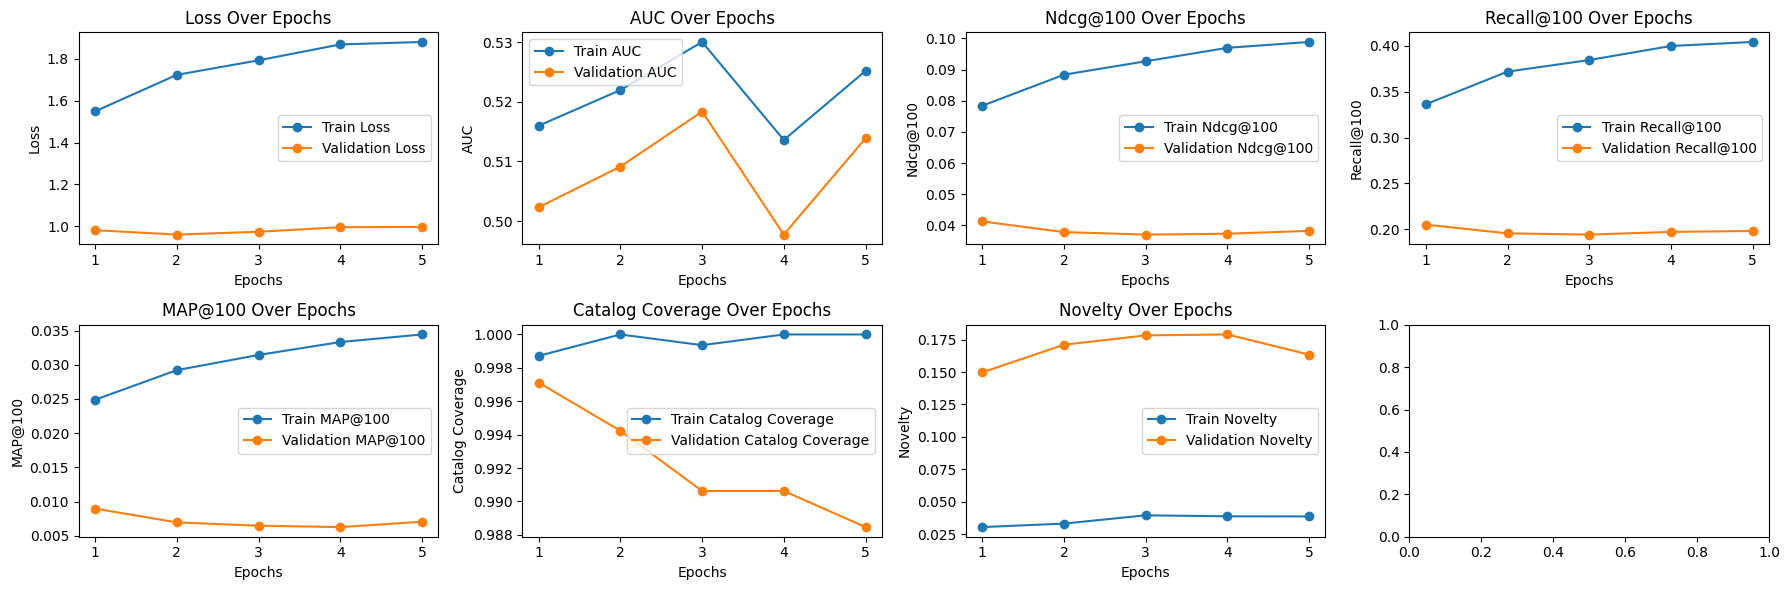

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


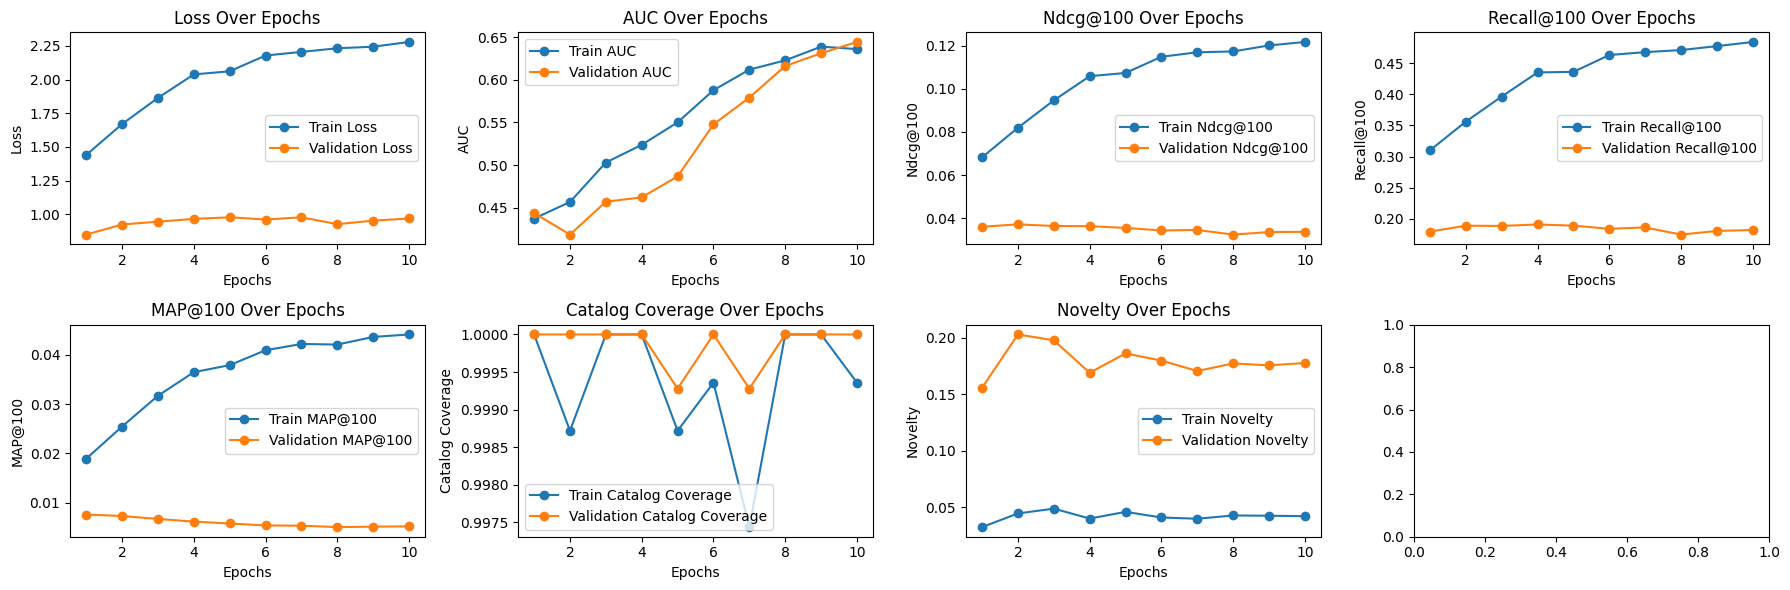

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


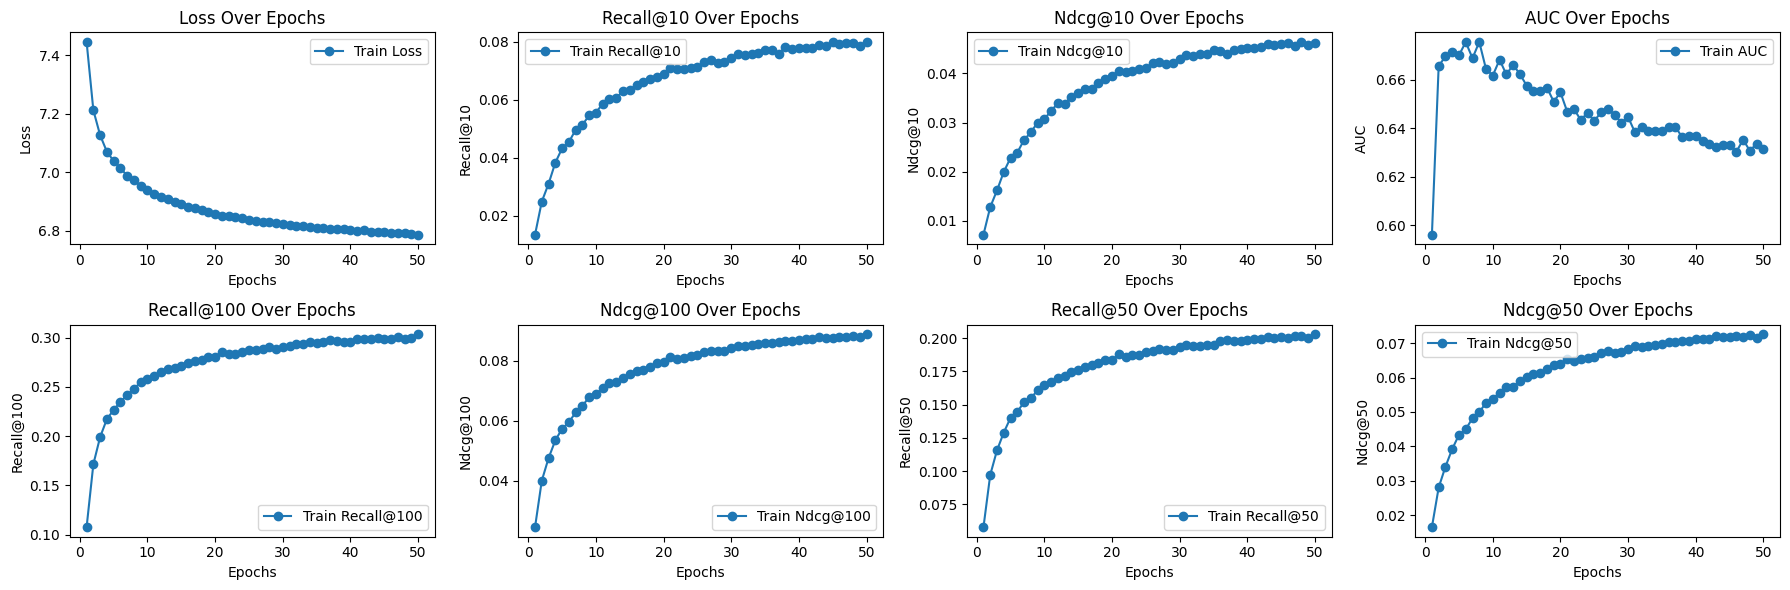

In [ ]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, None, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

### model_v2

In [ ]:
VERSION = 'v2'

_tower_dim = [512, 256] # @param

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 2 # @param
_validation_freq = 5 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 128
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [ ]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [ ]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block  # needed to initiate the text embeddings
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 32s 453ms/step - loss: 7.9621 - auc: 0.5043 - recall_at_100: 0.0548 - mrr_at_100: 0.0035 - ndcg_at_100: 0.0120 - map_at_100: 0.0035 - precision_at_100: 5.4776e-04 - recall_at_50: 0.0284 - mrr_at_50: 0.0031 - ndcg_at_50: 0.0078 - map_at_50: 0.0031 - precision_at_50: 5.6726e-04 - recall_at_10: 0.0064 - mrr_at_10: 0.0022 - ndcg_at_10: 0.0032 - map_at_10: 0.0022 - precision_at_10: 6.4250e-04 - regularization_loss: 0.0000e+00 - loss_batch: 7.8787
Epoch 2/50
35/35 [==============================] - 10s 232ms/step - loss: 7.3422 - auc: 0.6148 - recall_at_100: 0.1179 - mrr_at_100: 0.0078 - ndcg_at_100: 0.0264 - map_at_100: 0.0078 - precision_at_100: 0.0012 - recall_at_50: 0.0625 - mrr_at_50: 0.0071 - ndcg_at_50: 0.0175 - map_at_50: 0.0071 - precision_at_50: 0.0013 - recall_at_10: 0.0157 - mrr_at_10: 0.0052 - ndcg_at_10: 0.0076 - map_at_10: 0.0052 - precision_at_10: 0.0016 - regularization_loss: 0.0000e+00 - loss_batch: 7.2768
Epoch 3/50
35/35

69/69 [==============================] - 10s 36ms/step - loss: 1.4144 - auc: 0.5486 - recall_at_100: 0.3041 - mrr_at_100: 0.0185 - ndcg_at_100: 0.0670 - map_at_100: 0.0185 - precision_at_100: 0.0030 - recall_at_10: 0.0379 - mrr_at_10: 0.0111 - ndcg_at_10: 0.0172 - map_at_10: 0.0111 - precision_at_10: 0.0038 - regularization_loss: 0.0000e+00 - loss_batch: 1.4209
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.4143785238265991, 'auc': 0.5486200451850891, 'recall_at_100': 0.3056323230266571, 'mrr_at_100': 0.018615709617733955, 'ndcg_at_100': 0.0673319399356842, 'map_at_100': 0.018615709617733955, 'precision_at_100': 0.0030563233885914087, 'recall_at_10': 0.0384034626185894, 'mrr_at_10': 0.011255713179707527, 'ndcg_at_10': 0.017458263784646988, 'map_at_10': 0.011255713179707527, 'precision_at_10': 0.0038403465878218412, 'regularization_loss': 0.0, 'loss_batch': 1.7322700023651123, 'coverage': 0.9974375400384369, 'novelty': 0.02829877261951205}
Candidate set rows: 1387


15/15 [==============================] - 4s 23ms/step - loss: 0.9203 - auc: 0.5573 - recall_at_100: 0.1866 - mrr_at_100: 0.0078 - ndcg_at_100: 0.0373 - map_at_100: 0.0078 - precision_at_100: 0.0019 - recall_at_10: 0.0159 - mrr_at_10: 0.0037 - ndcg_at_10: 0.0064 - map_at_10: 0.0037 - precision_at_10: 0.0016 - regularization_loss: 0.0000e+00 - loss_batch: 0.9754
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9202835559844971, 'auc': 0.5573176145553589, 'recall_at_100': 0.19479738175868988, 'mrr_at_100': 0.008660365827381611, 'ndcg_at_100': 0.03947906568646431, 'map_at_100': 0.008660365827381611, 'precision_at_100': 0.0019479738548398018, 'recall_at_10': 0.016784807667136192, 'mrr_at_10': 0.004188957158476114, 'ndcg_at_10': 0.007032447494566441, 'map_at_10': 0.004188957158476114, 'precision_at_10': 0.001678480883128941, 'regularization_loss': 0.0, 'loss_batch': 1.551224946975708, 'coverage': 0.9826964671953857, 'novelty': 0.14773617421275265}
35/35 [================

69/69 [==============================] - 6s 22ms/step - loss: 1.6111 - auc: 0.5005 - recall_at_100: 0.3427 - mrr_at_100: 0.0231 - ndcg_at_100: 0.0777 - map_at_100: 0.0231 - precision_at_100: 0.0034 - recall_at_10: 0.0499 - mrr_at_10: 0.0151 - ndcg_at_10: 0.0230 - map_at_10: 0.0151 - precision_at_10: 0.0050 - regularization_loss: 0.0000e+00 - loss_batch: 1.6215
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.6110666990280151, 'auc': 0.5005435347557068, 'recall_at_100': 0.3433520495891571, 'mrr_at_100': 0.023533759638667107, 'ndcg_at_100': 0.07815767824649811, 'map_at_100': 0.023533759638667107, 'precision_at_100': 0.0034335206728428602, 'recall_at_10': 0.049699440598487854, 'mrr_at_10': 0.015382323414087296, 'ndcg_at_10': 0.023239772766828537, 'map_at_10': 0.015382323414087296, 'precision_at_10': 0.004969943314790726, 'regularization_loss': 0.0, 'loss_batch': 2.118807792663574, 'coverage': 1.0, 'novelty': 0.04268513489045809}
Candidate set rows: 1387


15/15 [==============================] - 4s 24ms/step - loss: 0.9140 - auc: 0.4830 - recall_at_100: 0.1835 - mrr_at_100: 0.0071 - ndcg_at_100: 0.0360 - map_at_100: 0.0071 - precision_at_100: 0.0018 - recall_at_10: 0.0122 - mrr_at_10: 0.0029 - ndcg_at_10: 0.0050 - map_at_10: 0.0029 - precision_at_10: 0.0012 - regularization_loss: 0.0000e+00 - loss_batch: 0.9708
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9139569401741028, 'auc': 0.4829624891281128, 'recall_at_100': 0.18811020255088806, 'mrr_at_100': 0.007910734973847866, 'ndcg_at_100': 0.037591367959976196, 'map_at_100': 0.007910734973847866, 'precision_at_100': 0.0018811019835993648, 'recall_at_10': 0.013775578700006008, 'mrr_at_10': 0.00355969974771142, 'ndcg_at_10': 0.005877070594578981, 'map_at_10': 0.00355969974771142, 'precision_at_10': 0.0013775578700006008, 'regularization_loss': 0.0, 'loss_batch': 1.5657973289489746, 'coverage': 0.989185291997116, 'novelty': 0.19391322229076702}
35/35 [================

69/69 [==============================] - 6s 23ms/step - loss: 1.7421 - auc: 0.5126 - recall_at_100: 0.3656 - mrr_at_100: 0.0280 - ndcg_at_100: 0.0859 - map_at_100: 0.0280 - precision_at_100: 0.0037 - recall_at_10: 0.0567 - mrr_at_10: 0.0192 - ndcg_at_10: 0.0278 - map_at_10: 0.0192 - precision_at_10: 0.0057 - regularization_loss: 0.0000e+00 - loss_batch: 1.7542
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7420846223831177, 'auc': 0.512566328048706, 'recall_at_100': 0.36899232864379883, 'mrr_at_100': 0.027798723429441452, 'ndcg_at_100': 0.08640511333942413, 'map_at_100': 0.027798723429441452, 'precision_at_100': 0.0036899240221828222, 'recall_at_10': 0.05761944130063057, 'mrr_at_10': 0.01896095834672451, 'ndcg_at_10': 0.0278290044516325, 'map_at_10': 0.01896095834672451, 'precision_at_10': 0.005761943757534027, 'regularization_loss': 0.0, 'loss_batch': 2.327500581741333, 'coverage': 1.0, 'novelty': 0.03876192042091417}
Candidate set rows: 1387


15/15 [==============================] - 4s 25ms/step - loss: 0.9645 - auc: 0.4856 - recall_at_100: 0.1879 - mrr_at_100: 0.0065 - ndcg_at_100: 0.0360 - map_at_100: 0.0065 - precision_at_100: 0.0019 - recall_at_10: 0.0100 - mrr_at_10: 0.0022 - ndcg_at_10: 0.0040 - map_at_10: 0.0022 - precision_at_10: 0.0010 - regularization_loss: 0.0000e+00 - loss_batch: 1.0236
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9645382165908813, 'auc': 0.4855593144893646, 'recall_at_100': 0.19225625693798065, 'mrr_at_100': 0.0069499448873102665, 'ndcg_at_100': 0.037230368703603745, 'map_at_100': 0.0069499448873102665, 'precision_at_100': 0.001922562369145453, 'recall_at_10': 0.011435067281126976, 'mrr_at_10': 0.002617789898067713, 'ndcg_at_10': 0.004610342439264059, 'map_at_10': 0.002617789898067713, 'precision_at_10': 0.0011435069609433413, 'regularization_loss': 0.0, 'loss_batch': 1.641373634338379, 'coverage': 0.9949531362653208, 'novelty': 0.17283724340175954}
35/35 [=============

69/69 [==============================] - 6s 25ms/step - loss: 1.8868 - auc: 0.5658 - recall_at_100: 0.4041 - mrr_at_100: 0.0320 - ndcg_at_100: 0.0964 - map_at_100: 0.0320 - precision_at_100: 0.0040 - recall_at_10: 0.0682 - mrr_at_10: 0.0221 - ndcg_at_10: 0.0327 - map_at_10: 0.0221 - precision_at_10: 0.0068 - regularization_loss: 0.0000e+00 - loss_batch: 1.8989
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.8868452310562134, 'auc': 0.5657991170883179, 'recall_at_100': 0.4035924971103668, 'mrr_at_100': 0.03225003927946091, 'ndcg_at_100': 0.0966164618730545, 'map_at_100': 0.03225003927946091, 'precision_at_100': 0.004035924095660448, 'recall_at_10': 0.06887268275022507, 'mrr_at_10': 0.022432515397667885, 'ndcg_at_10': 0.03309432417154312, 'map_at_10': 0.022432515397667885, 'precision_at_10': 0.006887268275022507, 'regularization_loss': 0.0, 'loss_batch': 2.472519636154175, 'coverage': 1.0, 'novelty': 0.03306451612903226}
Candidate set rows: 1387


15/15 [==============================] - 4s 25ms/step - loss: 0.9949 - auc: 0.5350 - recall_at_100: 0.2012 - mrr_at_100: 0.0073 - ndcg_at_100: 0.0391 - map_at_100: 0.0073 - precision_at_100: 0.0020 - recall_at_10: 0.0117 - mrr_at_10: 0.0026 - ndcg_at_10: 0.0047 - map_at_10: 0.0026 - precision_at_10: 0.0012 - regularization_loss: 0.0000e+00 - loss_batch: 1.0438
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9949491024017334, 'auc': 0.5350228548049927, 'recall_at_100': 0.19981275498867035, 'mrr_at_100': 0.007380868308246136, 'ndcg_at_100': 0.03890456259250641, 'map_at_100': 0.007380868308246136, 'precision_at_100': 0.0019981274381279945, 'recall_at_10': 0.011501939035952091, 'mrr_at_10': 0.0027408127207309008, 'ndcg_at_10': 0.004714098293334246, 'map_at_10': 0.0027408127207309008, 'precision_at_10': 0.0011501939734444022, 'regularization_loss': 0.0, 'loss_batch': 1.554539680480957, 'coverage': 0.9920692141312184, 'novelty': 0.16425709806653893}
35/35 [=============

69/69 [==============================] - 9s 27ms/step - loss: 1.9702 - auc: 0.5351 - recall_at_100: 0.4229 - mrr_at_100: 0.0326 - ndcg_at_100: 0.1002 - map_at_100: 0.0326 - precision_at_100: 0.0042 - recall_at_10: 0.0695 - mrr_at_10: 0.0222 - ndcg_at_10: 0.0330 - map_at_10: 0.0222 - precision_at_10: 0.0070 - regularization_loss: 0.0000e+00 - loss_batch: 1.9832
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9701577425003052, 'auc': 0.5351371765136719, 'recall_at_100': 0.42072874307632446, 'mrr_at_100': 0.03343869373202324, 'ndcg_at_100': 0.10052073746919632, 'map_at_100': 0.03343869373202324, 'precision_at_100': 0.004207286983728409, 'recall_at_10': 0.07143671065568924, 'mrr_at_10': 0.023202434182167053, 'ndcg_at_10': 0.03427375480532646, 'map_at_10': 0.023202434182167053, 'precision_at_10': 0.007143671158701181, 'regularization_loss': 0.0, 'loss_batch': 2.603492021560669, 'coverage': 1.0, 'novelty': 0.038010399451811845}
Candidate set rows: 1387


15/15 [==============================] - 4s 37ms/step - loss: 0.9833 - auc: 0.5003 - recall_at_100: 0.1928 - mrr_at_100: 0.0070 - ndcg_at_100: 0.0373 - map_at_100: 0.0070 - precision_at_100: 0.0019 - recall_at_10: 0.0124 - mrr_at_10: 0.0028 - ndcg_at_10: 0.0050 - map_at_10: 0.0028 - precision_at_10: 0.0012 - regularization_loss: 0.0000e+00 - loss_batch: 1.0176
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9833006858825684, 'auc': 0.5003486275672913, 'recall_at_100': 0.19653604924678802, 'mrr_at_100': 0.0074980310164391994, 'ndcg_at_100': 0.03846026957035065, 'map_at_100': 0.0074980310164391994, 'precision_at_100': 0.0019653604831546545, 'recall_at_10': 0.013775578700006008, 'mrr_at_10': 0.00318129057995975, 'ndcg_at_10': 0.005594618618488312, 'map_at_10': 0.00318129057995975, 'precision_at_10': 0.0013775578700006008, 'regularization_loss': 0.0, 'loss_batch': 1.3765709400177002, 'coverage': 0.9920692141312184, 'novelty': 0.15721907302434146}
35/35 [==============

69/69 [==============================] - 9s 22ms/step - loss: 1.9693 - auc: 0.5130 - recall_at_100: 0.4191 - mrr_at_100: 0.0337 - ndcg_at_100: 0.1006 - map_at_100: 0.0337 - precision_at_100: 0.0042 - recall_at_10: 0.0728 - mrr_at_10: 0.0236 - ndcg_at_10: 0.0348 - map_at_10: 0.0236 - precision_at_10: 0.0073 - regularization_loss: 0.0000e+00 - loss_batch: 1.9829
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9693115949630737, 'auc': 0.513039231300354, 'recall_at_100': 0.41867753863334656, 'mrr_at_100': 0.03449686989188194, 'ndcg_at_100': 0.10129642486572266, 'map_at_100': 0.03449686989188194, 'precision_at_100': 0.00418677506968379, 'recall_at_10': 0.07485541701316833, 'mrr_at_10': 0.024358194321393967, 'ndcg_at_10': 0.035950787365436554, 'map_at_10': 0.024358194321393967, 'precision_at_10': 0.007485543377697468, 'regularization_loss': 0.0, 'loss_batch': 2.630314350128174, 'coverage': 1.0, 'novelty': 0.03777288203484879}
Candidate set rows: 1387


15/15 [==============================] - 5s 37ms/step - loss: 1.0154 - auc: 0.4725 - recall_at_100: 0.1951 - mrr_at_100: 0.0061 - ndcg_at_100: 0.0367 - map_at_100: 0.0061 - precision_at_100: 0.0020 - recall_at_10: 0.0095 - mrr_at_10: 0.0018 - ndcg_at_10: 0.0035 - map_at_10: 0.0018 - precision_at_10: 9.4724e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0497
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.015442132949829, 'auc': 0.47247904539108276, 'recall_at_100': 0.19921091198921204, 'mrr_at_100': 0.006563376169651747, 'ndcg_at_100': 0.0378664955496788, 'map_at_100': 0.006563376169651747, 'precision_at_100': 0.0019921089988201857, 'recall_at_10': 0.01083322148770094, 'mrr_at_10': 0.00217667524702847, 'ndcg_at_10': 0.00411922438070178, 'map_at_10': 0.00217667524702847, 'precision_at_10': 0.001083322218619287, 'regularization_loss': 0.0, 'loss_batch': 1.408301830291748, 'coverage': 0.992790194664744, 'novelty': 0.1679729248307802}
35/35 [===================

69/69 [==============================] - 6s 22ms/step - loss: 2.0346 - auc: 0.5173 - recall_at_100: 0.4312 - mrr_at_100: 0.0353 - ndcg_at_100: 0.1042 - map_at_100: 0.0353 - precision_at_100: 0.0043 - recall_at_10: 0.0770 - mrr_at_10: 0.0248 - ndcg_at_10: 0.0368 - map_at_10: 0.0248 - precision_at_10: 0.0077 - regularization_loss: 0.0000e+00 - loss_batch: 2.0485
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.034564256668091, 'auc': 0.5173047184944153, 'recall_at_100': 0.4312555193901062, 'mrr_at_100': 0.03539734706282616, 'ndcg_at_100': 0.10425689816474915, 'map_at_100': 0.03539734706282616, 'precision_at_100': 0.004312554839998484, 'recall_at_10': 0.07655052840709686, 'mrr_at_10': 0.024867797270417213, 'ndcg_at_10': 0.036732159554958344, 'map_at_10': 0.024867797270417213, 'precision_at_10': 0.007655052002519369, 'regularization_loss': 0.0, 'loss_batch': 2.7119810581207275, 'coverage': 1.0, 'novelty': 0.03984282575629542}
Candidate set rows: 1387


15/15 [==============================] - 4s 26ms/step - loss: 0.9538 - auc: 0.4891 - recall_at_100: 0.1800 - mrr_at_100: 0.0058 - ndcg_at_100: 0.0340 - map_at_100: 0.0058 - precision_at_100: 0.0018 - recall_at_10: 0.0086 - mrr_at_10: 0.0019 - ndcg_at_10: 0.0034 - map_at_10: 0.0019 - precision_at_10: 8.5881e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0076
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9537778496742249, 'auc': 0.4891389310359955, 'recall_at_100': 0.18543533980846405, 'mrr_at_100': 0.006290259771049023, 'ndcg_at_100': 0.035409703850746155, 'map_at_100': 0.006290259771049023, 'precision_at_100': 0.0018543533515185118, 'recall_at_10': 0.00936204381287098, 'mrr_at_10': 0.002115110866725445, 'ndcg_at_10': 0.003752518678084016, 'map_at_10': 0.002115110866725445, 'precision_at_10': 0.000936204451136291, 'regularization_loss': 0.0, 'loss_batch': 1.5699361562728882, 'coverage': 0.9942321557317952, 'novelty': 0.18006492266564827}
35/35 [===========

69/69 [==============================] - 7s 22ms/step - loss: 2.0771 - auc: 0.5334 - recall_at_100: 0.4351 - mrr_at_100: 0.0357 - ndcg_at_100: 0.1053 - map_at_100: 0.0357 - precision_at_100: 0.0044 - recall_at_10: 0.0779 - mrr_at_10: 0.0250 - ndcg_at_10: 0.0371 - map_at_10: 0.0250 - precision_at_10: 0.0078 - regularization_loss: 0.0000e+00 - loss_batch: 2.0901
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.07707142829895, 'auc': 0.5333614945411682, 'recall_at_100': 0.4376228451728821, 'mrr_at_100': 0.036221738904714584, 'ndcg_at_100': 0.10611896961927414, 'map_at_100': 0.036221738904714584, 'precision_at_100': 0.004376227967441082, 'recall_at_10': 0.07882966101169586, 'mrr_at_10': 0.025543762370944023, 'ndcg_at_10': 0.03777679428458214, 'map_at_10': 0.025543762370944023, 'precision_at_10': 0.007882964797317982, 'regularization_loss': 0.0, 'loss_batch': 2.709092140197754, 'coverage': 1.0, 'novelty': 0.04205878417554971}
Candidate set rows: 1387


15/15 [==============================] - 6s 38ms/step - loss: 0.9711 - auc: 0.4974 - recall_at_100: 0.1870 - mrr_at_100: 0.0058 - ndcg_at_100: 0.0351 - map_at_100: 0.0058 - precision_at_100: 0.0019 - recall_at_10: 0.0078 - mrr_at_10: 0.0016 - ndcg_at_10: 0.0030 - map_at_10: 0.0016 - precision_at_10: 7.8144e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0207
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9711158275604248, 'auc': 0.4973844885826111, 'recall_at_100': 0.1879095882177353, 'mrr_at_100': 0.006057693623006344, 'ndcg_at_100': 0.035591814666986465, 'map_at_100': 0.006057693623006344, 'precision_at_100': 0.0018790957983583212, 'recall_at_10': 0.009094556793570518, 'mrr_at_10': 0.0018370621837675571, 'ndcg_at_10': 0.0034647854045033455, 'map_at_10': 0.0018370621837675571, 'precision_at_10': 0.0009094557026401162, 'regularization_loss': 0.0, 'loss_batch': 1.5393052101135254, 'coverage': 0.9920692141312184, 'novelty': 0.17622874229116053}
35/35 [=======

69/69 [==============================] - 6s 24ms/step - loss: 2.1198 - auc: 0.5215 - recall_at_100: 0.4482 - mrr_at_100: 0.0371 - ndcg_at_100: 0.1087 - map_at_100: 0.0371 - precision_at_100: 0.0045 - recall_at_10: 0.0806 - mrr_at_10: 0.0261 - ndcg_at_10: 0.0386 - map_at_10: 0.0261 - precision_at_10: 0.0081 - regularization_loss: 0.0000e+00 - loss_batch: 2.1330
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.119751453399658, 'auc': 0.5214800834655762, 'recall_at_100': 0.4498162567615509, 'mrr_at_100': 0.03781392425298691, 'ndcg_at_100': 0.10959799587726593, 'map_at_100': 0.03781392425298691, 'precision_at_100': 0.0044981627725064754, 'recall_at_10': 0.08169282972812653, 'mrr_at_10': 0.026845555752515793, 'ndcg_at_10': 0.039450909942388535, 'map_at_10': 0.026845555752515793, 'precision_at_10': 0.008169281296432018, 'regularization_loss': 0.0, 'loss_batch': 2.761209487915039, 'coverage': 0.9993593850096092, 'novelty': 0.040699179974104445}
Candidate set rows: 1387


15/15 [==============================] - 4s 25ms/step - loss: 0.9652 - auc: 0.4861 - recall_at_100: 0.1811 - mrr_at_100: 0.0058 - ndcg_at_100: 0.0340 - map_at_100: 0.0058 - precision_at_100: 0.0018 - recall_at_10: 0.0073 - mrr_at_10: 0.0018 - ndcg_at_10: 0.0030 - map_at_10: 0.0018 - precision_at_10: 7.3371e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0108
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9652268886566162, 'auc': 0.4860715866088867, 'recall_at_100': 0.18683964014053345, 'mrr_at_100': 0.006152979098260403, 'ndcg_at_100': 0.03537529706954956, 'map_at_100': 0.006152979098260403, 'precision_at_100': 0.001868396415375173, 'recall_at_10': 0.008626454509794712, 'mrr_at_10': 0.002026213798671961, 'ndcg_at_10': 0.003519188379868865, 'map_at_10': 0.002026213798671961, 'precision_at_10': 0.0008626455091871321, 'regularization_loss': 0.0, 'loss_batch': 1.4868720769882202, 'coverage': 0.992790194664744, 'novelty': 0.1761628993087988}
35/35 [=============

69/69 [==============================] - 9s 28ms/step - loss: 2.1331 - auc: 0.5211 - recall_at_100: 0.4477 - mrr_at_100: 0.0369 - ndcg_at_100: 0.1084 - map_at_100: 0.0369 - precision_at_100: 0.0045 - recall_at_10: 0.0801 - mrr_at_10: 0.0260 - ndcg_at_10: 0.0385 - map_at_10: 0.0260 - precision_at_10: 0.0080 - regularization_loss: 0.0000e+00 - loss_batch: 2.1464
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.133091926574707, 'auc': 0.5210572481155396, 'recall_at_100': 0.4493746757507324, 'mrr_at_100': 0.037487152963876724, 'ndcg_at_100': 0.10917871445417404, 'map_at_100': 0.037487152963876724, 'precision_at_100': 0.0044937459751963615, 'recall_at_10': 0.0809093788266182, 'mrr_at_10': 0.02656646817922592, 'ndcg_at_10': 0.03905859589576721, 'map_at_10': 0.02656646817922592, 'precision_at_10': 0.008090936578810215, 'regularization_loss': 0.0, 'loss_batch': 2.7808117866516113, 'coverage': 1.0, 'novelty': 0.040340520191649555}
Candidate set rows: 1387


15/15 [==============================] - 5s 37ms/step - loss: 0.9223 - auc: 0.4938 - recall_at_100: 0.1717 - mrr_at_100: 0.0056 - ndcg_at_100: 0.0323 - map_at_100: 0.0056 - precision_at_100: 0.0017 - recall_at_10: 0.0077 - mrr_at_10: 0.0020 - ndcg_at_10: 0.0033 - map_at_10: 0.0020 - precision_at_10: 7.7137e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9671
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9222579598426819, 'auc': 0.49375268816947937, 'recall_at_100': 0.176207035779953, 'mrr_at_100': 0.005938159301877022, 'ndcg_at_100': 0.033475421369075775, 'map_at_100': 0.005938159301877022, 'precision_at_100': 0.0017620703438296914, 'recall_at_10': 0.008960813283920288, 'mrr_at_10': 0.0021277419291436672, 'ndcg_at_10': 0.0036613454576581717, 'map_at_10': 0.0021277419291436672, 'precision_at_10': 0.0008960814448073506, 'regularization_loss': 0.0, 'loss_batch': 1.4355013370513916, 'coverage': 0.992790194664744, 'novelty': 0.17775683317624882}
35/35 [========

#### analysis

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v2


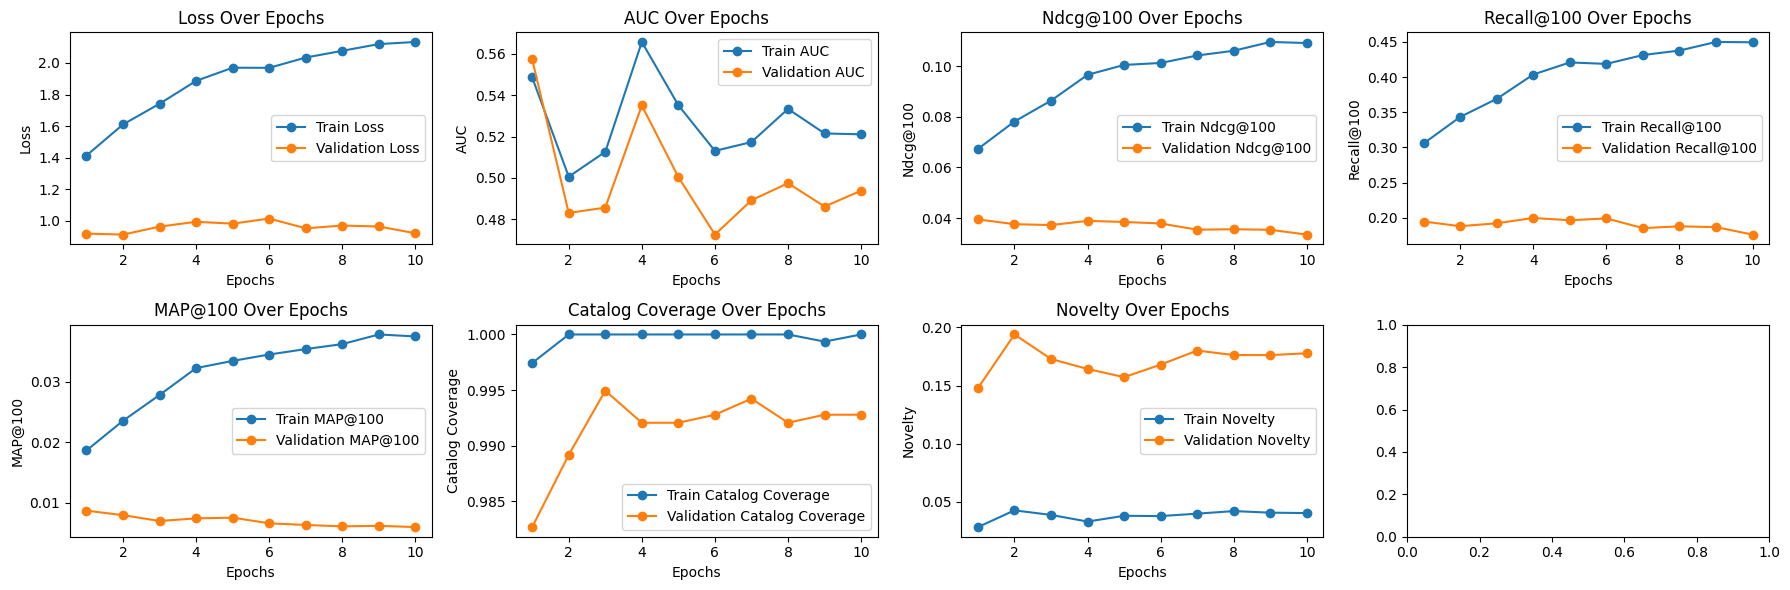

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


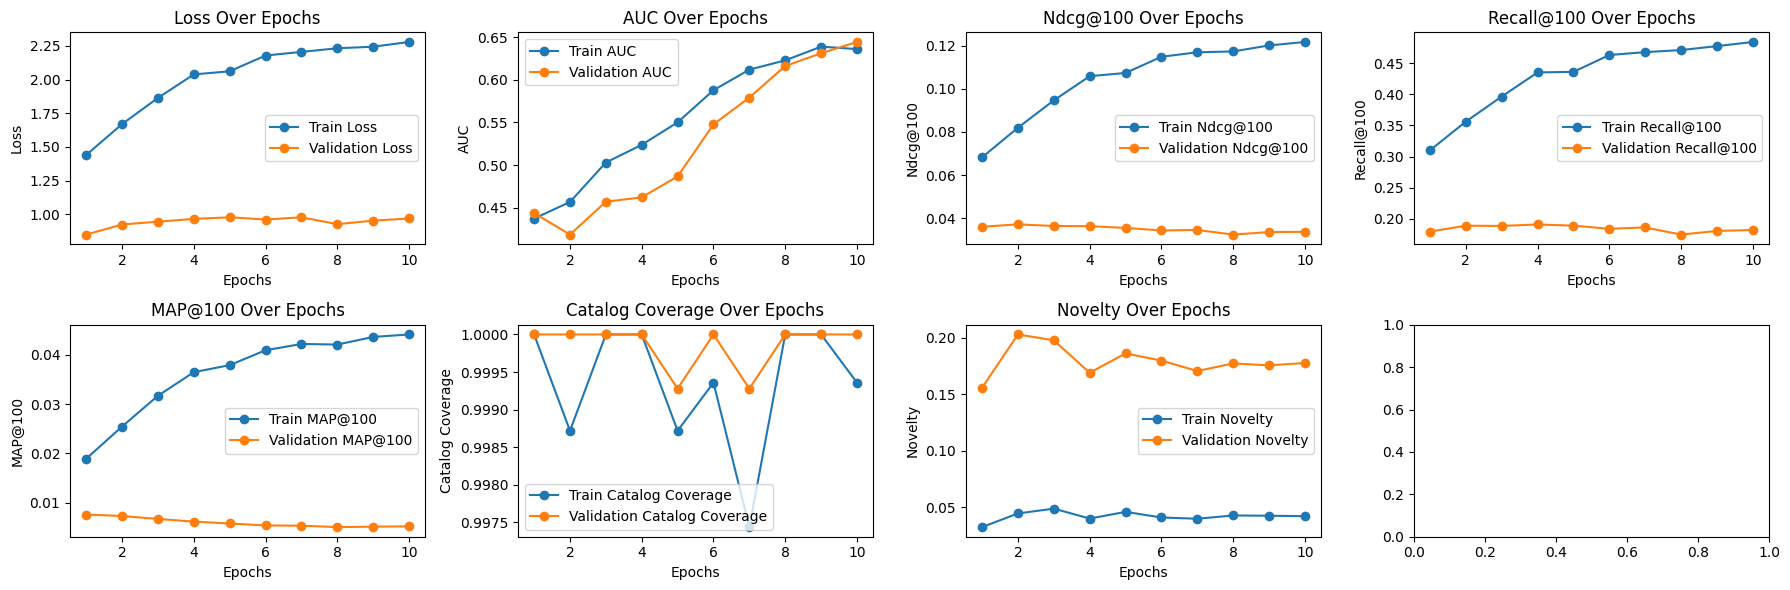

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


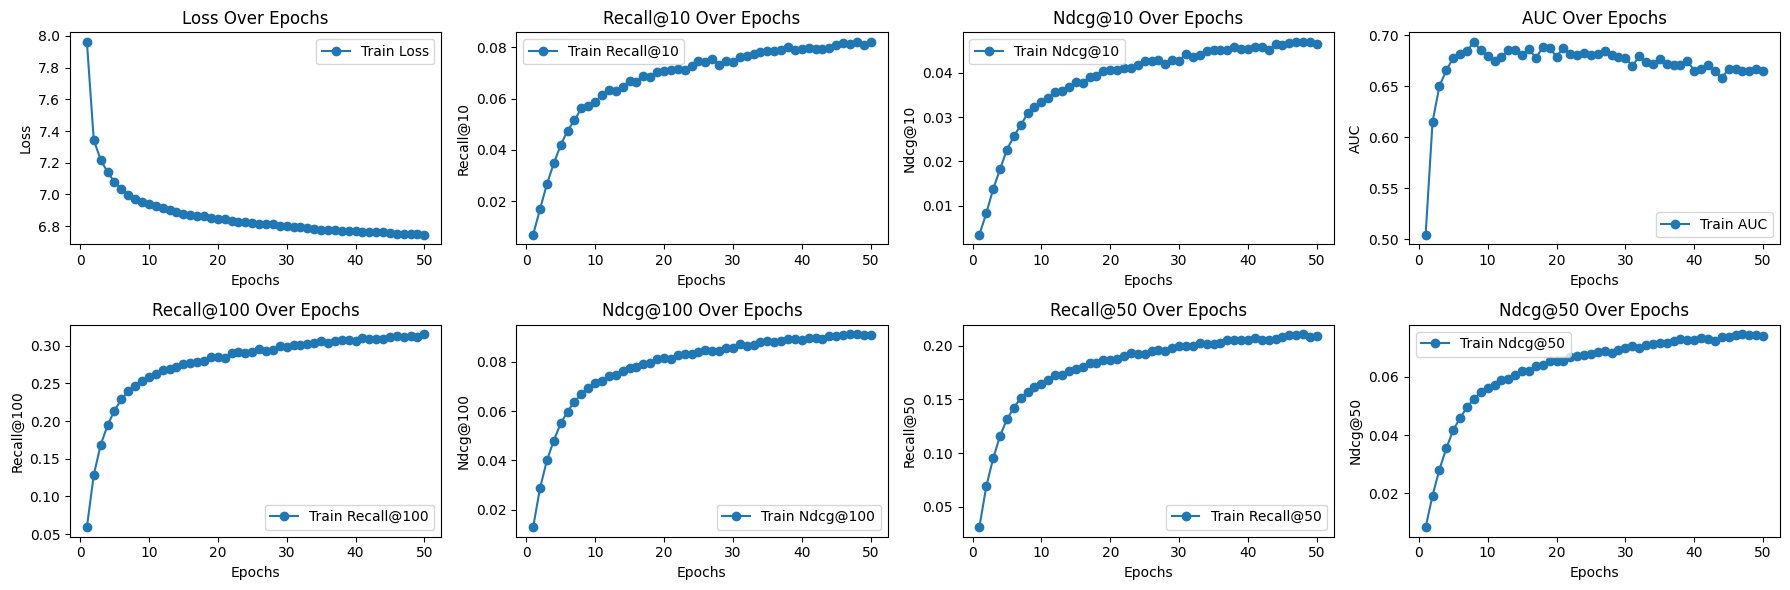

In [ ]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, None, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

### model_v3

In [ ]:
VERSION = 'v3'

_tower_dim = {
    'user':[128, 128],
    'item':[512, 256, 128],
}

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 2 # @param
_validation_freq = 5 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 128
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [ ]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

RuntimeError: ignored

In [ ]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block  # needed to initiate the text embeddings
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 33s 505ms/step - loss: 7.3833 - auc: 0.5689 - recall_at_100: 0.1007 - mrr_at_100: 0.0073 - ndcg_at_100: 0.0230 - map_at_100: 0.0073 - precision_at_100: 0.0010 - recall_at_50: 0.0543 - mrr_at_50: 0.0066 - ndcg_at_50: 0.0156 - map_at_50: 0.0066 - precision_at_50: 0.0011 - recall_at_10: 0.0145 - mrr_at_10: 0.0050 - ndcg_at_10: 0.0072 - map_at_10: 0.0050 - precision_at_10: 0.0014 - regularization_loss: 0.0000e+00 - loss_batch: 7.3088
Epoch 2/50
35/35 [==============================] - 11s 268ms/step - loss: 7.0970 - auc: 0.6180 - recall_at_100: 0.2029 - mrr_at_100: 0.0200 - ndcg_at_100: 0.0515 - map_at_100: 0.0200 - precision_at_100: 0.0020 - recall_at_50: 0.1238 - mrr_at_50: 0.0189 - ndcg_at_50: 0.0387 - map_at_50: 0.0189 - precision_at_50: 0.0025 - recall_at_10: 0.0382 - mrr_at_10: 0.0154 - ndcg_at_10: 0.0206 - map_at_10: 0.0154 - precision_at_10: 0.0038 - regularization_loss: 0.0000e+00 - loss_batch: 7.0302
Epoch 3/50
35/35 [==========

69/69 [==============================] - 6s 22ms/step - loss: 1.6359 - auc: 0.5653 - recall_at_100: 0.3519 - mrr_at_100: 0.0254 - ndcg_at_100: 0.0816 - map_at_100: 0.0254 - precision_at_100: 0.0035 - recall_at_10: 0.0548 - mrr_at_10: 0.0168 - ndcg_at_10: 0.0255 - map_at_10: 0.0168 - precision_at_10: 0.0055 - regularization_loss: 0.0000e+00 - loss_batch: 1.6448
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.635948896408081, 'auc': 0.565330982208252, 'recall_at_100': 0.35219794511795044, 'mrr_at_100': 0.025360343977808952, 'ndcg_at_100': 0.08159705251455307, 'map_at_100': 0.025360343977808952, 'precision_at_100': 0.0035219788551330566, 'recall_at_10': 0.05458533763885498, 'mrr_at_10': 0.016833636909723282, 'ndcg_at_10': 0.025482455268502235, 'map_at_10': 0.016833636909723282, 'precision_at_10': 0.005458532832562923, 'regularization_loss': 0.0, 'loss_batch': 2.0673227310180664, 'coverage': 1.0, 'novelty': 0.025462400432023764}
Candidate set rows: 1387


15/15 [==============================] - 4s 25ms/step - loss: 0.9369 - auc: 0.5801 - recall_at_100: 0.1889 - mrr_at_100: 0.0078 - ndcg_at_100: 0.0376 - map_at_100: 0.0078 - precision_at_100: 0.0019 - recall_at_10: 0.0134 - mrr_at_10: 0.0035 - ndcg_at_10: 0.0057 - map_at_10: 0.0035 - precision_at_10: 0.0013 - regularization_loss: 0.0000e+00 - loss_batch: 0.9985
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9369248747825623, 'auc': 0.5801243782043457, 'recall_at_100': 0.19245687127113342, 'mrr_at_100': 0.007856449112296104, 'ndcg_at_100': 0.03825749084353447, 'map_at_100': 0.007856449112296104, 'precision_at_100': 0.0019245685543864965, 'recall_at_10': 0.0141768092289567, 'mrr_at_10': 0.0034611434675753117, 'ndcg_at_10': 0.005880034063011408, 'map_at_10': 0.0034611434675753117, 'precision_at_10': 0.001417680992744863, 'regularization_loss': 0.0, 'loss_batch': 1.6427901983261108, 'coverage': 0.9805335255948089, 'novelty': 0.15620341229087295}
35/35 [===============

69/69 [==============================] - 9s 26ms/step - loss: 1.7737 - auc: 0.5285 - recall_at_100: 0.3756 - mrr_at_100: 0.0269 - ndcg_at_100: 0.0869 - map_at_100: 0.0269 - precision_at_100: 0.0038 - recall_at_10: 0.0588 - mrr_at_10: 0.0179 - ndcg_at_10: 0.0273 - map_at_10: 0.0179 - precision_at_10: 0.0059 - regularization_loss: 0.0000e+00 - loss_batch: 1.7866
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7737200260162354, 'auc': 0.5284672975540161, 'recall_at_100': 0.3764992356300354, 'mrr_at_100': 0.028165556490421295, 'ndcg_at_100': 0.088175468146801, 'map_at_100': 0.028165556490421295, 'precision_at_100': 0.0037649923469871283, 'recall_at_10': 0.06063929945230484, 'mrr_at_10': 0.019135188311338425, 'ndcg_at_10': 0.028656454756855965, 'map_at_10': 0.019135188311338425, 'precision_at_10': 0.006063929293304682, 'regularization_loss': 0.0, 'loss_batch': 2.398569107055664, 'coverage': 1.0, 'novelty': 0.03813182369591589}
Candidate set rows: 1387


15/15 [==============================] - 5s 39ms/step - loss: 0.9696 - auc: 0.5328 - recall_at_100: 0.1857 - mrr_at_100: 0.0071 - ndcg_at_100: 0.0362 - map_at_100: 0.0071 - precision_at_100: 0.0019 - recall_at_10: 0.0116 - mrr_at_10: 0.0030 - ndcg_at_10: 0.0049 - map_at_10: 0.0030 - precision_at_10: 0.0012 - regularization_loss: 0.0000e+00 - loss_batch: 1.0256
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9695783257484436, 'auc': 0.532802402973175, 'recall_at_100': 0.19486424326896667, 'mrr_at_100': 0.007404153235256672, 'ndcg_at_100': 0.03809351101517677, 'map_at_100': 0.007404153235256672, 'precision_at_100': 0.0019486424280330539, 'recall_at_10': 0.012237528339028358, 'mrr_at_10': 0.0030101039446890354, 'ndcg_at_10': 0.005105634219944477, 'map_at_10': 0.0030101039446890354, 'precision_at_10': 0.001223752973601222, 'regularization_loss': 0.0, 'loss_batch': 1.6115323305130005, 'coverage': 0.9841384282624369, 'novelty': 0.16752531533131995}
35/35 [==============

69/69 [==============================] - 7s 22ms/step - loss: 1.7707 - auc: 0.5304 - recall_at_100: 0.3711 - mrr_at_100: 0.0285 - ndcg_at_100: 0.0875 - map_at_100: 0.0285 - precision_at_100: 0.0037 - recall_at_10: 0.0605 - mrr_at_10: 0.0196 - ndcg_at_10: 0.0290 - map_at_10: 0.0196 - precision_at_10: 0.0061 - regularization_loss: 0.0000e+00 - loss_batch: 1.7833
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7707085609436035, 'auc': 0.5303856134414673, 'recall_at_100': 0.3739922046661377, 'mrr_at_100': 0.02896852232515812, 'ndcg_at_100': 0.08844352513551712, 'map_at_100': 0.02896852232515812, 'precision_at_100': 0.003739920910447836, 'recall_at_10': 0.06162217631936073, 'mrr_at_10': 0.020035438239574432, 'ndcg_at_10': 0.02957862988114357, 'map_at_10': 0.020035438239574432, 'precision_at_10': 0.006162217352539301, 'regularization_loss': 0.0, 'loss_batch': 2.379899501800537, 'coverage': 1.0, 'novelty': 0.04869107244281509}
Candidate set rows: 1387


15/15 [==============================] - 6s 38ms/step - loss: 0.9361 - auc: 0.5381 - recall_at_100: 0.1793 - mrr_at_100: 0.0057 - ndcg_at_100: 0.0338 - map_at_100: 0.0057 - precision_at_100: 0.0018 - recall_at_10: 0.0074 - mrr_at_10: 0.0016 - ndcg_at_10: 0.0029 - map_at_10: 0.0016 - precision_at_10: 7.3806e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9962
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9361207485198975, 'auc': 0.5381256341934204, 'recall_at_100': 0.18496723473072052, 'mrr_at_100': 0.006291001569479704, 'ndcg_at_100': 0.035368919372558594, 'map_at_100': 0.006291001569479704, 'precision_at_100': 0.001849672175012529, 'recall_at_10': 0.008827069774270058, 'mrr_at_10': 0.0020674513652920723, 'ndcg_at_10': 0.0035920904483646154, 'map_at_10': 0.0020674513652920723, 'precision_at_10': 0.0008827070123516023, 'regularization_loss': 0.0, 'loss_batch': 1.6247341632843018, 'coverage': 0.9877433309300648, 'novelty': 0.19802603947921044}
35/35 [=======

69/69 [==============================] - 8s 36ms/step - loss: 1.9299 - auc: 0.5251 - recall_at_100: 0.4116 - mrr_at_100: 0.0334 - ndcg_at_100: 0.0992 - map_at_100: 0.0334 - precision_at_100: 0.0041 - recall_at_10: 0.0725 - mrr_at_10: 0.0234 - ndcg_at_10: 0.0346 - map_at_10: 0.0234 - precision_at_10: 0.0072 - regularization_loss: 0.0000e+00 - loss_batch: 1.9414
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9298920631408691, 'auc': 0.5250973105430603, 'recall_at_100': 0.4132218360900879, 'mrr_at_100': 0.034292928874492645, 'ndcg_at_100': 0.10021757334470749, 'map_at_100': 0.034292928874492645, 'precision_at_100': 0.0041322181932628155, 'recall_at_10': 0.07428563386201859, 'mrr_at_10': 0.02426823414862156, 'ndcg_at_10': 0.0357578806579113, 'map_at_10': 0.02426823414862156, 'precision_at_10': 0.007428563199937344, 'regularization_loss': 0.0, 'loss_batch': 2.4886395931243896, 'coverage': 1.0, 'novelty': 0.03721535972216741}
Candidate set rows: 1387


15/15 [==============================] - 3s 24ms/step - loss: 0.9813 - auc: 0.5365 - recall_at_100: 0.1938 - mrr_at_100: 0.0069 - ndcg_at_100: 0.0372 - map_at_100: 0.0069 - precision_at_100: 0.0019 - recall_at_10: 0.0102 - mrr_at_10: 0.0027 - ndcg_at_10: 0.0044 - map_at_10: 0.0027 - precision_at_10: 0.0010 - regularization_loss: 0.0000e+00 - loss_batch: 1.0238
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.981310248374939, 'auc': 0.5365039706230164, 'recall_at_100': 0.19452989101409912, 'mrr_at_100': 0.006807334721088409, 'ndcg_at_100': 0.03738019987940788, 'map_at_100': 0.006807334721088409, 'precision_at_100': 0.0019452989799901843, 'recall_at_10': 0.010298248380422592, 'mrr_at_10': 0.0024225881788879633, 'ndcg_at_10': 0.0042109075002372265, 'map_at_10': 0.0024225881788879633, 'precision_at_10': 0.0010298248380422592, 'regularization_loss': 0.0, 'loss_batch': 1.4682735204696655, 'coverage': 0.9870223503965393, 'novelty': 0.16860361165742893}
35/35 [============

69/69 [==============================] - 9s 36ms/step - loss: 1.9498 - auc: 0.5537 - recall_at_100: 0.4146 - mrr_at_100: 0.0342 - ndcg_at_100: 0.1002 - map_at_100: 0.0342 - precision_at_100: 0.0041 - recall_at_10: 0.0738 - mrr_at_10: 0.0242 - ndcg_at_10: 0.0356 - map_at_10: 0.0242 - precision_at_10: 0.0074 - regularization_loss: 0.0000e+00 - loss_batch: 1.9622
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9498282670974731, 'auc': 0.553683876991272, 'recall_at_100': 0.4126235842704773, 'mrr_at_100': 0.034680381417274475, 'ndcg_at_100': 0.10033991932868958, 'map_at_100': 0.034680381417274475, 'precision_at_100': 0.004126235842704773, 'recall_at_10': 0.0743710994720459, 'mrr_at_10': 0.024758033454418182, 'ndcg_at_10': 0.036173827946186066, 'map_at_10': 0.024758033454418182, 'precision_at_10': 0.0074371094815433025, 'regularization_loss': 0.0, 'loss_batch': 2.548804998397827, 'coverage': 1.0, 'novelty': 0.04290459074571182}
Candidate set rows: 1387


15/15 [==============================] - 5s 27ms/step - loss: 0.9547 - auc: 0.5820 - recall_at_100: 0.1807 - mrr_at_100: 0.0058 - ndcg_at_100: 0.0342 - map_at_100: 0.0058 - precision_at_100: 0.0018 - recall_at_10: 0.0078 - mrr_at_10: 0.0018 - ndcg_at_10: 0.0031 - map_at_10: 0.0018 - precision_at_10: 7.8158e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0052
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9547443985939026, 'auc': 0.5820333957672119, 'recall_at_100': 0.18523472547531128, 'mrr_at_100': 0.005949672777205706, 'ndcg_at_100': 0.03506045788526535, 'map_at_100': 0.005949672777205706, 'precision_at_100': 0.00185234728269279, 'recall_at_10': 0.008760198019444942, 'mrr_at_10': 0.0017875719349831343, 'ndcg_at_10': 0.0033423525746911764, 'map_at_10': 0.0017875719349831343, 'precision_at_10': 0.0008760197670198977, 'regularization_loss': 0.0, 'loss_batch': 1.5333625078201294, 'coverage': 0.9877433309300648, 'novelty': 0.1815206929740135}
35/35 [==========

69/69 [==============================] - 9s 36ms/step - loss: 2.0557 - auc: 0.5334 - recall_at_100: 0.4357 - mrr_at_100: 0.0363 - ndcg_at_100: 0.1059 - map_at_100: 0.0363 - precision_at_100: 0.0044 - recall_at_10: 0.0799 - mrr_at_10: 0.0257 - ndcg_at_10: 0.0381 - map_at_10: 0.0257 - precision_at_10: 0.0080 - regularization_loss: 0.0000e+00 - loss_batch: 2.0689
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.055673360824585, 'auc': 0.5333872437477112, 'recall_at_100': 0.43806445598602295, 'mrr_at_100': 0.03716392070055008, 'ndcg_at_100': 0.1071302518248558, 'map_at_100': 0.03716392070055008, 'precision_at_100': 0.004380643833428621, 'recall_at_10': 0.08093786239624023, 'mrr_at_10': 0.026484787464141846, 'ndcg_at_10': 0.03900858387351036, 'map_at_10': 0.026484787464141846, 'precision_at_10': 0.008093786425888538, 'regularization_loss': 0.0, 'loss_batch': 2.696908950805664, 'coverage': 1.0, 'novelty': 0.035848697966166125}
Candidate set rows: 1387


15/15 [==============================] - 4s 34ms/step - loss: 1.0152 - auc: 0.5371 - recall_at_100: 0.1953 - mrr_at_100: 0.0065 - ndcg_at_100: 0.0371 - map_at_100: 0.0065 - precision_at_100: 0.0020 - recall_at_10: 0.0096 - mrr_at_10: 0.0021 - ndcg_at_10: 0.0038 - map_at_10: 0.0021 - precision_at_10: 9.6059e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0530
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.0151697397232056, 'auc': 0.5371431112289429, 'recall_at_100': 0.1980072259902954, 'mrr_at_100': 0.0064941453747451305, 'ndcg_at_100': 0.037569861859083176, 'map_at_100': 0.0064941453747451305, 'precision_at_100': 0.0019800723530352116, 'recall_at_10': 0.009897017851471901, 'mrr_at_10': 0.0021053189411759377, 'ndcg_at_10': 0.0038590512704104185, 'map_at_10': 0.0021053189411759377, 'precision_at_10': 0.0009897018317133188, 'regularization_loss': 0.0, 'loss_batch': 1.4485188722610474, 'coverage': 0.9826964671953857, 'novelty': 0.15894151356817798}
35/35 [=====

69/69 [==============================] - 9s 34ms/step - loss: 2.0368 - auc: 0.5328 - recall_at_100: 0.4303 - mrr_at_100: 0.0354 - ndcg_at_100: 0.1042 - map_at_100: 0.0354 - precision_at_100: 0.0043 - recall_at_10: 0.0789 - mrr_at_10: 0.0250 - ndcg_at_10: 0.0374 - map_at_10: 0.0250 - precision_at_10: 0.0079 - regularization_loss: 0.0000e+00 - loss_batch: 2.0492
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.036775827407837, 'auc': 0.5328189730644226, 'recall_at_100': 0.4309706389904022, 'mrr_at_100': 0.036516427993774414, 'ndcg_at_100': 0.10526955872774124, 'map_at_100': 0.036516427993774414, 'precision_at_100': 0.004309705924242735, 'recall_at_10': 0.07982678711414337, 'mrr_at_10': 0.026104075834155083, 'ndcg_at_10': 0.038447897881269455, 'map_at_10': 0.026104075834155083, 'precision_at_10': 0.007982680574059486, 'regularization_loss': 0.0, 'loss_batch': 2.641695022583008, 'coverage': 1.0, 'novelty': 0.04279361045561808}
Candidate set rows: 1387


15/15 [==============================] - 5s 41ms/step - loss: 0.9927 - auc: 0.5494 - recall_at_100: 0.1895 - mrr_at_100: 0.0066 - ndcg_at_100: 0.0363 - map_at_100: 0.0066 - precision_at_100: 0.0019 - recall_at_10: 0.0096 - mrr_at_10: 0.0024 - ndcg_at_10: 0.0040 - map_at_10: 0.0024 - precision_at_10: 9.6164e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0285
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9927406311035156, 'auc': 0.5493918061256409, 'recall_at_100': 0.19225625693798065, 'mrr_at_100': 0.0063546327874064445, 'ndcg_at_100': 0.03655141219496727, 'map_at_100': 0.0063546327874064445, 'precision_at_100': 0.0019225624855607748, 'recall_at_10': 0.009027685038745403, 'mrr_at_10': 0.0020175629761070013, 'ndcg_at_10': 0.003586740465834737, 'map_at_10': 0.0020175629761070013, 'precision_at_10': 0.0009027685737237334, 'regularization_loss': 0.0, 'loss_batch': 1.4028337001800537, 'coverage': 0.9906272530641672, 'novelty': 0.17944814462416747}
35/35 [======

69/69 [==============================] - 7s 23ms/step - loss: 2.1098 - auc: 0.5203 - recall_at_100: 0.4452 - mrr_at_100: 0.0378 - ndcg_at_100: 0.1091 - map_at_100: 0.0378 - precision_at_100: 0.0045 - recall_at_10: 0.0838 - mrr_at_10: 0.0269 - ndcg_at_10: 0.0400 - map_at_10: 0.0269 - precision_at_10: 0.0084 - regularization_loss: 0.0000e+00 - loss_batch: 2.1216
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.1098239421844482, 'auc': 0.5202866792678833, 'recall_at_100': 0.44689610600471497, 'mrr_at_100': 0.038496535271406174, 'ndcg_at_100': 0.10994207859039307, 'map_at_100': 0.038496535271406174, 'precision_at_100': 0.004468961618840694, 'recall_at_10': 0.0844847708940506, 'mrr_at_10': 0.027560202404856682, 'ndcg_at_10': 0.0406506173312664, 'map_at_10': 0.027560202404856682, 'precision_at_10': 0.00844847597181797, 'regularization_loss': 0.0, 'loss_batch': 2.682171106338501, 'coverage': 1.0, 'novelty': 0.03805027639914457}
Candidate set rows: 1387


15/15 [==============================] - 4s 25ms/step - loss: 0.9668 - auc: 0.5275 - recall_at_100: 0.1840 - mrr_at_100: 0.0056 - ndcg_at_100: 0.0345 - map_at_100: 0.0056 - precision_at_100: 0.0018 - recall_at_10: 0.0071 - mrr_at_10: 0.0014 - ndcg_at_10: 0.0027 - map_at_10: 0.0014 - precision_at_10: 7.0850e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9989
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9668462872505188, 'auc': 0.5274742841720581, 'recall_at_100': 0.1865052878856659, 'mrr_at_100': 0.005804101005196571, 'ndcg_at_100': 0.03511127457022667, 'map_at_100': 0.005804101005196571, 'precision_at_100': 0.0018650527345016599, 'recall_at_10': 0.00795773696154356, 'mrr_at_10': 0.001610016799531877, 'ndcg_at_10': 0.0030318608041852713, 'map_at_10': 0.001610016799531877, 'precision_at_10': 0.000795773696154356, 'regularization_loss': 0.0, 'loss_batch': 1.3344643115997314, 'coverage': 0.9834174477289113, 'novelty': 0.16183284709112752}
35/35 [============

69/69 [==============================] - 7s 24ms/step - loss: 2.0833 - auc: 0.5161 - recall_at_100: 0.4387 - mrr_at_100: 0.0375 - ndcg_at_100: 0.1076 - map_at_100: 0.0375 - precision_at_100: 0.0044 - recall_at_10: 0.0833 - mrr_at_10: 0.0268 - ndcg_at_10: 0.0398 - map_at_10: 0.0268 - precision_at_10: 0.0083 - regularization_loss: 0.0000e+00 - loss_batch: 2.0949
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.0833492279052734, 'auc': 0.5160784721374512, 'recall_at_100': 0.4405287504196167, 'mrr_at_100': 0.03856515511870384, 'ndcg_at_100': 0.10892762243747711, 'map_at_100': 0.03856515511870384, 'precision_at_100': 0.0044052875600755215, 'recall_at_10': 0.08558160811662674, 'mrr_at_10': 0.027921410277485847, 'ndcg_at_10': 0.04117982089519501, 'map_at_10': 0.027921410277485847, 'precision_at_10': 0.008558161556720734, 'regularization_loss': 0.0, 'loss_batch': 2.644331693649292, 'coverage': 1.0, 'novelty': 0.04047210300429185}
Candidate set rows: 1387


15/15 [==============================] - 5s 24ms/step - loss: 0.9518 - auc: 0.5229 - recall_at_100: 0.1790 - mrr_at_100: 0.0055 - ndcg_at_100: 0.0334 - map_at_100: 0.0055 - precision_at_100: 0.0018 - recall_at_10: 0.0066 - mrr_at_10: 0.0015 - ndcg_at_10: 0.0027 - map_at_10: 0.0015 - precision_at_10: 6.5727e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0024
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.951804518699646, 'auc': 0.5228888988494873, 'recall_at_100': 0.181690514087677, 'mrr_at_100': 0.005623241420835257, 'ndcg_at_100': 0.03415035456418991, 'map_at_100': 0.005623241420835257, 'precision_at_100': 0.0018169052200391889, 'recall_at_10': 0.0066871740855276585, 'mrr_at_10': 0.0014519925462082028, 'ndcg_at_10': 0.002629911992698908, 'map_at_10': 0.0014519925462082028, 'precision_at_10': 0.0006687174900434911, 'regularization_loss': 0.0, 'loss_batch': 1.5309640169143677, 'coverage': 0.9877433309300648, 'novelty': 0.1743390645220928}
35/35 [===========

69/69 [==============================] - 7s 32ms/step - loss: 2.0750 - auc: 0.5387 - recall_at_100: 0.4413 - mrr_at_100: 0.0384 - ndcg_at_100: 0.1089 - map_at_100: 0.0384 - precision_at_100: 0.0044 - recall_at_10: 0.0849 - mrr_at_10: 0.0276 - ndcg_at_10: 0.0408 - map_at_10: 0.0276 - precision_at_10: 0.0085 - regularization_loss: 0.0000e+00 - loss_batch: 2.0874
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.0750458240509033, 'auc': 0.5387058854103088, 'recall_at_100': 0.43974530696868896, 'mrr_at_100': 0.0390460379421711, 'ndcg_at_100': 0.10925523936748505, 'map_at_100': 0.0390460379421711, 'precision_at_100': 0.0043974523432552814, 'recall_at_10': 0.08592347800731659, 'mrr_at_10': 0.028361419215798378, 'ndcg_at_10': 0.04159120097756386, 'map_at_10': 0.028361419215798378, 'precision_at_10': 0.008592347614467144, 'regularization_loss': 0.0, 'loss_batch': 2.673429250717163, 'coverage': 1.0, 'novelty': 0.036863296978226025}
Candidate set rows: 1387


15/15 [==============================] - 4s 25ms/step - loss: 0.9348 - auc: 0.5523 - recall_at_100: 0.1739 - mrr_at_100: 0.0050 - ndcg_at_100: 0.0322 - map_at_100: 0.0050 - precision_at_100: 0.0017 - recall_at_10: 0.0054 - mrr_at_10: 0.0010 - ndcg_at_10: 0.0020 - map_at_10: 0.0010 - precision_at_10: 5.3894e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9779
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9348215460777283, 'auc': 0.5523324012756348, 'recall_at_100': 0.17747759819030762, 'mrr_at_100': 0.005218330770730972, 'ndcg_at_100': 0.03302472457289696, 'map_at_100': 0.005218330770730972, 'precision_at_100': 0.001774776028469205, 'recall_at_10': 0.006152200046926737, 'mrr_at_10': 0.0012509261723607779, 'ndcg_at_10': 0.0023561788257211447, 'map_at_10': 0.0012509261723607779, 'precision_at_10': 0.0006152199930511415, 'regularization_loss': 0.0, 'loss_batch': 1.4280250072479248, 'coverage': 0.9863013698630136, 'novelty': 0.17217454811027935}
35/35 [========

#### analysis

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v3


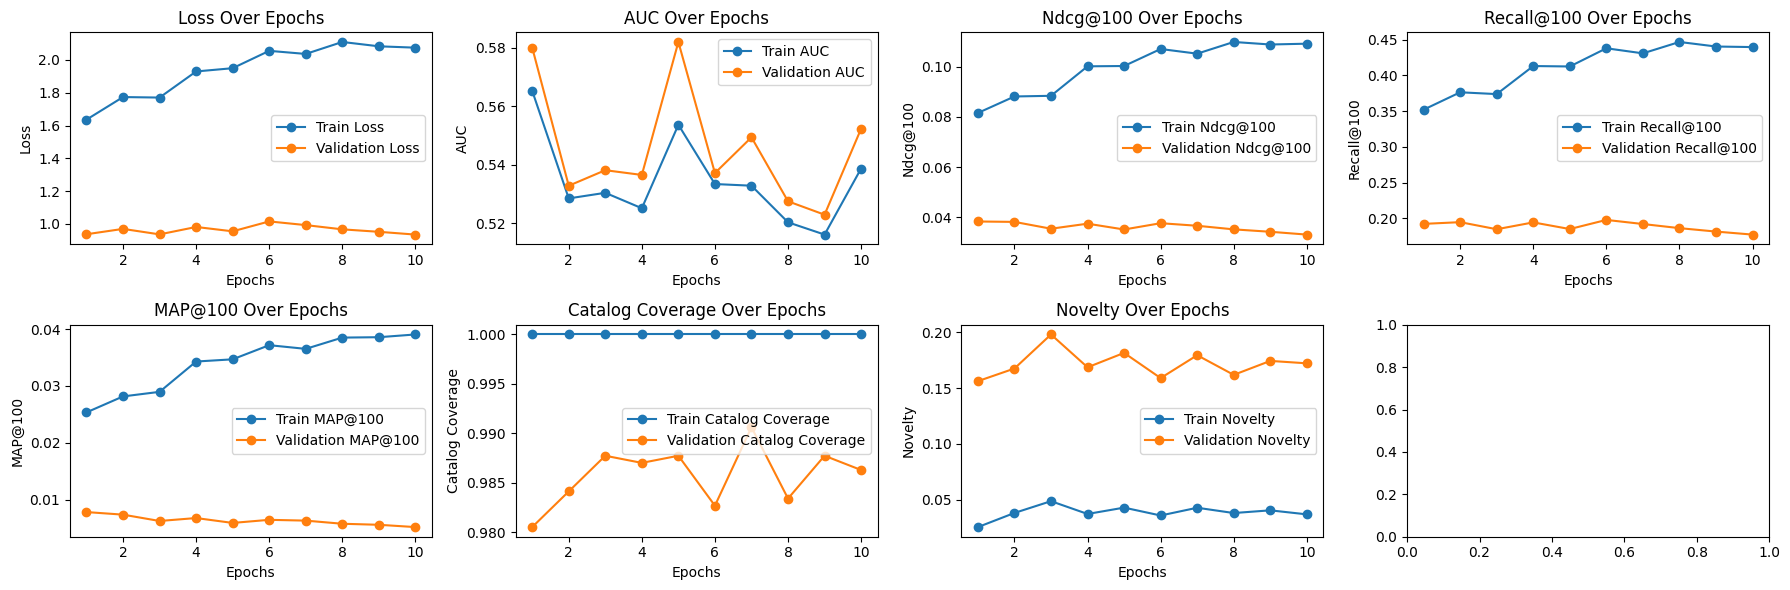

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


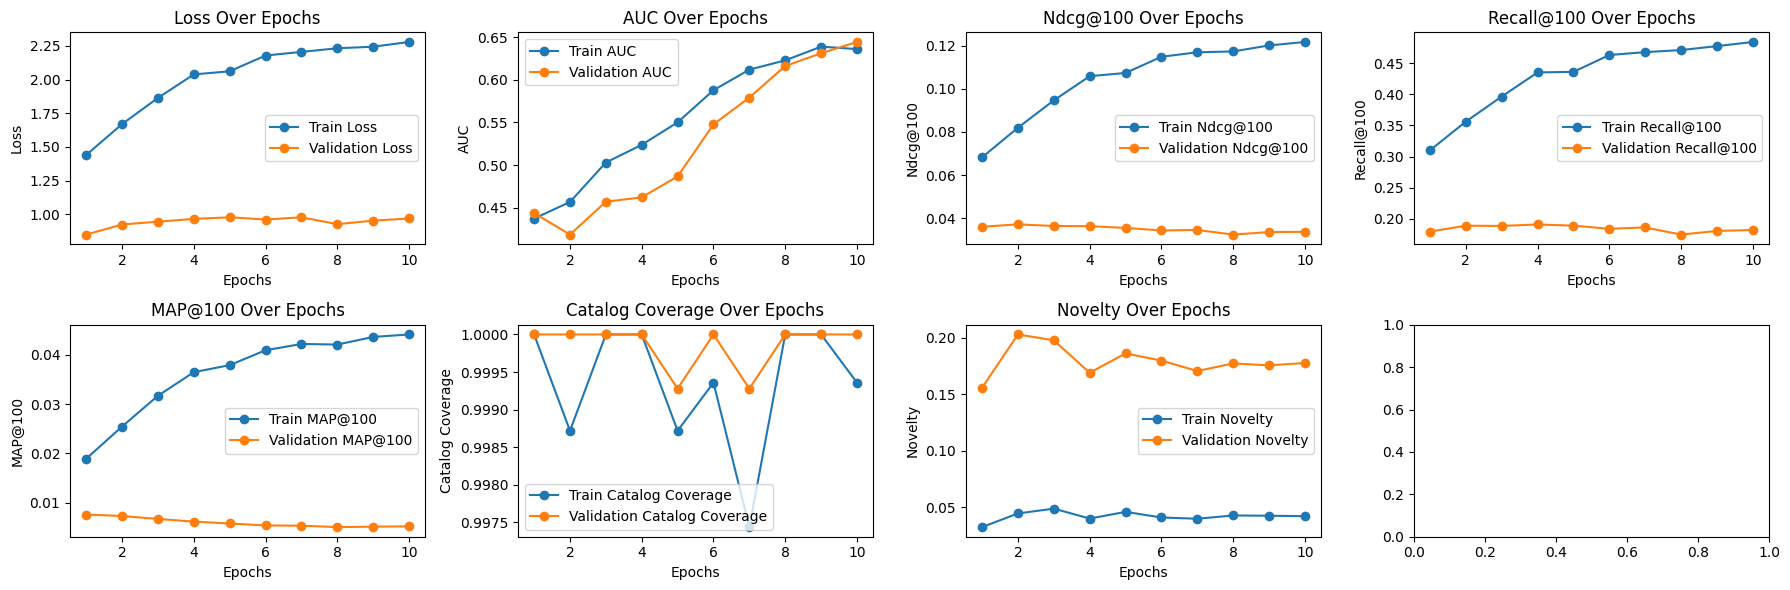

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


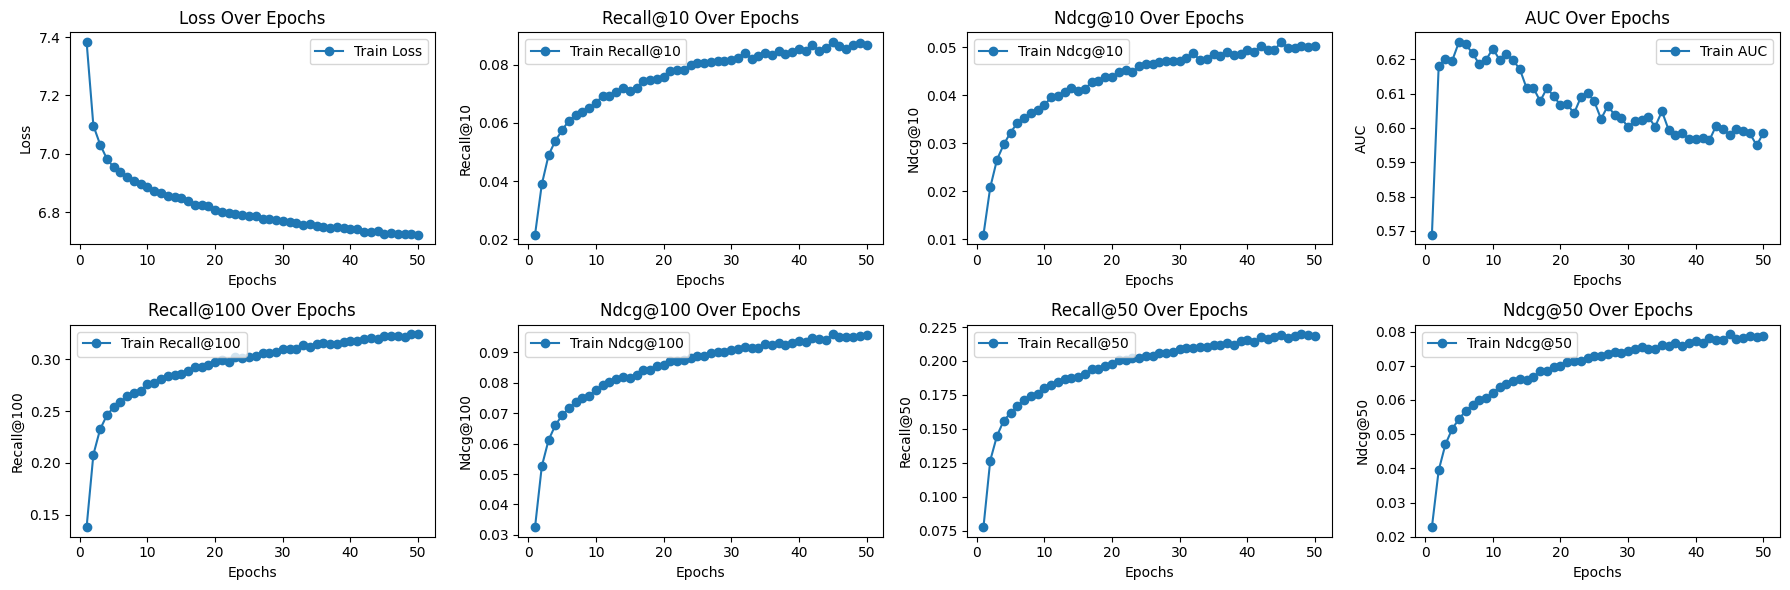

In [ ]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, None, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

### model_v4

In [ ]:
VERSION = 'v4'

_tower_dim = {
    'user':[128, 128],
    'item':[512, 128],
}

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 2 # @param
_validation_freq = 5 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 128
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [ ]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [ ]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block  # needed to initiate the text embeddings
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

KeyboardInterrupt: ignored

#### analysis

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v4


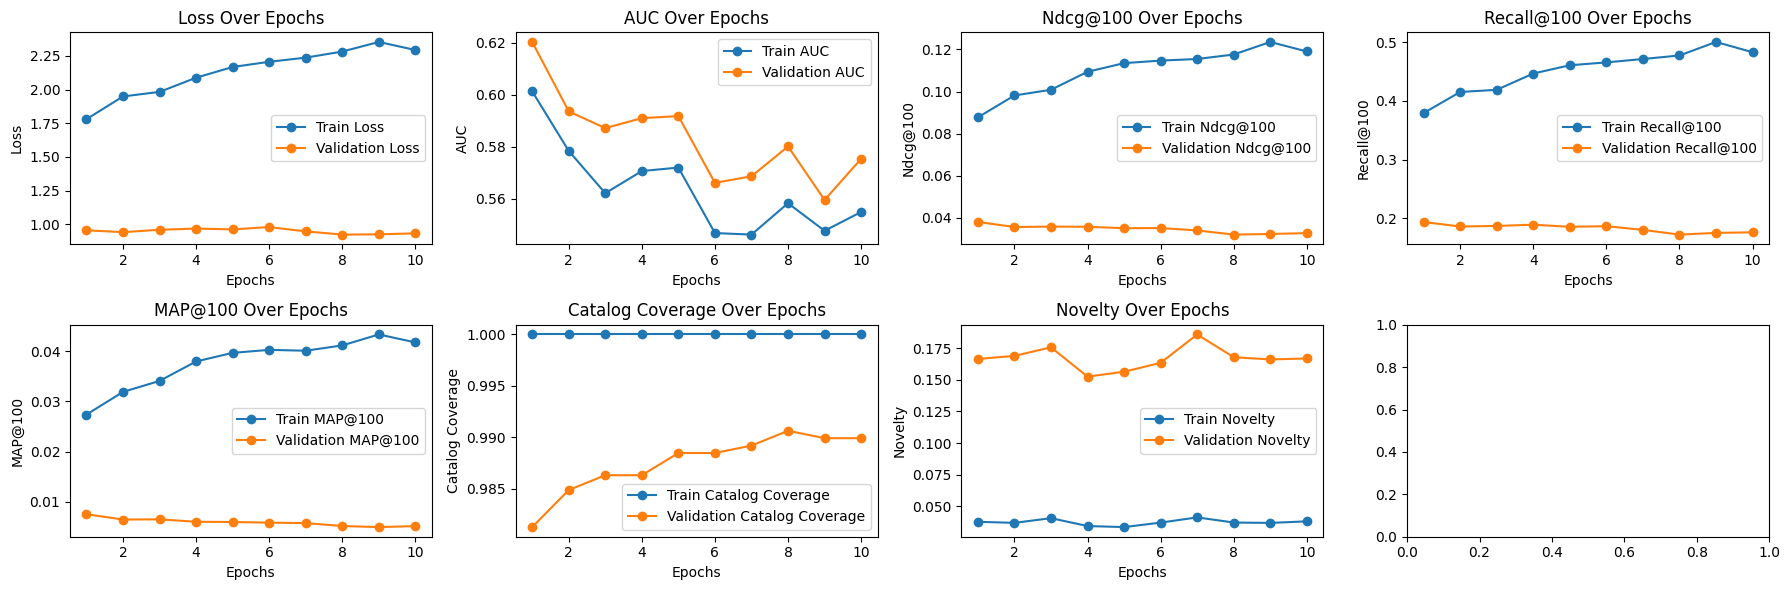

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


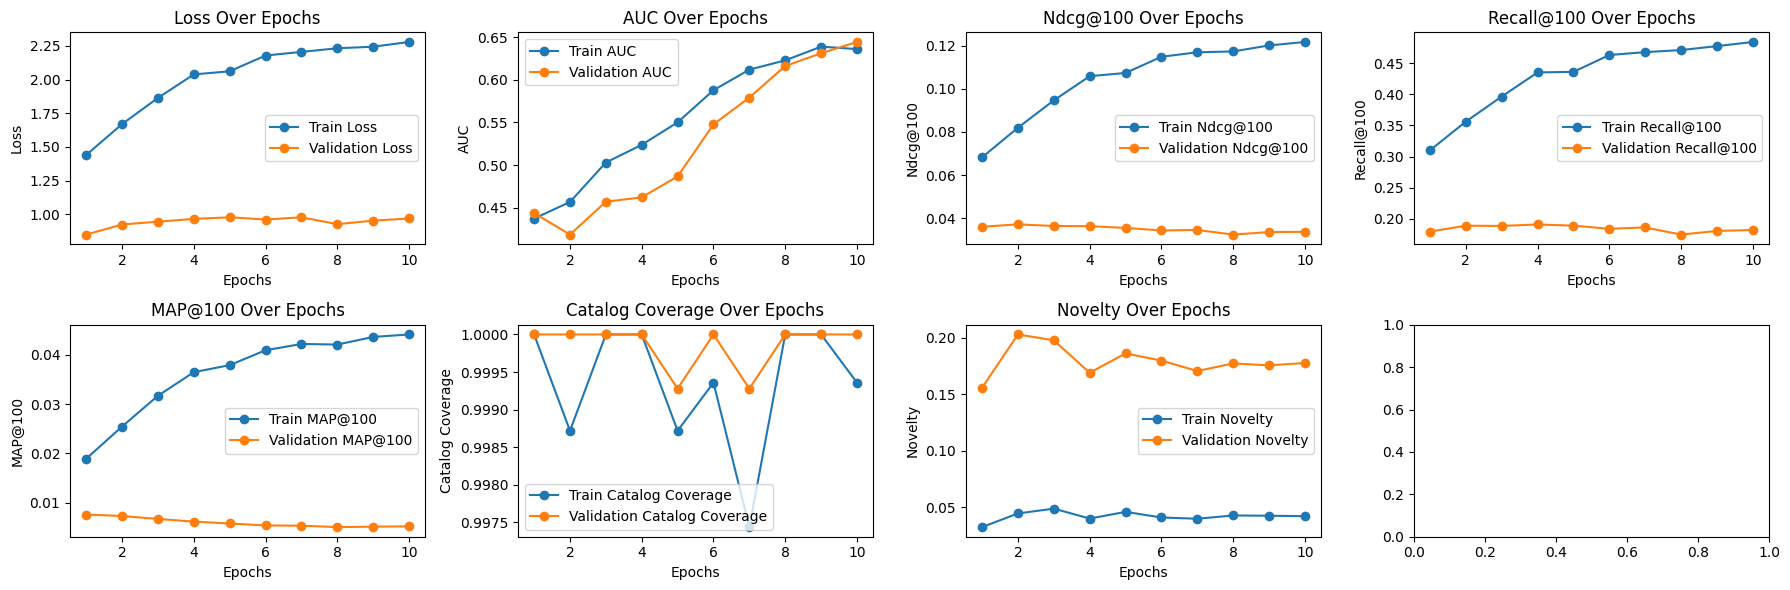

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


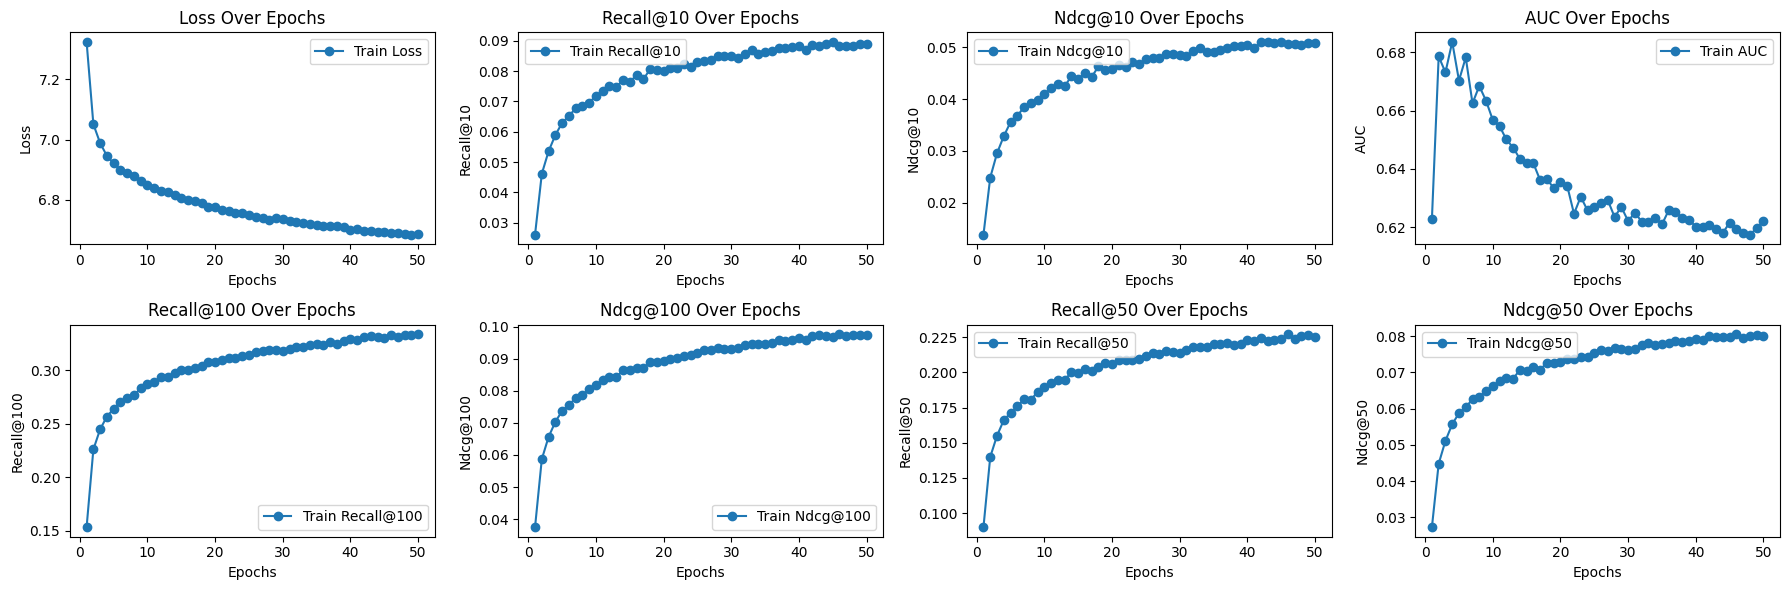

In [ ]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, None, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

### model_v5

In [ ]:
VERSION = 'v5'

_tower_dim = {
    'user':[128, 128],
    'item':[512, 128],
}

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 2 # @param
_validation_freq = 1 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 64
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [ ]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [ ]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block  # needed to initiate the text embeddings
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=50, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=50, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 54s 897ms/step - loss: 7.4665 - auc: 0.5594 - recall_at_100: 0.0795 - mrr_at_100: 0.0059 - ndcg_at_100: 0.0182 - map_at_100: 0.0059 - precision_at_100: 7.9487e-04 - recall_at_50: 0.0412 - mrr_at_50: 0.0054 - ndcg_at_50: 0.0120 - map_at_50: 0.0054 - precision_at_50: 8.2416e-04 - recall_at_10: 0.0103 - mrr_at_10: 0.0041 - ndcg_at_10: 0.0055 - map_at_10: 0.0041 - precision_at_10: 0.0010 - regularization_loss: 0.0000e+00 - loss_batch: 7.3981 - val_loss: 7.3968 - val_auc: 0.5761 - val_recall_at_100: 0.1279 - val_mrr_at_100: 0.0086 - val_ndcg_at_100: 0.0286 - val_map_at_100: 0.0086 - val_precision_at_100: 0.0013 - val_recall_at_50: 0.0704 - val_mrr_at_50: 0.0078 - val_ndcg_at_50: 0.0194 - val_map_at_50: 0.0078 - val_precision_at_50: 0.0014 - val_recall_at_10: 0.0166 - val_mrr_at_10: 0.0057 - val_ndcg_at_10: 0.0082 - val_map_at_10: 0.0057 - val_precision_at_10: 0.0017 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 6.3121
Epoch 2/50


69/69 [==============================] - 6s 19ms/step - loss: 2.1068 - auc: 0.5766 - recall_at_100: 0.4470 - mrr_at_100: 0.0371 - ndcg_at_100: 0.1086 - map_at_100: 0.0371 - precision_at_100: 0.0045 - recall_at_10: 0.0812 - mrr_at_10: 0.0262 - ndcg_at_10: 0.0388 - map_at_10: 0.0262 - precision_at_10: 0.0081 - regularization_loss: 0.0000e+00 - loss_batch: 2.1184
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.1068129539489746, 'auc': 0.5766170024871826, 'recall_at_100': 0.4495171010494232, 'mrr_at_100': 0.038073763251304626, 'ndcg_at_100': 0.10980609059333801, 'map_at_100': 0.038073763251304626, 'precision_at_100': 0.004495170898735523, 'recall_at_10': 0.08333095908164978, 'mrr_at_10': 0.027193885296583176, 'ndcg_at_10': 0.0400838740170002, 'map_at_10': 0.027193885296583176, 'precision_at_10': 0.008333097212016582, 'regularization_loss': 0.0, 'loss_batch': 2.6677067279815674, 'coverage': 0.9993593850096092, 'novelty': 0.03520890116865175}
Candidate set rows: 1387


15/15 [==============================] - 3s 24ms/step - loss: 0.9666 - auc: 0.5941 - recall_at_100: 0.1810 - mrr_at_100: 0.0058 - ndcg_at_100: 0.0343 - map_at_100: 0.0058 - precision_at_100: 0.0018 - recall_at_10: 0.0081 - mrr_at_10: 0.0017 - ndcg_at_10: 0.0032 - map_at_10: 0.0017 - precision_at_10: 8.0526e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0119
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.966554582118988, 'auc': 0.5941396951675415, 'recall_at_100': 0.1884445697069168, 'mrr_at_100': 0.006069611757993698, 'ndcg_at_100': 0.035677142441272736, 'map_at_100': 0.006069611757993698, 'precision_at_100': 0.001884445664472878, 'recall_at_10': 0.008626454509794712, 'mrr_at_10': 0.001811136375181377, 'ndcg_at_10': 0.0033431858755648136, 'map_at_10': 0.001811136375181377, 'precision_at_10': 0.0008626453927718103, 'regularization_loss': 0.0, 'loss_batch': 1.4864853620529175, 'coverage': 0.9956741167988464, 'novelty': 0.15706195869420386}
35/35 [===========

#### analysis

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

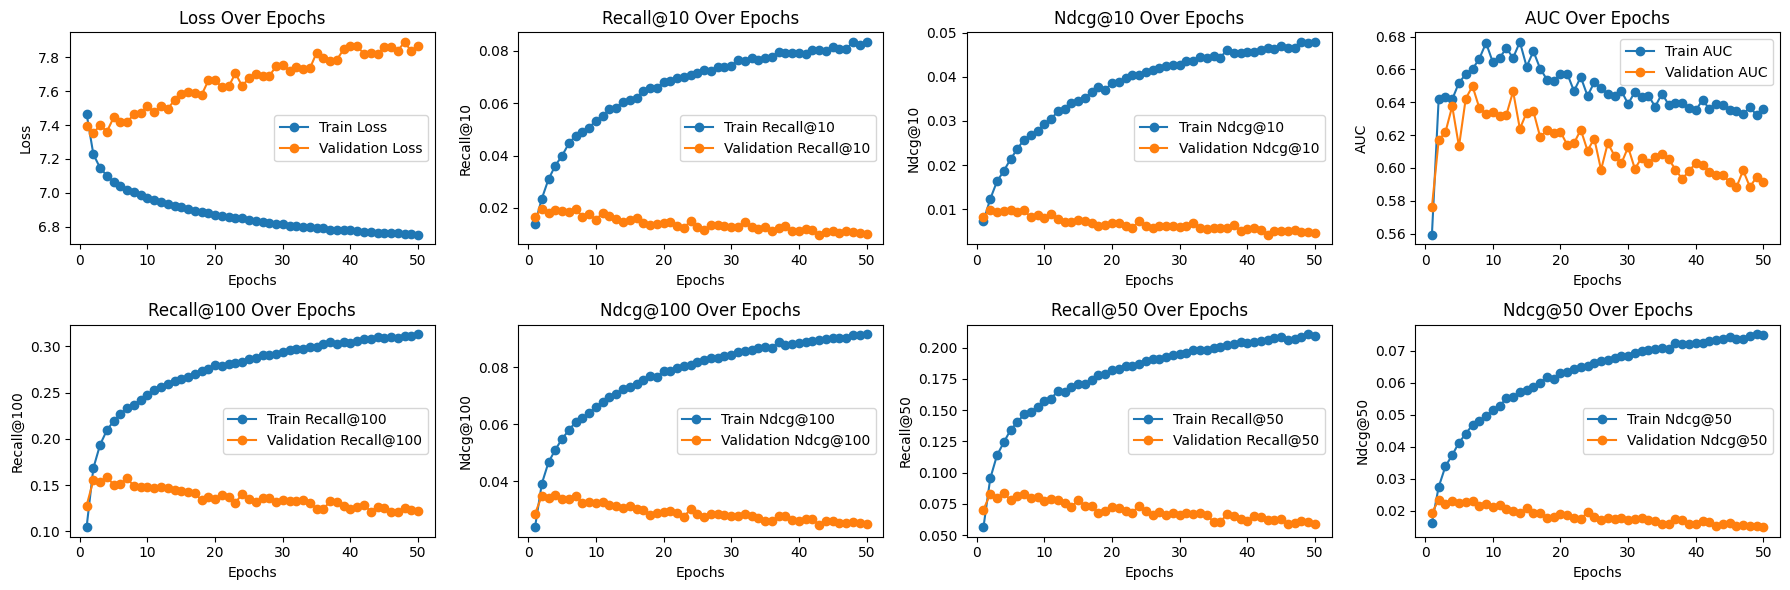

In [ ]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

Plot for model v5


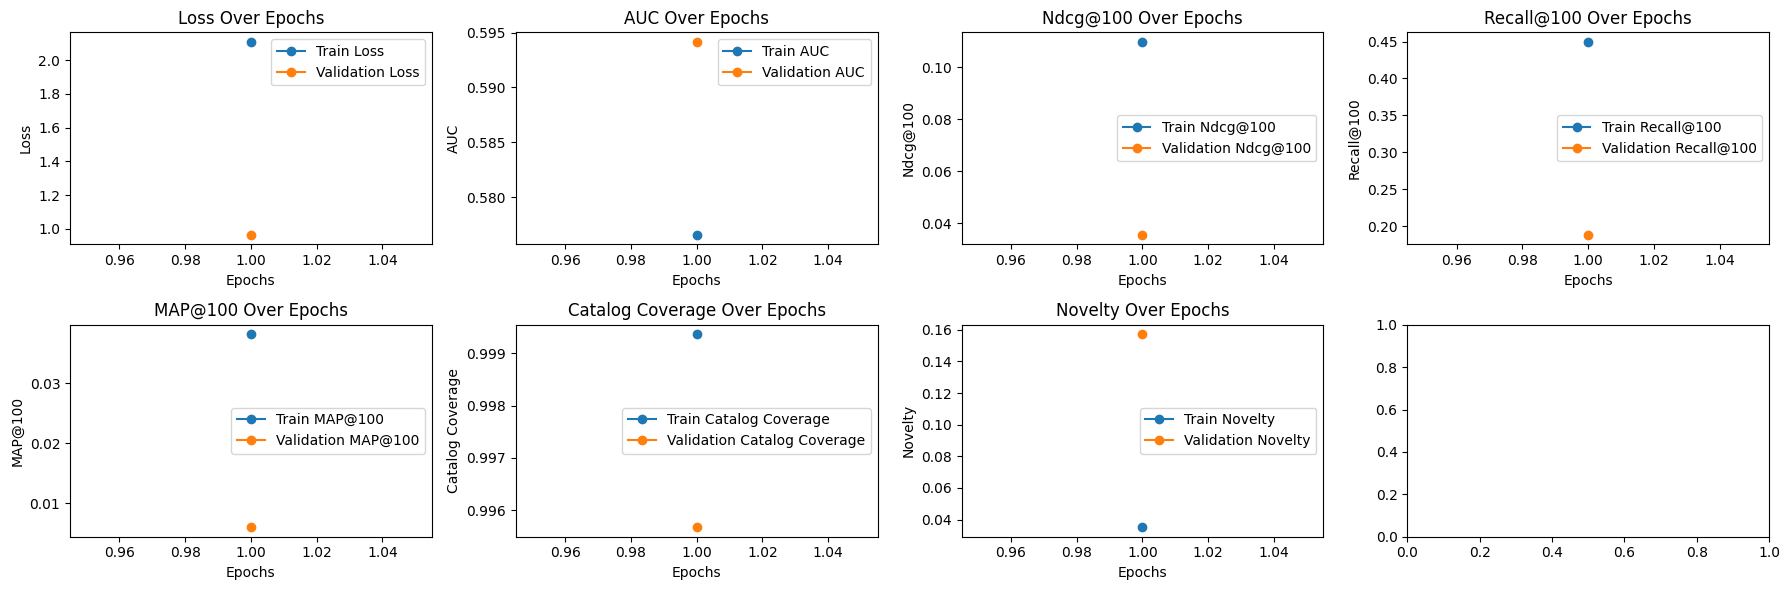

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


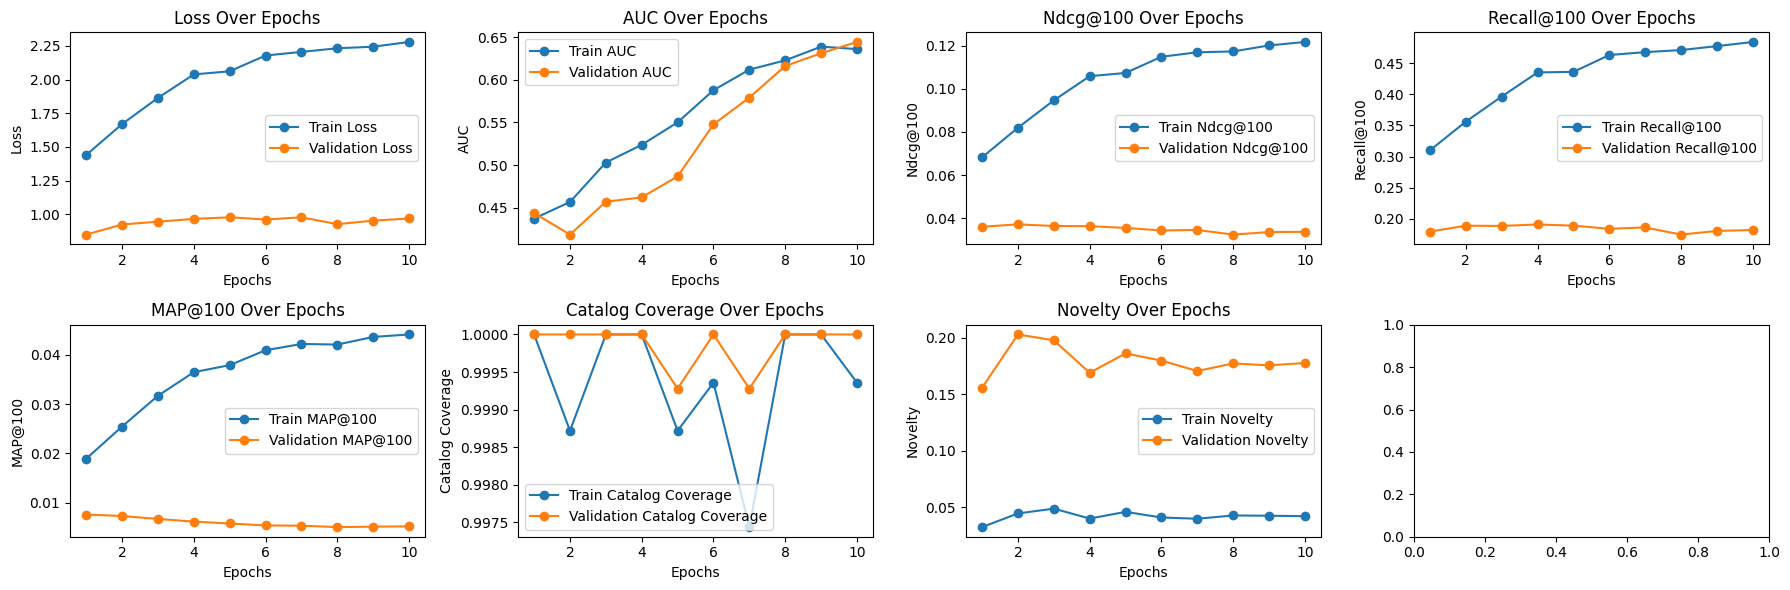

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


### model_v6

In [ ]:
VERSION = 'v6'

_tower_dim = {
    'user':[128, 128],
    'item':[512, 128],
}

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 2 # @param
_validation_freq = 1 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 96
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [ ]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [ ]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block  # needed to initiate the text embeddings
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=25, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=25, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 50s 761ms/step - loss: 7.4767 - auc: 0.5879 - recall_at_100: 0.0814 - mrr_at_100: 0.0056 - ndcg_at_100: 0.0182 - map_at_100: 0.0056 - precision_at_100: 8.1389e-04 - recall_at_50: 0.0426 - mrr_at_50: 0.0050 - ndcg_at_50: 0.0120 - map_at_50: 0.0050 - precision_at_50: 8.5292e-04 - recall_at_10: 0.0095 - mrr_at_10: 0.0037 - ndcg_at_10: 0.0051 - map_at_10: 0.0037 - precision_at_10: 9.4762e-04 - regularization_loss: 0.0000e+00 - loss_batch: 7.4085 - val_loss: 7.3972 - val_auc: 0.6373 - val_recall_at_100: 0.1267 - val_mrr_at_100: 0.0085 - val_ndcg_at_100: 0.0284 - val_map_at_100: 0.0085 - val_precision_at_100: 0.0013 - val_recall_at_50: 0.0685 - val_mrr_at_50: 0.0077 - val_ndcg_at_50: 0.0190 - val_map_at_50: 0.0077 - val_precision_at_50: 0.0014 - val_recall_at_10: 0.0151 - val_mrr_at_10: 0.0056 - val_ndcg_at_10: 0.0078 - val_map_at_10: 0.0056 - val_precision_at_10: 0.0015 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 6.2303
Epoch 2

69/69 [==============================] - 6s 21ms/step - loss: 1.9048 - auc: 0.5216 - recall_at_100: 0.4059 - mrr_at_100: 0.0332 - ndcg_at_100: 0.0979 - map_at_100: 0.0332 - precision_at_100: 0.0041 - recall_at_10: 0.0705 - mrr_at_10: 0.0234 - ndcg_at_10: 0.0342 - map_at_10: 0.0234 - precision_at_10: 0.0071 - regularization_loss: 0.0000e+00 - loss_batch: 1.9150
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9048019647598267, 'auc': 0.5215737223625183, 'recall_at_100': 0.40772342681884766, 'mrr_at_100': 0.03326280787587166, 'ndcg_at_100': 0.09825717657804489, 'map_at_100': 0.03326280787587166, 'precision_at_100': 0.0040772343054413795, 'recall_at_10': 0.07173585146665573, 'mrr_at_10': 0.023418264463543892, 'ndcg_at_10': 0.034513235092163086, 'map_at_10': 0.023418264463543892, 'precision_at_10': 0.007173583842813969, 'regularization_loss': 0.0, 'loss_batch': 2.398939609527588, 'coverage': 0.9993593850096092, 'novelty': 0.03527475404930236}
Candidate set rows: 1387


15/15 [==============================] - 5s 24ms/step - loss: 0.9859 - auc: 0.5070 - recall_at_100: 0.1919 - mrr_at_100: 0.0071 - ndcg_at_100: 0.0372 - map_at_100: 0.0071 - precision_at_100: 0.0019 - recall_at_10: 0.0127 - mrr_at_10: 0.0029 - ndcg_at_10: 0.0051 - map_at_10: 0.0029 - precision_at_10: 0.0013 - regularization_loss: 0.0000e+00 - loss_batch: 1.0296
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.985910952091217, 'auc': 0.5070129036903381, 'recall_at_100': 0.1968035250902176, 'mrr_at_100': 0.007466100621968508, 'ndcg_at_100': 0.03845718875527382, 'map_at_100': 0.007466100621968508, 'precision_at_100': 0.00196803524158895, 'recall_at_10': 0.013374348171055317, 'mrr_at_10': 0.0030666000675410032, 'ndcg_at_10': 0.0054024686105549335, 'map_at_10': 0.0030666000675410032, 'precision_at_10': 0.0013374347472563386, 'regularization_loss': 0.0, 'loss_batch': 1.486833930015564, 'coverage': 0.9956741167988464, 'novelty': 0.15343312723722746}
35/35 [================

69/69 [==============================] - 6s 21ms/step - loss: 2.1281 - auc: 0.5320 - recall_at_100: 0.4485 - mrr_at_100: 0.0365 - ndcg_at_100: 0.1081 - map_at_100: 0.0365 - precision_at_100: 0.0045 - recall_at_10: 0.0798 - mrr_at_10: 0.0256 - ndcg_at_10: 0.0381 - map_at_10: 0.0256 - precision_at_10: 0.0080 - regularization_loss: 0.0000e+00 - loss_batch: 2.1443
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.1281418800354004, 'auc': 0.5319961905479431, 'recall_at_100': 0.4489615559577942, 'mrr_at_100': 0.03713157773017883, 'ndcg_at_100': 0.10873929411172867, 'map_at_100': 0.03713157773017883, 'precision_at_100': 0.004489616025239229, 'recall_at_10': 0.08065297454595566, 'mrr_at_10': 0.02628828026354313, 'ndcg_at_10': 0.03877876326441765, 'map_at_10': 0.02628828026354313, 'precision_at_10': 0.008065295405685902, 'regularization_loss': 0.0, 'loss_batch': 2.9119882583618164, 'coverage': 1.0, 'novelty': 0.04213207041372532}
Candidate set rows: 1387


15/15 [==============================] - 3s 24ms/step - loss: 0.9392 - auc: 0.5026 - recall_at_100: 0.1795 - mrr_at_100: 0.0055 - ndcg_at_100: 0.0336 - map_at_100: 0.0055 - precision_at_100: 0.0018 - recall_at_10: 0.0082 - mrr_at_10: 0.0016 - ndcg_at_10: 0.0031 - map_at_10: 0.0016 - precision_at_10: 8.1533e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9880
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9392232298851013, 'auc': 0.502617597579956, 'recall_at_100': 0.18055370450019836, 'mrr_at_100': 0.005777575541287661, 'ndcg_at_100': 0.03403248265385628, 'map_at_100': 0.005777575541287661, 'precision_at_100': 0.001805537031032145, 'recall_at_10': 0.008158352226018906, 'mrr_at_10': 0.0018160984618589282, 'ndcg_at_10': 0.0032439299393445253, 'map_at_10': 0.0018160984618589282, 'precision_at_10': 0.0008158351993188262, 'regularization_loss': 0.0, 'loss_batch': 1.4982693195343018, 'coverage': 0.9913482335976929, 'novelty': 0.17176684881602916}
35/35 [=========

#### analysis

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

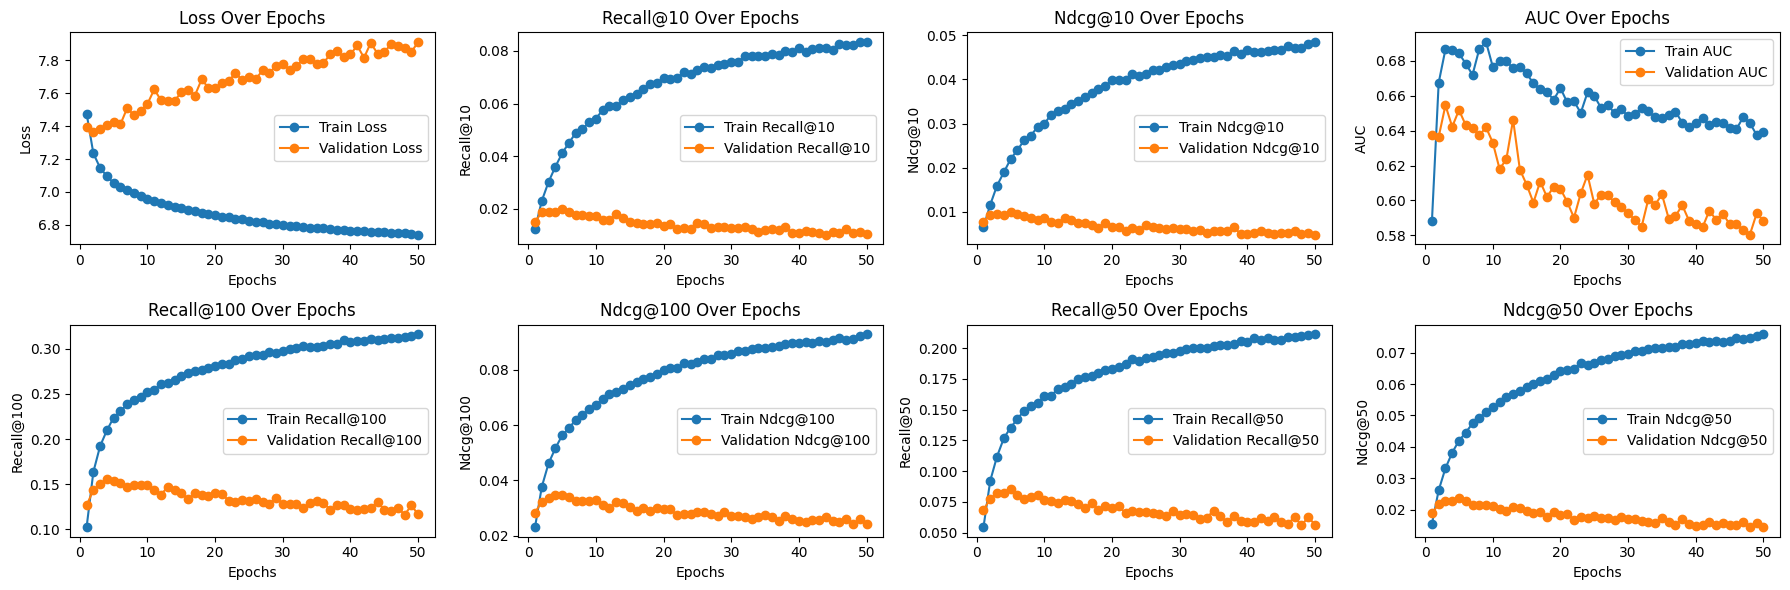

In [ ]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

Plot for model v6


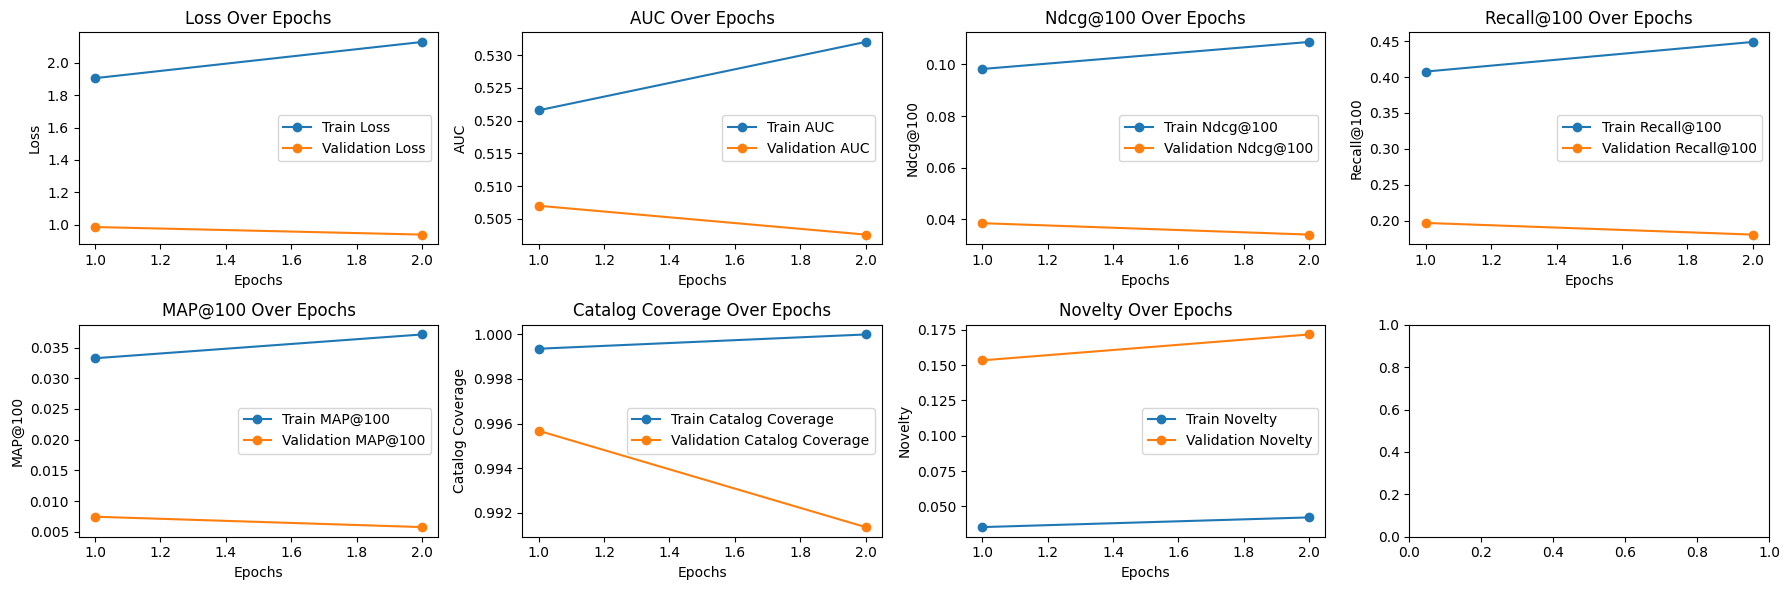

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


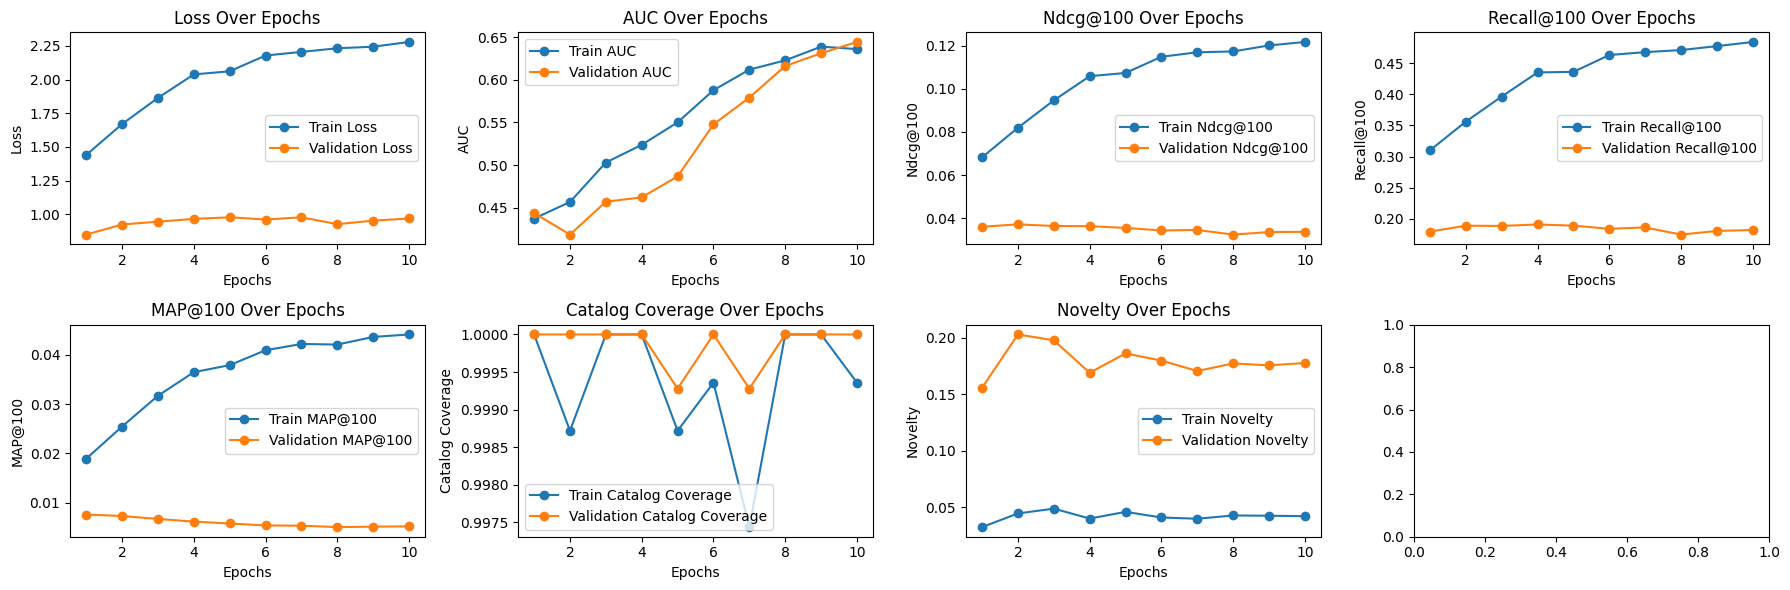

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


### model_v7

In [ ]:
VERSION = 'v7'

_tower_dim = {
    'user':[128, 128],
    'item':[512, 128],
}

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 4 # @param
_validation_freq = 1 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 96
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [ ]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [ ]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block  # needed to initiate the text embeddings
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=25, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=25, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 34s 598ms/step - loss: 7.3890 - auc: 0.6262 - recall_at_100: 0.1025 - mrr_at_100: 0.0078 - ndcg_at_100: 0.0238 - map_at_100: 0.0078 - precision_at_100: 0.0010 - recall_at_50: 0.0570 - mrr_at_50: 0.0072 - ndcg_at_50: 0.0165 - map_at_50: 0.0072 - precision_at_50: 0.0011 - recall_at_10: 0.0152 - mrr_at_10: 0.0055 - ndcg_at_10: 0.0077 - map_at_10: 0.0055 - precision_at_10: 0.0015 - regularization_loss: 0.0000e+00 - loss_batch: 7.3161 - val_loss: 7.4203 - val_auc: 0.6366 - val_recall_at_100: 0.1420 - val_mrr_at_100: 0.0103 - val_ndcg_at_100: 0.0325 - val_map_at_100: 0.0103 - val_precision_at_100: 0.0014 - val_recall_at_50: 0.0774 - val_mrr_at_50: 0.0095 - val_ndcg_at_50: 0.0221 - val_map_at_50: 0.0095 - val_precision_at_50: 0.0015 - val_recall_at_10: 0.0192 - val_mrr_at_10: 0.0072 - val_ndcg_at_10: 0.0099 - val_map_at_10: 0.0072 - val_precision_at_10: 0.0019 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 6.4380
Epoch 2/50
35/35 [=

69/69 [==============================] - 8s 33ms/step - loss: 2.0681 - auc: 0.5559 - recall_at_100: 0.4359 - mrr_at_100: 0.0354 - ndcg_at_100: 0.1049 - map_at_100: 0.0354 - precision_at_100: 0.0044 - recall_at_10: 0.0766 - mrr_at_10: 0.0248 - ndcg_at_10: 0.0367 - map_at_10: 0.0248 - precision_at_10: 0.0077 - regularization_loss: 0.0000e+00 - loss_batch: 2.0821
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.0681447982788086, 'auc': 0.5558827519416809, 'recall_at_100': 0.4371670186519623, 'mrr_at_100': 0.03603952378034592, 'ndcg_at_100': 0.10579080879688263, 'map_at_100': 0.03603952378034592, 'precision_at_100': 0.004371669143438339, 'recall_at_10': 0.0784023255109787, 'mrr_at_10': 0.02545853704214096, 'ndcg_at_10': 0.03761468082666397, 'map_at_10': 0.02545853704214096, 'precision_at_10': 0.007840231992304325, 'regularization_loss': 0.0, 'loss_batch': 2.7454965114593506, 'coverage': 1.0, 'novelty': 0.04030258996495427}
Candidate set rows: 1387


15/15 [==============================] - 3s 23ms/step - loss: 0.9108 - auc: 0.5411 - recall_at_100: 0.1737 - mrr_at_100: 0.0059 - ndcg_at_100: 0.0332 - map_at_100: 0.0059 - precision_at_100: 0.0017 - recall_at_10: 0.0093 - mrr_at_10: 0.0020 - ndcg_at_10: 0.0036 - map_at_10: 0.0020 - precision_at_10: 9.3444e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9575
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9108282923698425, 'auc': 0.5411443114280701, 'recall_at_100': 0.1776782125234604, 'mrr_at_100': 0.006056155543774366, 'ndcg_at_100': 0.03395234793424606, 'map_at_100': 0.006056155543774366, 'precision_at_100': 0.0017767819808796048, 'recall_at_10': 0.008626454509794712, 'mrr_at_10': 0.002021410735324025, 'ndcg_at_10': 0.003504042513668537, 'map_at_10': 0.002021410735324025, 'precision_at_10': 0.0008626453927718103, 'regularization_loss': 0.0, 'loss_batch': 1.4450300931930542, 'coverage': 0.9942321557317952, 'novelty': 0.17430683918669132}
35/35 [===========

69/69 [==============================] - 7s 31ms/step - loss: 2.2361 - auc: 0.5507 - recall_at_100: 0.4746 - mrr_at_100: 0.0410 - ndcg_at_100: 0.1172 - map_at_100: 0.0410 - precision_at_100: 0.0047 - recall_at_10: 0.0915 - mrr_at_10: 0.0293 - ndcg_at_10: 0.0436 - map_at_10: 0.0293 - precision_at_10: 0.0091 - regularization_loss: 0.0000e+00 - loss_batch: 2.2497
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.2361438274383545, 'auc': 0.5507199168205261, 'recall_at_100': 0.4766530990600586, 'mrr_at_100': 0.0414174385368824, 'ndcg_at_100': 0.11782288551330566, 'map_at_100': 0.0414174385368824, 'precision_at_100': 0.0047665308229625225, 'recall_at_10': 0.0929318219423294, 'mrr_at_10': 0.029711147770285606, 'ndcg_at_10': 0.044227562844753265, 'map_at_10': 0.029711147770285606, 'precision_at_10': 0.009293180890381336, 'regularization_loss': 0.0, 'loss_batch': 2.8918569087982178, 'coverage': 1.0, 'novelty': 0.039099427813251514}
Candidate set rows: 1387


15/15 [==============================] - 3s 22ms/step - loss: 0.9538 - auc: 0.5505 - recall_at_100: 0.1810 - mrr_at_100: 0.0053 - ndcg_at_100: 0.0336 - map_at_100: 0.0053 - precision_at_100: 0.0018 - recall_at_10: 0.0066 - mrr_at_10: 0.0013 - ndcg_at_10: 0.0025 - map_at_10: 0.0013 - precision_at_10: 6.6218e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0026
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9537833333015442, 'auc': 0.5505001544952393, 'recall_at_100': 0.1838304102420807, 'mrr_at_100': 0.005576143506914377, 'ndcg_at_100': 0.03440597280859947, 'map_at_100': 0.005576143506914377, 'precision_at_100': 0.0018383041024208069, 'recall_at_10': 0.007556506432592869, 'mrr_at_10': 0.0014721071347594261, 'ndcg_at_10': 0.0028298208490014076, 'map_at_10': 0.0014721071347594261, 'precision_at_10': 0.0007556507480330765, 'regularization_loss': 0.0, 'loss_batch': 1.5128562450408936, 'coverage': 0.989185291997116, 'novelty': 0.16643134486410166}
35/35 [=========

#### analysis

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

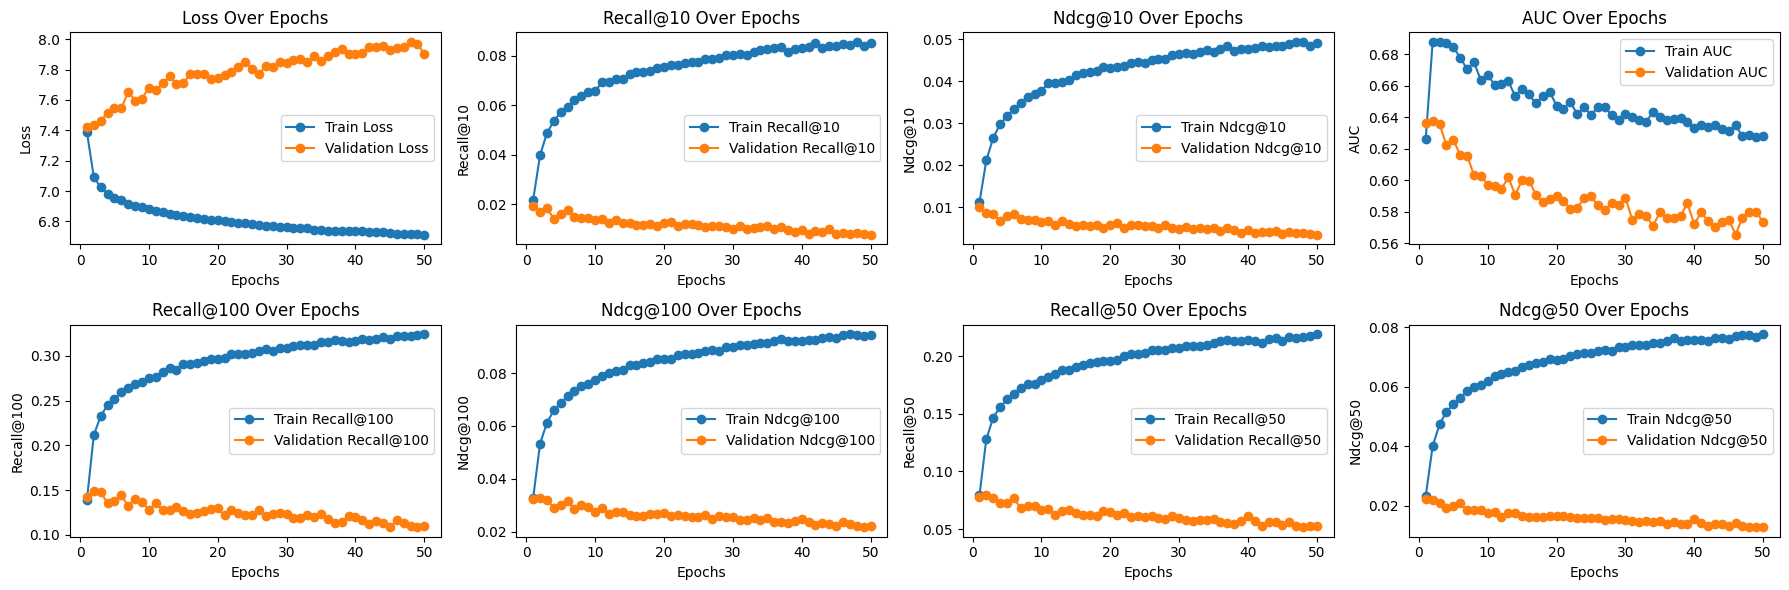

In [ ]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

Plot for model v7


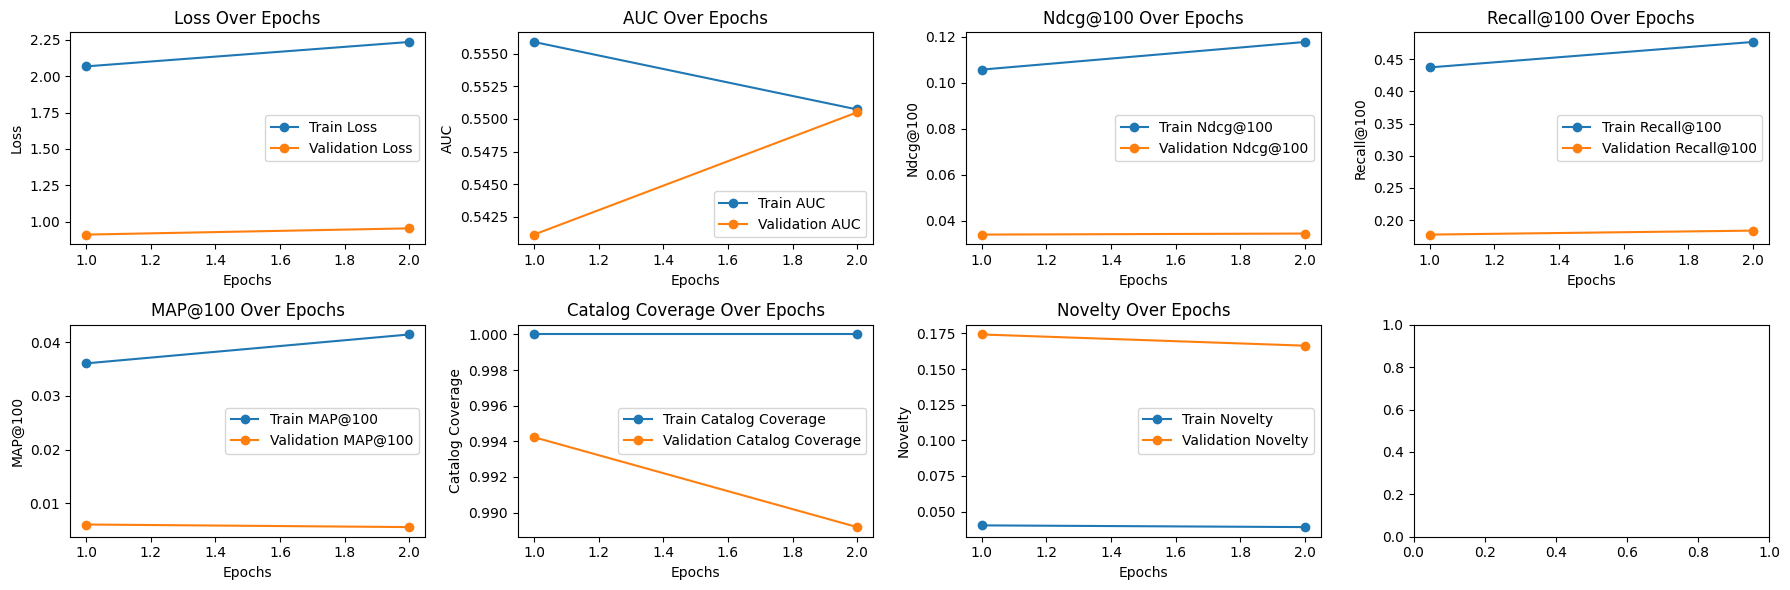

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


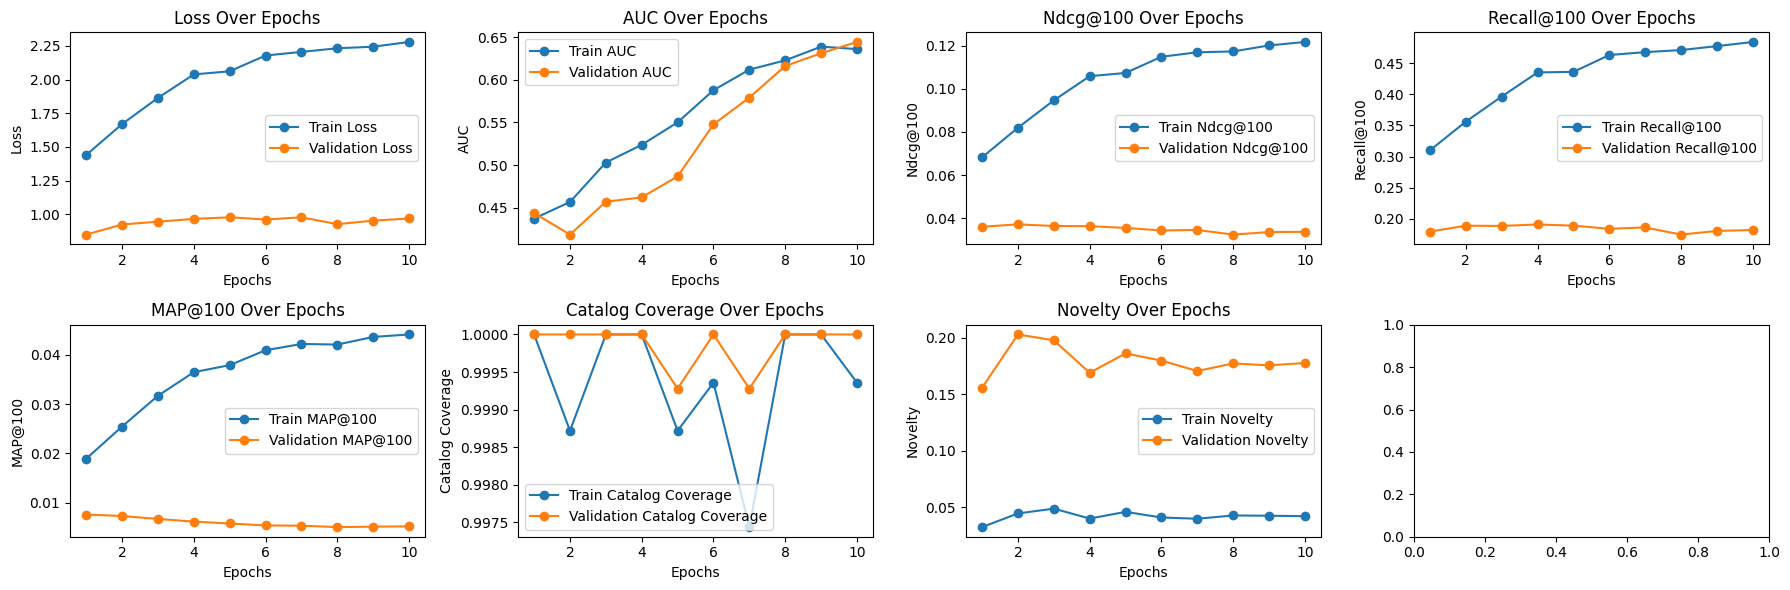

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


### model_v8

In [ ]:
VERSION = 'v8'

_tower_dim = {
    'user':[128, 128],
    'item':[512, 128],
}

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 4 # @param
_validation_freq = 1 # @param
# _loss = 'categorical_crossentropy' # @param
_loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 96
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [ ]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

RuntimeError: ignored

In [ ]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block  # needed to initiate the text embeddings
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=25, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=25, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 43s 821ms/step - loss: 8.4130 - auc: 0.5860 - recall_at_100: 0.0877 - mrr_at_100: 0.0065 - ndcg_at_100: 0.0202 - map_at_100: 0.0065 - precision_at_100: 8.7733e-04 - recall_at_50: 0.0475 - mrr_at_50: 0.0059 - ndcg_at_50: 0.0137 - map_at_50: 0.0059 - precision_at_50: 9.4910e-04 - recall_at_10: 0.0126 - mrr_at_10: 0.0045 - ndcg_at_10: 0.0064 - map_at_10: 0.0045 - precision_at_10: 0.0013 - regularization_loss: 0.0000e+00 - loss_batch: 8.3533 - val_loss: 8.3484 - val_auc: 0.6174 - val_recall_at_100: 0.1341 - val_mrr_at_100: 0.0087 - val_ndcg_at_100: 0.0297 - val_map_at_100: 0.0087 - val_precision_at_100: 0.0013 - val_recall_at_50: 0.0705 - val_mrr_at_50: 0.0078 - val_ndcg_at_50: 0.0195 - val_map_at_50: 0.0078 - val_precision_at_50: 0.0014 - val_recall_at_10: 0.0163 - val_mrr_at_10: 0.0057 - val_ndcg_at_10: 0.0081 - val_map_at_10: 0.0057 - val_precision_at_10: 0.0016 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 7.5169
Epoch 2/50


69/69 [==============================] - 7s 31ms/step - loss: 1.7611 - auc: 0.5545 - recall_at_100: 0.3843 - mrr_at_100: 0.0261 - ndcg_at_100: 0.0875 - map_at_100: 0.0261 - precision_at_100: 0.0038 - recall_at_10: 0.0562 - mrr_at_10: 0.0169 - ndcg_at_10: 0.0259 - map_at_10: 0.0169 - precision_at_10: 0.0056 - regularization_loss: 0.0000e+00 - loss_batch: 1.7820
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7610623836517334, 'auc': 0.5544601082801819, 'recall_at_100': 0.384561687707901, 'mrr_at_100': 0.027017852291464806, 'ndcg_at_100': 0.08831297606229782, 'map_at_100': 0.027017852291464806, 'precision_at_100': 0.0038456169422715902, 'recall_at_10': 0.05781886726617813, 'mrr_at_10': 0.017816999927163124, 'ndcg_at_10': 0.026987437158823013, 'map_at_10': 0.017816999927163124, 'precision_at_10': 0.00578188756480813, 'regularization_loss': 0.0, 'loss_batch': 2.7765109539031982, 'coverage': 1.0, 'novelty': 0.04947793693268272}
Candidate set rows: 1387


15/15 [==============================] - 3s 24ms/step - loss: 0.7554 - auc: 0.5156 - recall_at_100: 0.1568 - mrr_at_100: 0.0063 - ndcg_at_100: 0.0309 - map_at_100: 0.0063 - precision_at_100: 0.0016 - recall_at_10: 0.0114 - mrr_at_10: 0.0029 - ndcg_at_10: 0.0048 - map_at_10: 0.0029 - precision_at_10: 0.0011 - regularization_loss: 0.0000e+00 - loss_batch: 0.8050
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.7553708553314209, 'auc': 0.5156096816062927, 'recall_at_100': 0.1624983251094818, 'mrr_at_100': 0.0065779308788478374, 'ndcg_at_100': 0.03217475116252899, 'map_at_100': 0.0065779308788478374, 'precision_at_100': 0.0016249831533059478, 'recall_at_10': 0.011568810790777206, 'mrr_at_10': 0.0029295131098479033, 'ndcg_at_10': 0.0049017248675227165, 'map_at_10': 0.0029295131098479033, 'precision_at_10': 0.0011568812187761068, 'regularization_loss': 0.0, 'loss_batch': 1.3243764638900757, 'coverage': 0.9790915645277577, 'novelty': 0.19915522703273494}
35/35 [==========

69/69 [==============================] - 8s 35ms/step - loss: 1.9409 - auc: 0.5632 - recall_at_100: 0.4218 - mrr_at_100: 0.0286 - ndcg_at_100: 0.0959 - map_at_100: 0.0286 - precision_at_100: 0.0042 - recall_at_10: 0.0603 - mrr_at_10: 0.0185 - ndcg_at_10: 0.0280 - map_at_10: 0.0185 - precision_at_10: 0.0060 - regularization_loss: 0.0000e+00 - loss_batch: 1.9611
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9409030675888062, 'auc': 0.5632296204566956, 'recall_at_100': 0.42369163036346436, 'mrr_at_100': 0.02987181954085827, 'ndcg_at_100': 0.09735949337482452, 'map_at_100': 0.02987181954085827, 'precision_at_100': 0.004236915614455938, 'recall_at_10': 0.0626620352268219, 'mrr_at_10': 0.01968521438539028, 'ndcg_at_10': 0.02953094057738781, 'map_at_10': 0.01968521438539028, 'precision_at_10': 0.006266204174607992, 'regularization_loss': 0.0, 'loss_batch': 2.921396493911743, 'coverage': 1.0, 'novelty': 0.053509618112693634}
Candidate set rows: 1387


15/15 [==============================] - 4s 25ms/step - loss: 0.7050 - auc: 0.5081 - recall_at_100: 0.1476 - mrr_at_100: 0.0053 - ndcg_at_100: 0.0284 - map_at_100: 0.0053 - precision_at_100: 0.0015 - recall_at_10: 0.0091 - mrr_at_10: 0.0022 - ndcg_at_10: 0.0037 - map_at_10: 0.0022 - precision_at_10: 9.1276e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.7514
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.7049569487571716, 'auc': 0.5081170201301575, 'recall_at_100': 0.15126387774944305, 'mrr_at_100': 0.006009244825690985, 'ndcg_at_100': 0.029692817479372025, 'map_at_100': 0.006009244825690985, 'precision_at_100': 0.0015126385260373354, 'recall_at_10': 0.010231376625597477, 'mrr_at_10': 0.0027155231218785048, 'ndcg_at_10': 0.004428751301020384, 'map_at_10': 0.0027155231218785048, 'precision_at_10': 0.0010231377091258764, 'regularization_loss': 0.0, 'loss_batch': 1.2371282577514648, 'coverage': 0.9834174477289113, 'novelty': 0.19447308723448134}
35/35 [=======

#### analysis

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

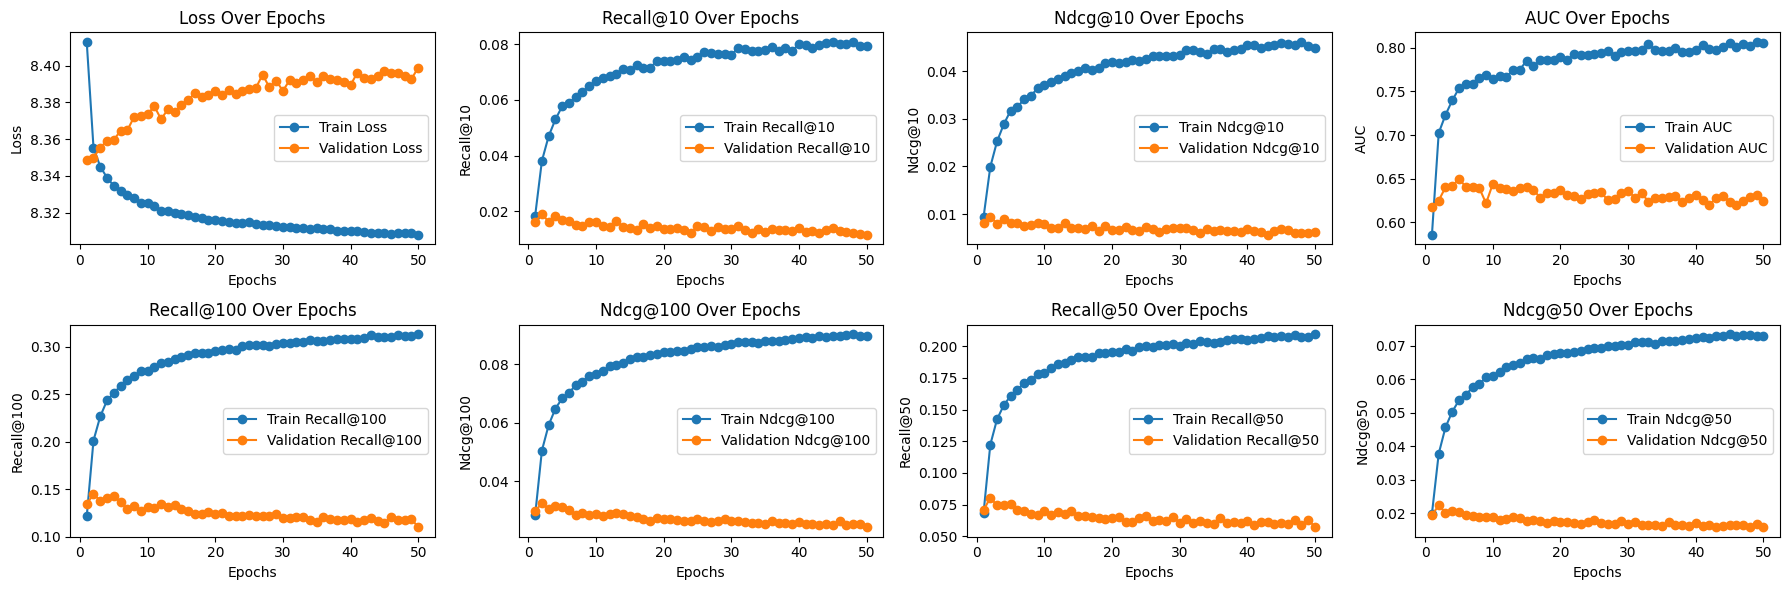

In [ ]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

Plot for model v8


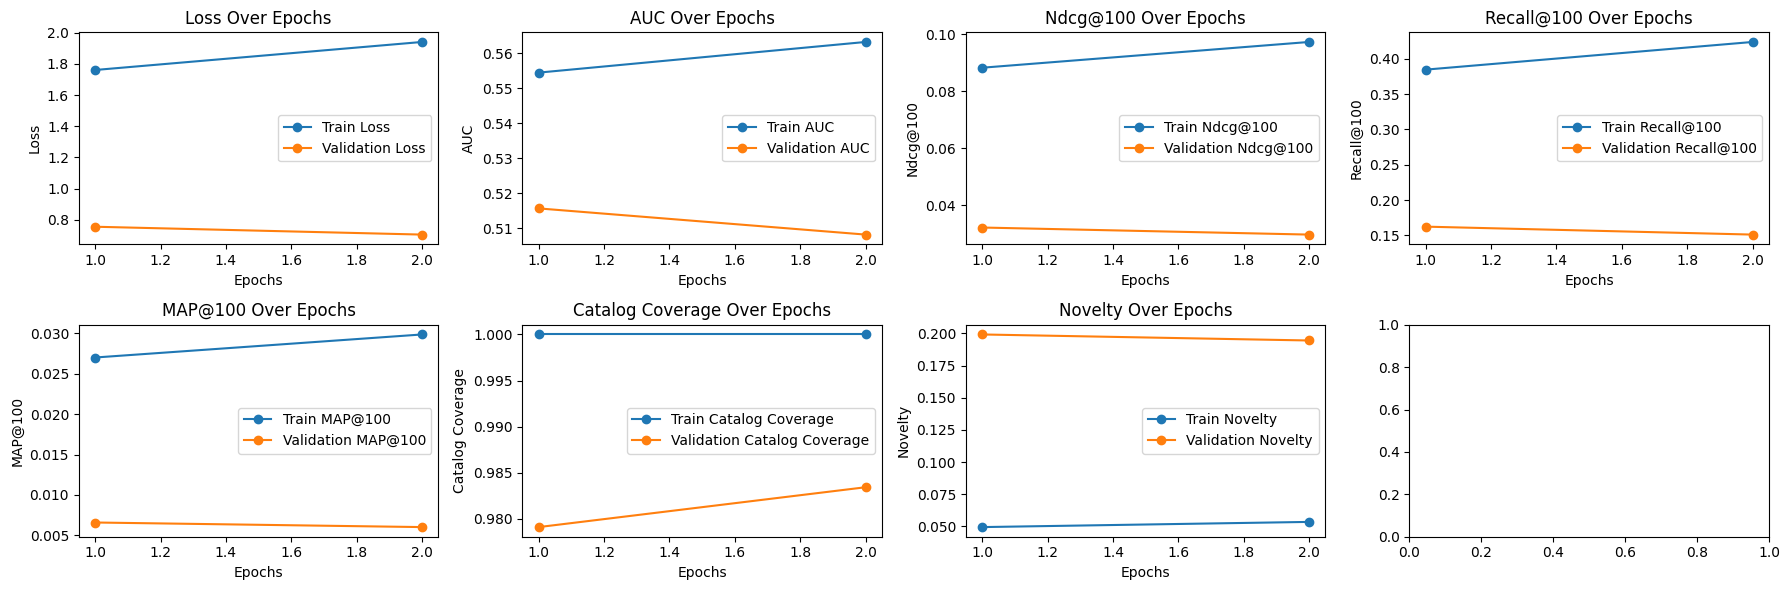

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


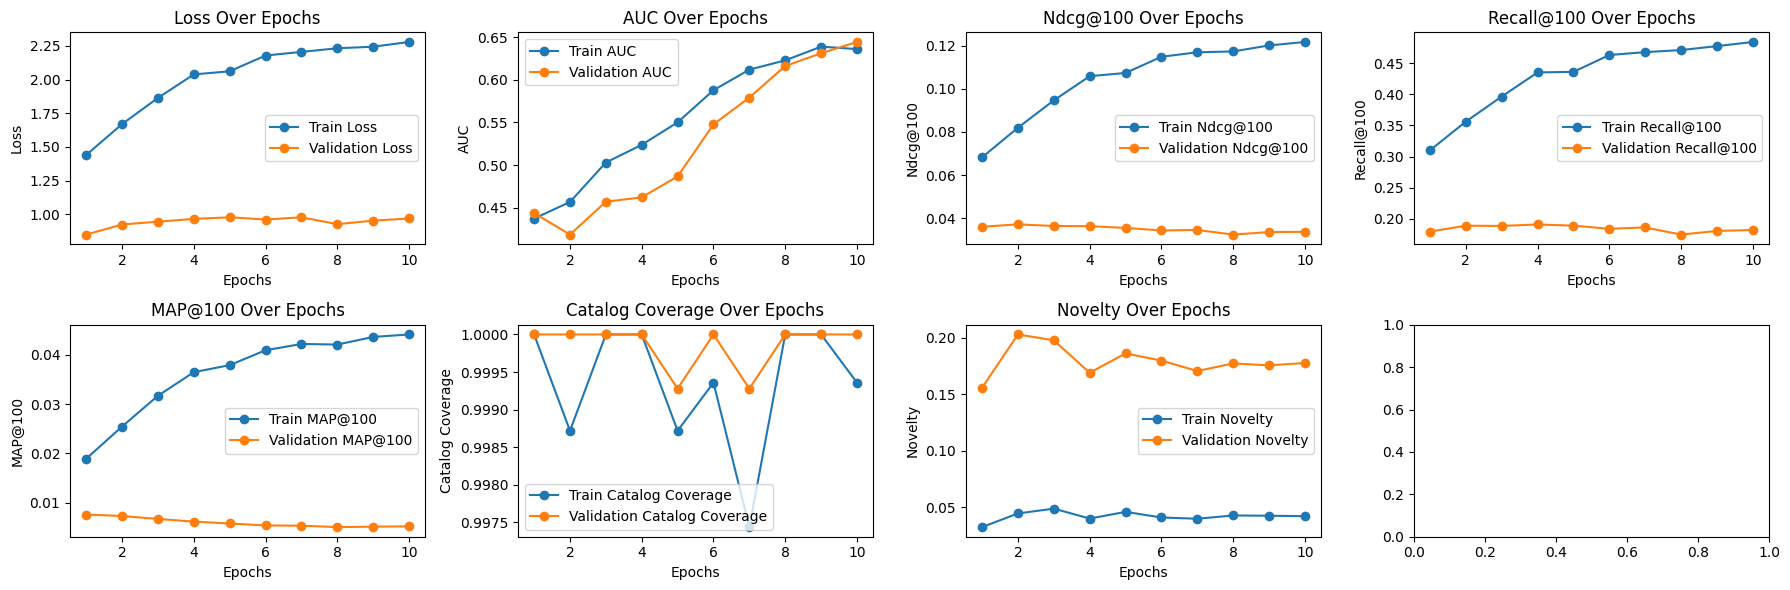

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


### model_v9

In [ ]:
VERSION = 'v9'

_tower_dim = {
    'user':[128, 128],
    'item':[512, 128],
}

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 4 # @param
_validation_freq = 1 # @param
# _loss = 'categorical_crossentropy' # @param
_loss = 'bpr-max' # @param

_logq_sampling_correction = True # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 96
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [ ]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [ ]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block  # needed to initiate the text embeddings
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=25, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=25, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

[INFO] hacked the logq correction to match item cardinality


#### model

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 37s 628ms/step - loss: 9.0814 - auc: 0.5020 - recall_at_100: 0.0516 - mrr_at_100: 0.0032 - ndcg_at_100: 0.0113 - map_at_100: 0.0032 - precision_at_100: 5.1643e-04 - recall_at_50: 0.0259 - mrr_at_50: 0.0029 - ndcg_at_50: 0.0071 - map_at_50: 0.0029 - precision_at_50: 5.1811e-04 - recall_at_10: 0.0056 - mrr_at_10: 0.0021 - ndcg_at_10: 0.0029 - map_at_10: 0.0021 - precision_at_10: 5.6359e-04 - regularization_loss: 0.0000e+00 - loss_batch: 8.9959 - val_loss: 9.1174 - val_auc: 0.4918 - val_recall_at_100: 0.0550 - val_mrr_at_100: 0.0047 - val_ndcg_at_100: 0.0130 - val_map_at_100: 0.0047 - val_precision_at_100: 5.4969e-04 - val_recall_at_50: 0.0280 - val_mrr_at_50: 0.0043 - val_ndcg_at_50: 0.0087 - val_map_at_50: 0.0043 - val_precision_at_50: 5.6039e-04 - val_recall_at_10: 0.0066 - val_mrr_at_10: 0.0035 - val_ndcg_at_10: 0.0042 - val_map_at_10: 0.0035 - val_precision_at_10: 6.6203e-04 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 8.

69/69 [==============================] - 5s 20ms/step - loss: 1.9492 - auc: 0.5248 - recall_at_100: 0.4284 - mrr_at_100: 0.0354 - ndcg_at_100: 0.1040 - map_at_100: 0.0354 - precision_at_100: 0.0043 - recall_at_10: 0.0784 - mrr_at_10: 0.0251 - ndcg_at_10: 0.0373 - map_at_10: 0.0251 - precision_at_10: 0.0078 - regularization_loss: 0.0000e+00 - loss_batch: 1.9541
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9492326974868774, 'auc': 0.5247736573219299, 'recall_at_100': 0.43067148327827454, 'mrr_at_100': 0.0357171855866909, 'ndcg_at_100': 0.1046295017004013, 'map_at_100': 0.0357171855866909, 'precision_at_100': 0.00430671451613307, 'recall_at_10': 0.0780177190899849, 'mrr_at_10': 0.025162992998957634, 'ndcg_at_10': 0.037303682416677475, 'map_at_10': 0.025162992998957634, 'precision_at_10': 0.007801772095263004, 'regularization_loss': 0.0, 'loss_batch': 2.1835668087005615, 'coverage': 0.185137732222934, 'novelty': 0.0022234587870242437}
Candidate set rows: 1387


15/15 [==============================] - 3s 25ms/step - loss: 1.0594 - auc: 0.5114 - recall_at_100: 0.2364 - mrr_at_100: 0.0121 - ndcg_at_100: 0.0497 - map_at_100: 0.0121 - precision_at_100: 0.0024 - recall_at_10: 0.0229 - mrr_at_10: 0.0063 - ndcg_at_10: 0.0101 - map_at_10: 0.0063 - precision_at_10: 0.0023 - regularization_loss: 0.0000e+00 - loss_batch: 1.0026
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.059383749961853, 'auc': 0.5113555192947388, 'recall_at_100': 0.2288350909948349, 'mrr_at_100': 0.011200444772839546, 'ndcg_at_100': 0.04760928452014923, 'map_at_100': 0.011200444772839546, 'precision_at_100': 0.002288350835442543, 'recall_at_10': 0.020797111093997955, 'mrr_at_10': 0.0056343949399888515, 'ndcg_at_10': 0.00904357060790062, 'map_at_10': 0.0056343949399888515, 'precision_at_10': 0.0020797112956643105, 'regularization_loss': 0.0, 'loss_batch': 0.40871262550354004, 'coverage': 0.2083633741888969, 'novelty': 0.035107967237527925}
35/35 [==============

69/69 [==============================] - 6s 21ms/step - loss: 2.0890 - auc: 0.5392 - recall_at_100: 0.4589 - mrr_at_100: 0.0387 - ndcg_at_100: 0.1121 - map_at_100: 0.0387 - precision_at_100: 0.0046 - recall_at_10: 0.0851 - mrr_at_10: 0.0275 - ndcg_at_10: 0.0408 - map_at_10: 0.0275 - precision_at_10: 0.0085 - regularization_loss: 0.0000e+00 - loss_batch: 2.0977
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.088958501815796, 'auc': 0.5392341613769531, 'recall_at_100': 0.46209511160850525, 'mrr_at_100': 0.03903750702738762, 'ndcg_at_100': 0.11299318075180054, 'map_at_100': 0.03903750702738762, 'precision_at_100': 0.004620951134711504, 'recall_at_10': 0.08612290024757385, 'mrr_at_10': 0.0277715977281332, 'ndcg_at_10': 0.041178327053785324, 'map_at_10': 0.0277715977281332, 'precision_at_10': 0.008612290024757385, 'regularization_loss': 0.0, 'loss_batch': 2.514190196990967, 'coverage': 0.2530429212043562, 'novelty': 0.0022365262928212963}
Candidate set rows: 1387


15/15 [==============================] - 5s 23ms/step - loss: 1.0425 - auc: 0.5131 - recall_at_100: 0.2308 - mrr_at_100: 0.0117 - ndcg_at_100: 0.0484 - map_at_100: 0.0117 - precision_at_100: 0.0023 - recall_at_10: 0.0207 - mrr_at_10: 0.0061 - ndcg_at_10: 0.0095 - map_at_10: 0.0061 - precision_at_10: 0.0021 - regularization_loss: 0.0000e+00 - loss_batch: 0.9956
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.0424854755401611, 'auc': 0.513094425201416, 'recall_at_100': 0.22462217509746552, 'mrr_at_100': 0.0110686756670475, 'ndcg_at_100': 0.046778373420238495, 'map_at_100': 0.0110686756670475, 'precision_at_100': 0.0022462215274572372, 'recall_at_10': 0.020596496760845184, 'mrr_at_10': 0.005656234920024872, 'ndcg_at_10': 0.009045102633535862, 'map_at_10': 0.005656234920024872, 'precision_at_10': 0.0020596496760845184, 'regularization_loss': 0.0, 'loss_batch': 0.5053537487983704, 'coverage': 0.28478731074260993, 'novelty': 0.031258286926544684}
35/35 [================

#### analysis

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

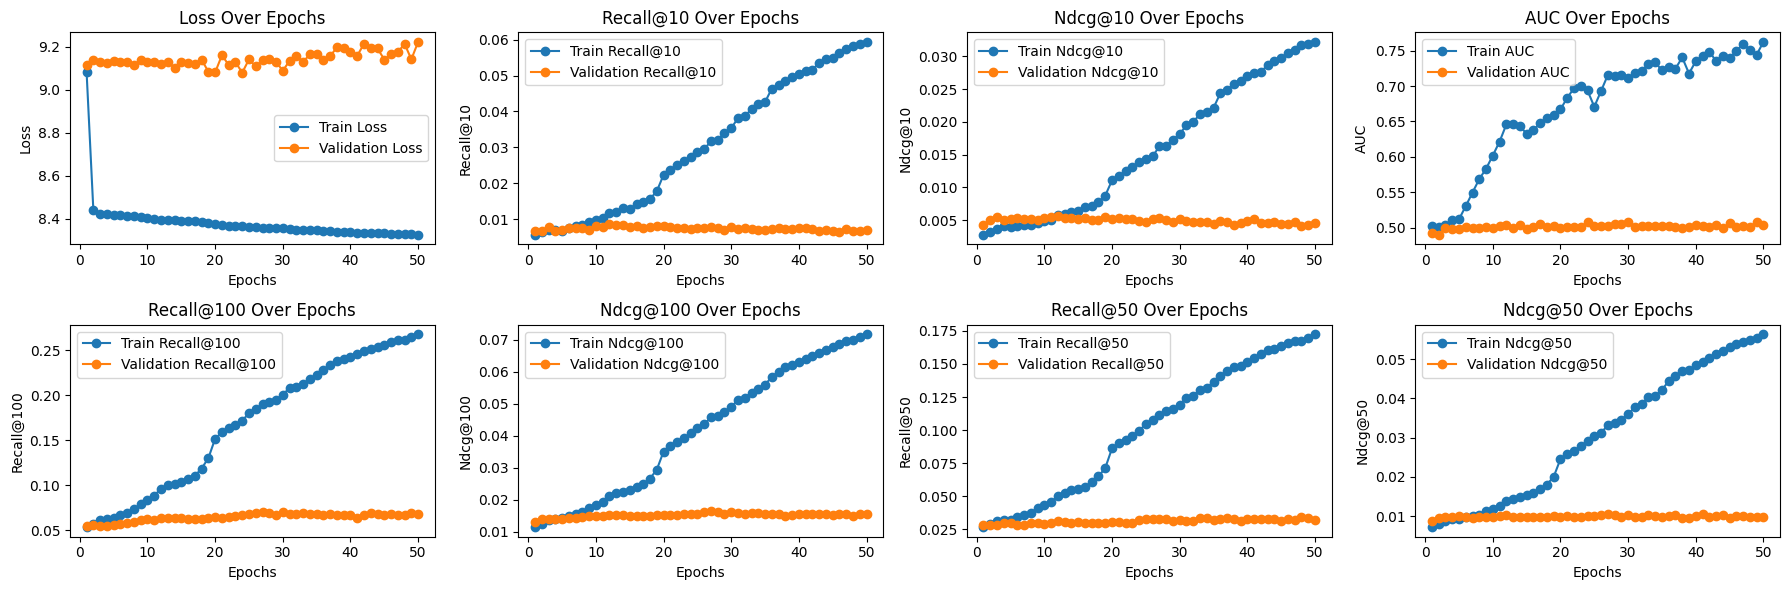

In [ ]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

Plot for model v9


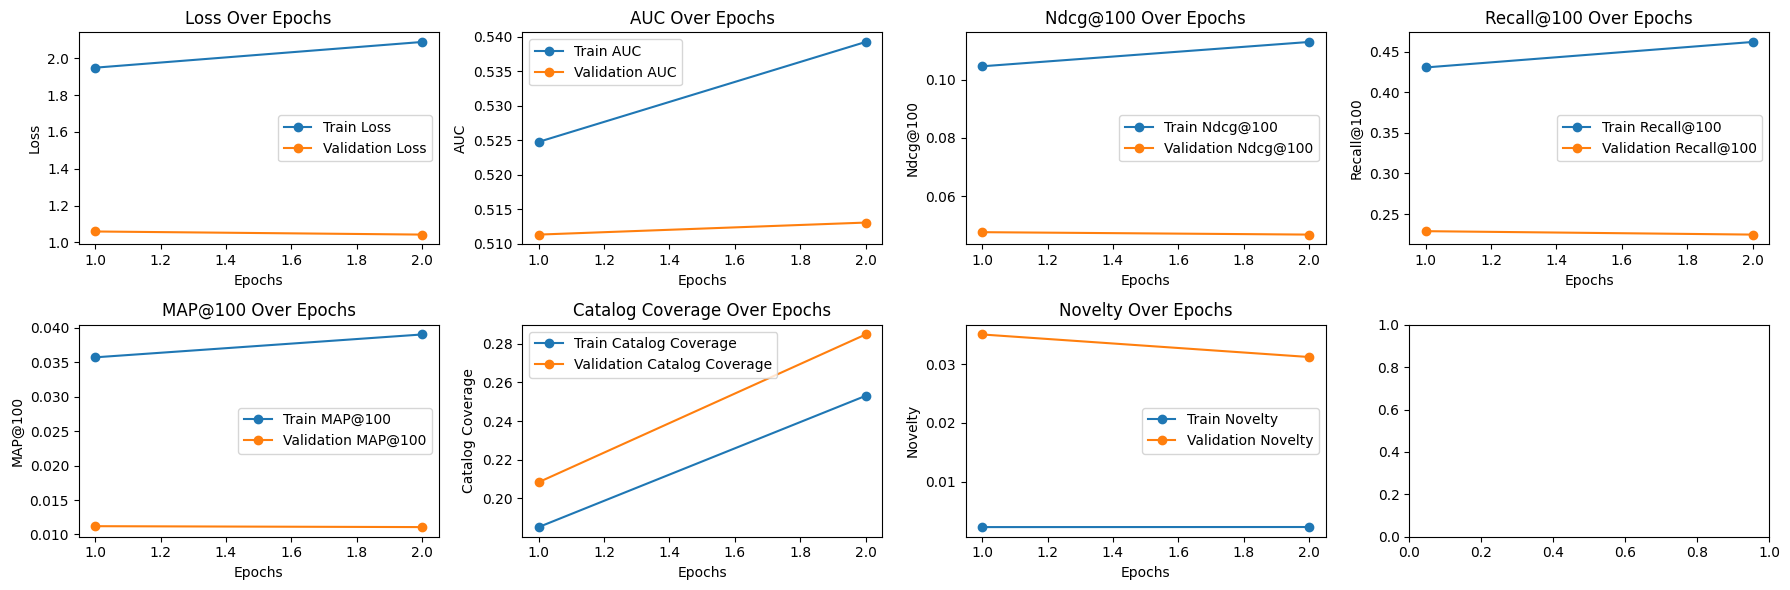

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


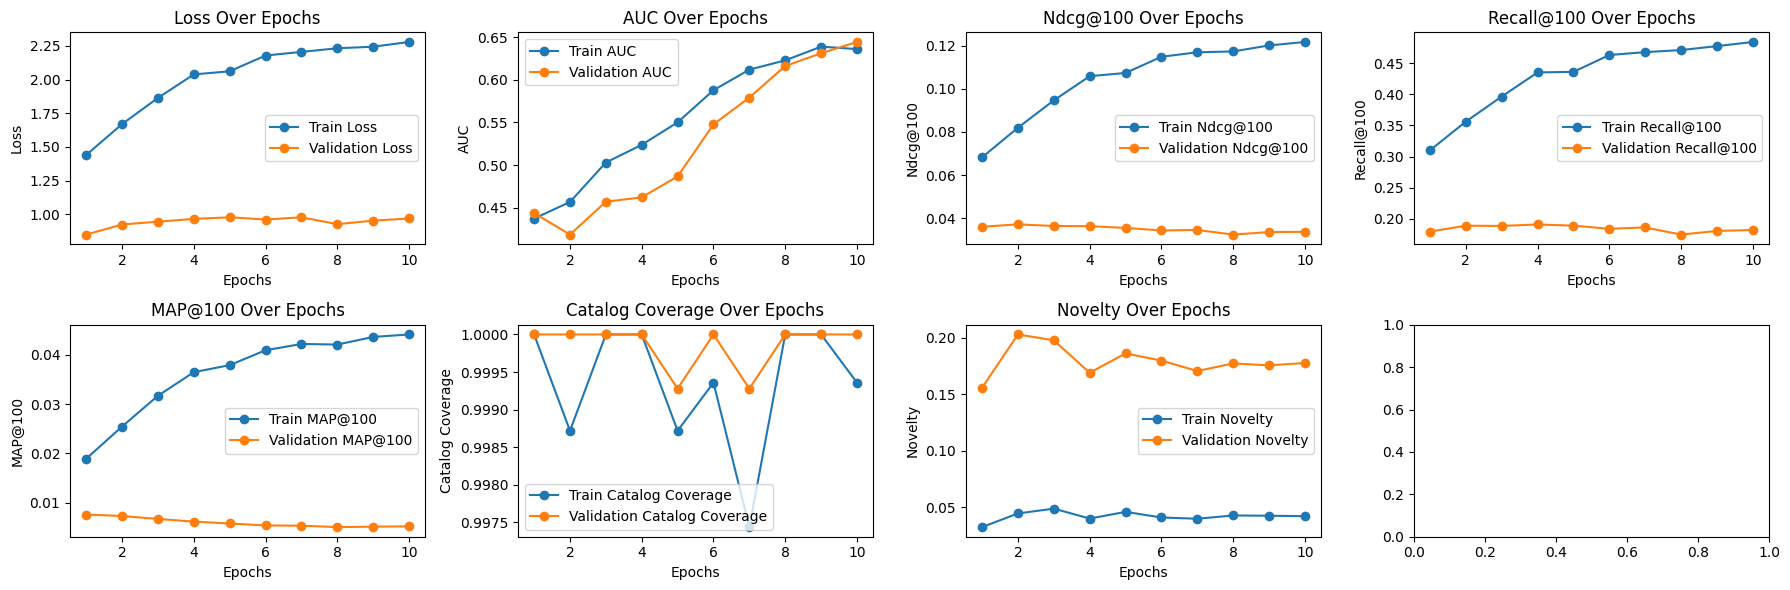

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


### model_v10

In [ ]:
VERSION = 'v10'

_tower_dim = {
    'user':[128, 128],
    'item':[512, 128],
}

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 4 # @param
_validation_freq = 1 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = True # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 96
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [ ]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [ ]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block  # needed to initiate the text embeddings
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=25, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=25, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

[INFO] hacked the logq correction to match item cardinality


#### model

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 36s 627ms/step - loss: 7.7570 - auc: 0.5085 - recall_at_100: 0.0619 - mrr_at_100: 0.0043 - ndcg_at_100: 0.0139 - map_at_100: 0.0043 - precision_at_100: 6.1872e-04 - recall_at_50: 0.0326 - mrr_at_50: 0.0039 - ndcg_at_50: 0.0092 - map_at_50: 0.0039 - precision_at_50: 6.5114e-04 - recall_at_10: 0.0075 - mrr_at_10: 0.0029 - ndcg_at_10: 0.0040 - map_at_10: 0.0029 - precision_at_10: 7.5251e-04 - regularization_loss: 0.0000e+00 - loss_batch: 7.6737 - val_loss: 8.0024 - val_auc: 0.5478 - val_recall_at_100: 0.0759 - val_mrr_at_100: 0.0063 - val_ndcg_at_100: 0.0178 - val_map_at_100: 0.0063 - val_precision_at_100: 7.5899e-04 - val_recall_at_50: 0.0395 - val_mrr_at_50: 0.0058 - val_ndcg_at_50: 0.0119 - val_map_at_50: 0.0058 - val_precision_at_50: 7.9042e-04 - val_recall_at_10: 0.0082 - val_mrr_at_10: 0.0045 - val_ndcg_at_10: 0.0053 - val_map_at_10: 0.0045 - val_precision_at_10: 8.2252e-04 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 7.

69/69 [==============================] - 8s 20ms/step - loss: 2.5961 - auc: 0.5238 - recall_at_100: 0.5709 - mrr_at_100: 0.0458 - ndcg_at_100: 0.1378 - map_at_100: 0.0458 - precision_at_100: 0.0057 - recall_at_10: 0.1044 - mrr_at_10: 0.0315 - ndcg_at_10: 0.0482 - map_at_10: 0.0315 - precision_at_10: 0.0104 - regularization_loss: 0.0000e+00 - loss_batch: 2.6125
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.596132516860962, 'auc': 0.5238280296325684, 'recall_at_100': 0.5771345496177673, 'mrr_at_100': 0.0471796840429306, 'ndcg_at_100': 0.14002719521522522, 'map_at_100': 0.0471796840429306, 'precision_at_100': 0.00577134545892477, 'recall_at_10': 0.10596564412117004, 'mrr_at_10': 0.032745301723480225, 'ndcg_at_10': 0.049524981528520584, 'map_at_10': 0.032745301723480225, 'precision_at_10': 0.010596564039587975, 'regularization_loss': 0.0, 'loss_batch': 3.3894407749176025, 'coverage': 0.8782831518257527, 'novelty': 0.0046393553116436505}
Candidate set rows: 1387


15/15 [==============================] - 5s 25ms/step - loss: 1.0673 - auc: 0.5342 - recall_at_100: 0.2192 - mrr_at_100: 0.0083 - ndcg_at_100: 0.0429 - map_at_100: 0.0083 - precision_at_100: 0.0022 - recall_at_10: 0.0147 - mrr_at_10: 0.0033 - ndcg_at_10: 0.0059 - map_at_10: 0.0033 - precision_at_10: 0.0015 - regularization_loss: 0.0000e+00 - loss_batch: 1.0715
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.0672738552093506, 'auc': 0.5341693162918091, 'recall_at_100': 0.21733315289020538, 'mrr_at_100': 0.008706647902727127, 'ndcg_at_100': 0.0429840125143528, 'map_at_100': 0.008706647902727127, 'precision_at_100': 0.002173331566154957, 'recall_at_10': 0.015046141110360622, 'mrr_at_10': 0.0037532823625952005, 'ndcg_at_10': 0.006309220101684332, 'map_at_10': 0.0037532823625952005, 'precision_at_10': 0.0015046141343191266, 'regularization_loss': 0.0, 'loss_batch': 1.1153556108474731, 'coverage': 0.8911319394376351, 'novelty': 0.04357670979667283}
35/35 [==============

69/69 [==============================] - 6s 21ms/step - loss: 2.6572 - auc: 0.5290 - recall_at_100: 0.5899 - mrr_at_100: 0.0475 - ndcg_at_100: 0.1426 - map_at_100: 0.0475 - precision_at_100: 0.0059 - recall_at_10: 0.1075 - mrr_at_10: 0.0326 - ndcg_at_10: 0.0497 - map_at_10: 0.0326 - precision_at_10: 0.0107 - regularization_loss: 0.0000e+00 - loss_batch: 2.6735
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.6572012901306152, 'auc': 0.5289895534515381, 'recall_at_100': 0.5918492078781128, 'mrr_at_100': 0.04868999868631363, 'ndcg_at_100': 0.14400939643383026, 'map_at_100': 0.04868999868631363, 'precision_at_100': 0.005918491631746292, 'recall_at_10': 0.10945557057857513, 'mrr_at_10': 0.03376121073961258, 'ndcg_at_10': 0.05110403895378113, 'map_at_10': 0.03376121073961258, 'precision_at_10': 0.010945558547973633, 'regularization_loss': 0.0, 'loss_batch': 3.4456028938293457, 'coverage': 0.931454196028187, 'novelty': 0.005903195112179487}
Candidate set rows: 1387


15/15 [==============================] - 6s 24ms/step - loss: 1.0319 - auc: 0.5255 - recall_at_100: 0.2055 - mrr_at_100: 0.0072 - ndcg_at_100: 0.0395 - map_at_100: 0.0072 - precision_at_100: 0.0021 - recall_at_10: 0.0115 - mrr_at_10: 0.0025 - ndcg_at_10: 0.0045 - map_at_10: 0.0025 - precision_at_10: 0.0011 - regularization_loss: 0.0000e+00 - loss_batch: 1.0255
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.0318986177444458, 'auc': 0.5255224108695984, 'recall_at_100': 0.20817172527313232, 'mrr_at_100': 0.0074548604898154736, 'ndcg_at_100': 0.04029380530118942, 'map_at_100': 0.0074548604898154736, 'precision_at_100': 0.0020817171316593885, 'recall_at_10': 0.012103784829378128, 'mrr_at_10': 0.0027157356962561607, 'ndcg_at_10': 0.004843749105930328, 'map_at_10': 0.0027157356962561607, 'precision_at_10': 0.0012103784829378128, 'regularization_loss': 0.0, 'loss_batch': 0.9582186937332153, 'coverage': 0.9300648882480173, 'novelty': 0.051546955285886084}
35/35 [=========

#### analysis

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

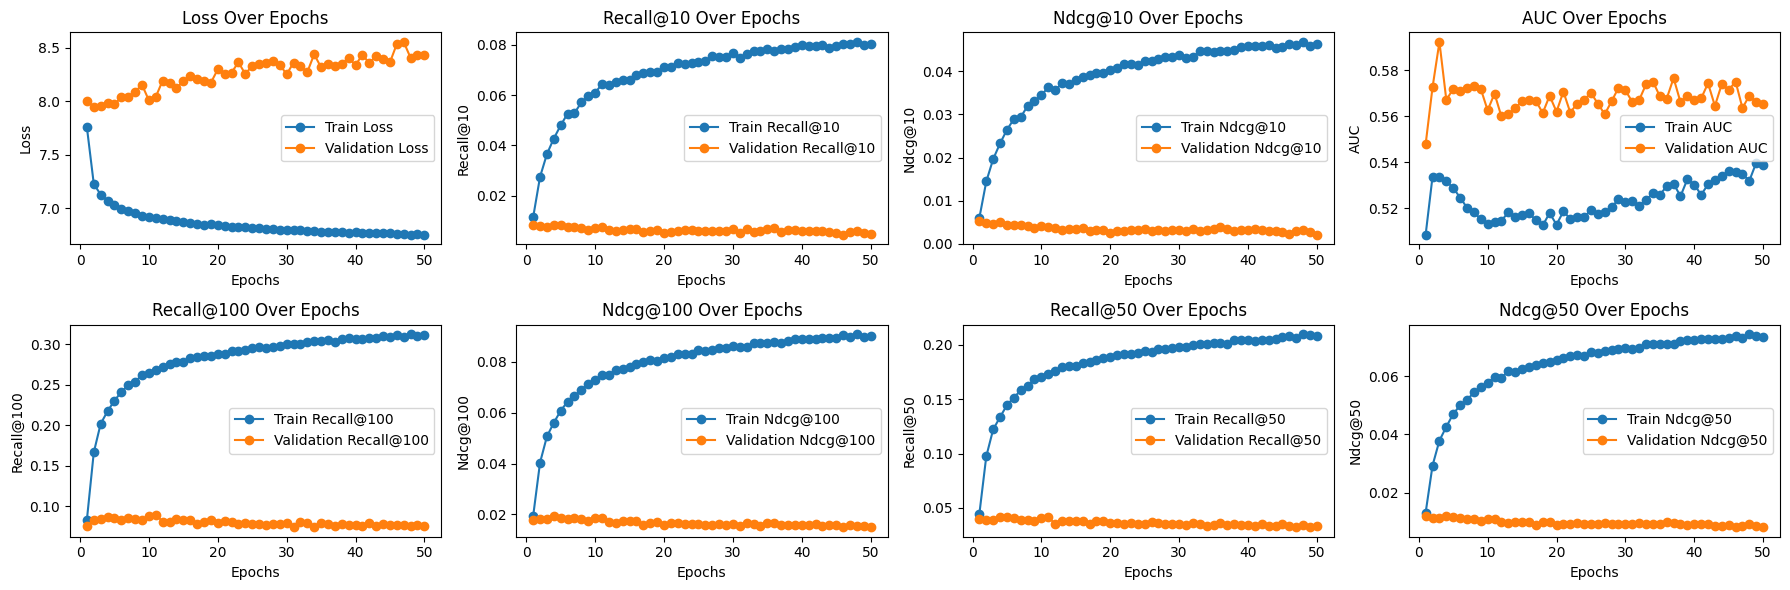

In [ ]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

Plot for model v10


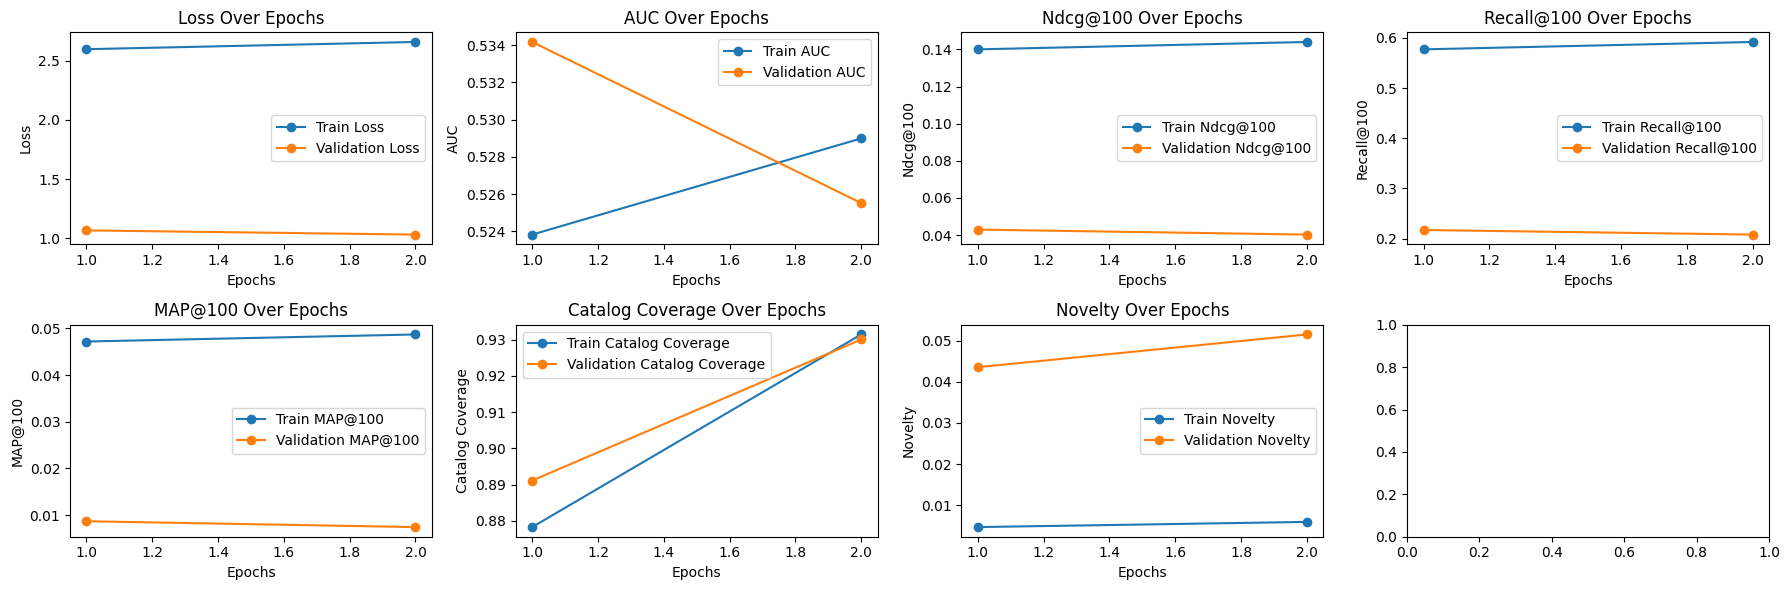

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


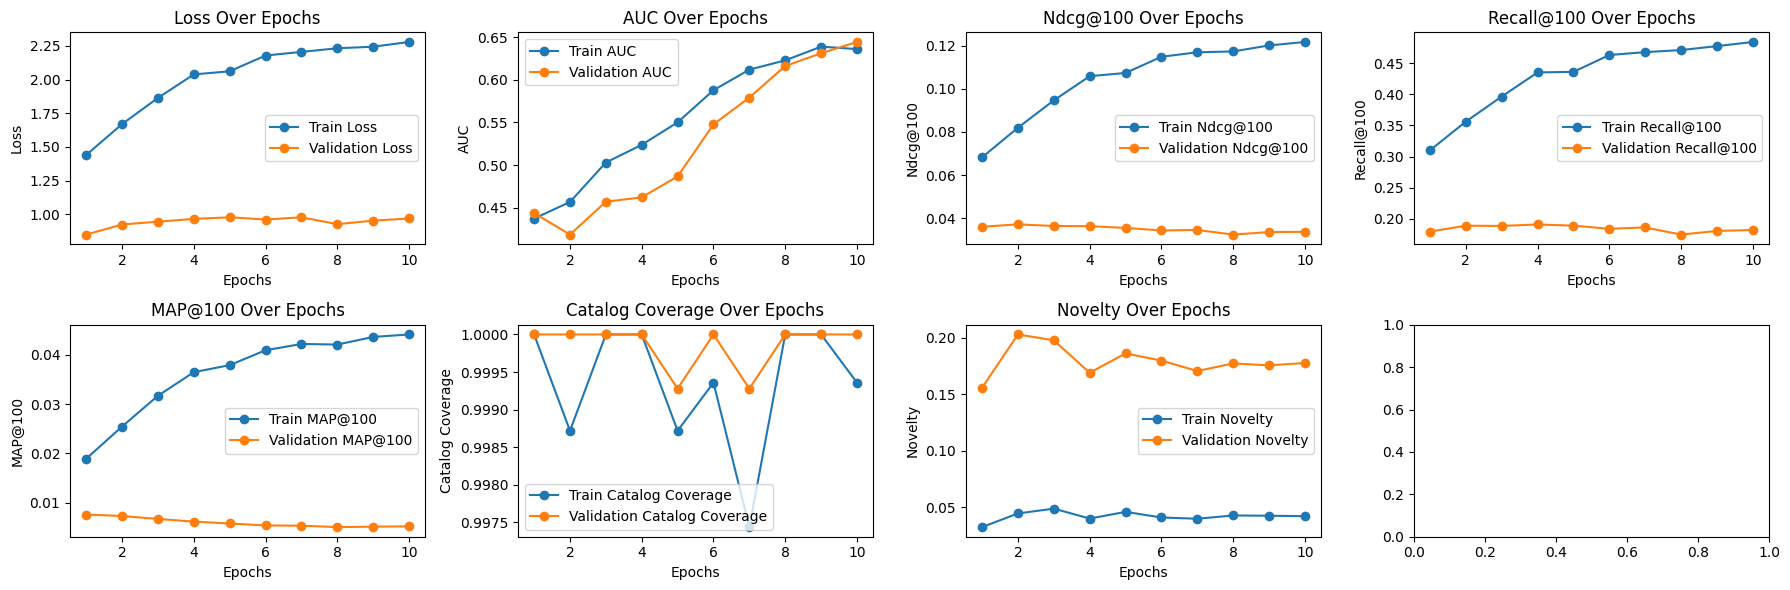

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


### model_v11

In [ ]:
VERSION = 'v11'

_tower_dim = {
    'user':[128, 128],
    'item':[512, 128],
}

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 4 # @param
_validation_freq = 1 # @param
# _loss = 'categorical_crossentropy' # @param
_loss = 'bpr-max' # @param

_logq_sampling_correction = True # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 96
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [ ]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [ ]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block  # needed to initiate the text embeddings
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=25, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=25, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

[INFO] hacked the logq correction to match item cardinality


#### model

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 36s 609ms/step - loss: 9.0111 - auc: 0.5003 - recall_at_100: 0.0507 - mrr_at_100: 0.0036 - ndcg_at_100: 0.0114 - map_at_100: 0.0036 - precision_at_100: 5.0684e-04 - recall_at_50: 0.0262 - mrr_at_50: 0.0033 - ndcg_at_50: 0.0075 - map_at_50: 0.0033 - precision_at_50: 5.2374e-04 - recall_at_10: 0.0059 - mrr_at_10: 0.0025 - ndcg_at_10: 0.0032 - map_at_10: 0.0025 - precision_at_10: 5.8562e-04 - regularization_loss: 0.0000e+00 - loss_batch: 8.9265 - val_loss: 8.9683 - val_auc: 0.4855 - val_recall_at_100: 0.0560 - val_mrr_at_100: 0.0060 - val_ndcg_at_100: 0.0142 - val_map_at_100: 0.0060 - val_precision_at_100: 5.6039e-04 - val_recall_at_50: 0.0284 - val_mrr_at_50: 0.0056 - val_ndcg_at_50: 0.0097 - val_map_at_50: 0.0056 - val_precision_at_50: 5.6707e-04 - val_recall_at_10: 0.0069 - val_mrr_at_10: 0.0047 - val_ndcg_at_10: 0.0052 - val_map_at_10: 0.0047 - val_precision_at_10: 6.8878e-04 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 8.

69/69 [==============================] - 8s 32ms/step - loss: 2.1350 - auc: 0.5477 - recall_at_100: 0.4701 - mrr_at_100: 0.0399 - ndcg_at_100: 0.1153 - map_at_100: 0.0399 - precision_at_100: 0.0047 - recall_at_10: 0.0881 - mrr_at_10: 0.0283 - ndcg_at_10: 0.0420 - map_at_10: 0.0283 - precision_at_10: 0.0088 - regularization_loss: 0.0000e+00 - loss_batch: 2.1456
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.135047435760498, 'auc': 0.5476733446121216, 'recall_at_100': 0.47326287627220154, 'mrr_at_100': 0.04023982211947441, 'ndcg_at_100': 0.11612475663423538, 'map_at_100': 0.04023982211947441, 'precision_at_100': 0.00473262881860137, 'recall_at_10': 0.08865844458341599, 'mrr_at_10': 0.028493298217654228, 'ndcg_at_10': 0.04231632128357887, 'map_at_10': 0.028493298217654228, 'precision_at_10': 0.008865844458341599, 'regularization_loss': 0.0, 'loss_batch': 2.644977569580078, 'coverage': 0.28315182575272263, 'novelty': 0.0022247807069281983}
Candidate set rows: 1387


15/15 [==============================] - 3s 24ms/step - loss: 1.0310 - auc: 0.5038 - recall_at_100: 0.2274 - mrr_at_100: 0.0105 - ndcg_at_100: 0.0467 - map_at_100: 0.0105 - precision_at_100: 0.0023 - recall_at_10: 0.0184 - mrr_at_10: 0.0049 - ndcg_at_10: 0.0079 - map_at_10: 0.0049 - precision_at_10: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 0.9804
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.031038522720337, 'auc': 0.5038081407546997, 'recall_at_100': 0.2220141738653183, 'mrr_at_100': 0.010176127776503563, 'ndcg_at_100': 0.04551050439476967, 'map_at_100': 0.010176127776503563, 'precision_at_100': 0.0022201414685696363, 'recall_at_10': 0.017854753881692886, 'mrr_at_10': 0.004717695992439985, 'ndcg_at_10': 0.007694920990616083, 'map_at_10': 0.004717695992439985, 'precision_at_10': 0.001785475411452353, 'regularization_loss': 0.0, 'loss_batch': 0.4508283734321594, 'coverage': 0.3186733958183129, 'novelty': 0.03156379702771456}
35/35 [=================

69/69 [==============================] - 6s 23ms/step - loss: 2.2262 - auc: 0.5453 - recall_at_100: 0.4915 - mrr_at_100: 0.0410 - ndcg_at_100: 0.1198 - map_at_100: 0.0410 - precision_at_100: 0.0049 - recall_at_10: 0.0904 - mrr_at_10: 0.0288 - ndcg_at_10: 0.0430 - map_at_10: 0.0288 - precision_at_10: 0.0090 - regularization_loss: 0.0000e+00 - loss_batch: 2.2381
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.2262070178985596, 'auc': 0.5452719926834106, 'recall_at_100': 0.493404746055603, 'mrr_at_100': 0.041752658784389496, 'ndcg_at_100': 0.1208329126238823, 'map_at_100': 0.041752658784389496, 'precision_at_100': 0.004934047814458609, 'recall_at_10': 0.09174951910972595, 'mrr_at_10': 0.029545404016971588, 'ndcg_at_10': 0.043832000344991684, 'map_at_10': 0.029545404016971588, 'precision_at_10': 0.00917495135217905, 'regularization_loss': 0.0, 'loss_batch': 2.804330348968506, 'coverage': 0.31326073030108903, 'novelty': 0.0022434326660925254}
Candidate set rows: 1387


15/15 [==============================] - 3s 24ms/step - loss: 1.0159 - auc: 0.4989 - recall_at_100: 0.2168 - mrr_at_100: 0.0093 - ndcg_at_100: 0.0438 - map_at_100: 0.0093 - precision_at_100: 0.0022 - recall_at_10: 0.0175 - mrr_at_10: 0.0042 - ndcg_at_10: 0.0072 - map_at_10: 0.0042 - precision_at_10: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 0.9701
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.0158828496932983, 'auc': 0.49892884492874146, 'recall_at_100': 0.2178012579679489, 'mrr_at_100': 0.009433066472411156, 'ndcg_at_100': 0.04403485357761383, 'map_at_100': 0.009433066472411156, 'precision_at_100': 0.002178012626245618, 'recall_at_10': 0.017052292823791504, 'mrr_at_10': 0.004205781500786543, 'ndcg_at_10': 0.007125213276594877, 'map_at_10': 0.004205781500786543, 'precision_at_10': 0.0017052293987944722, 'regularization_loss': 0.0, 'loss_batch': 0.49092191457748413, 'coverage': 0.35255948089401584, 'novelty': 0.03251051506584844}
35/35 [=============

#### analysis

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

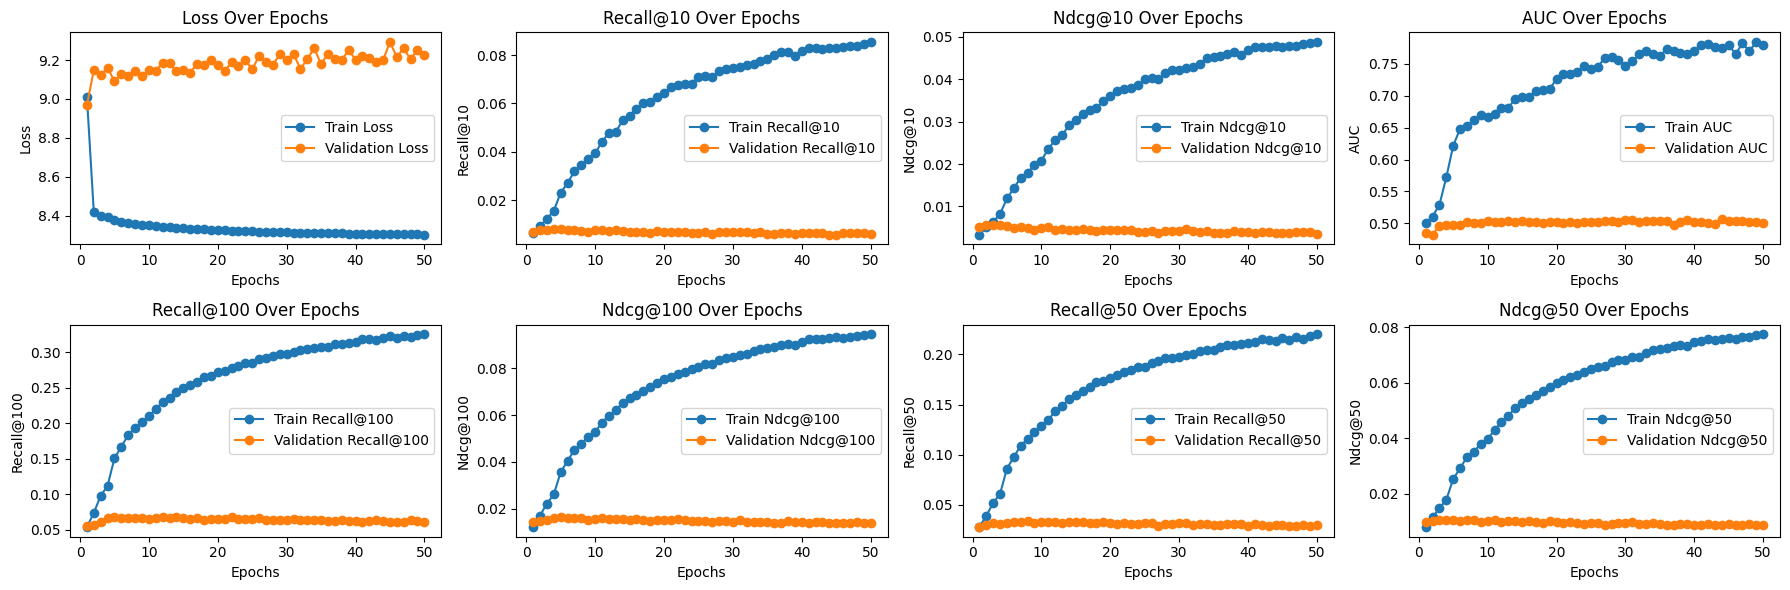

In [ ]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

Plot for model v11


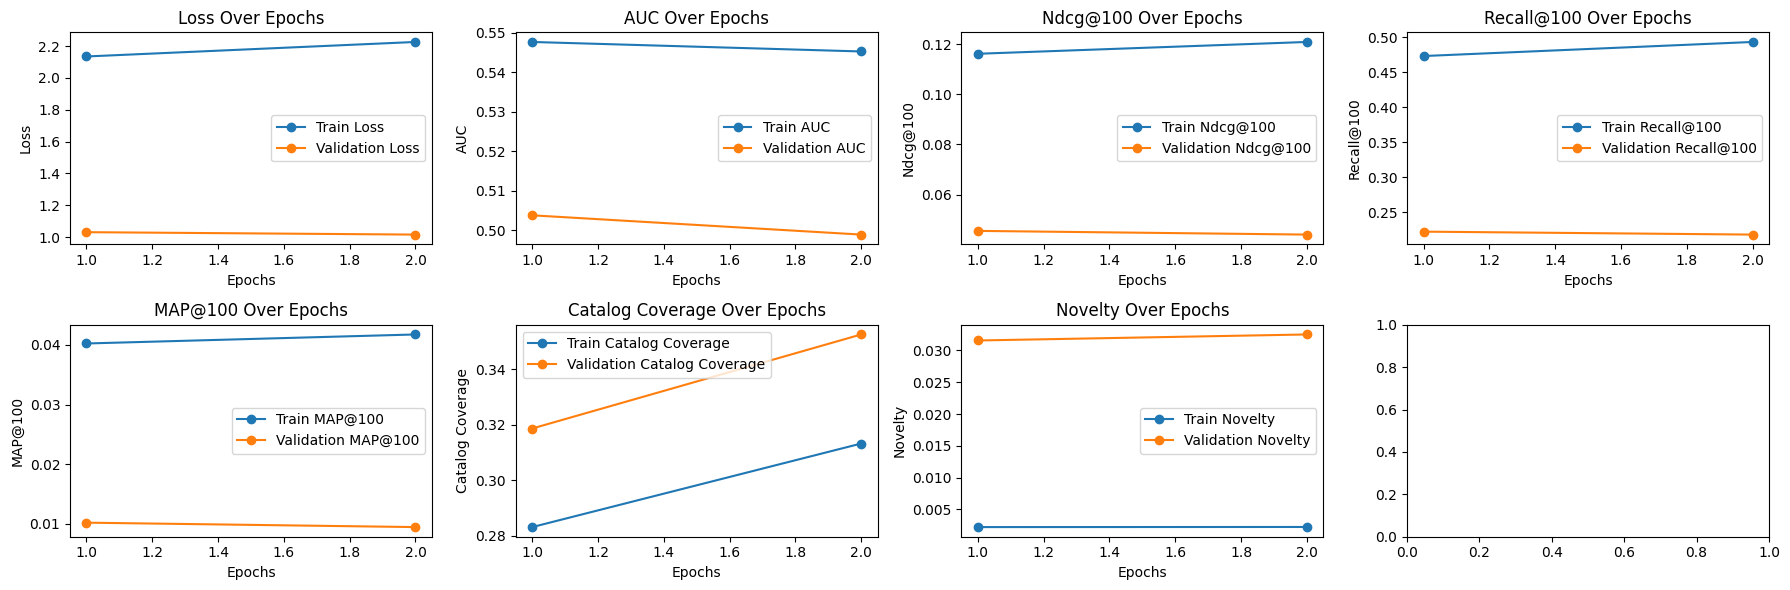

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


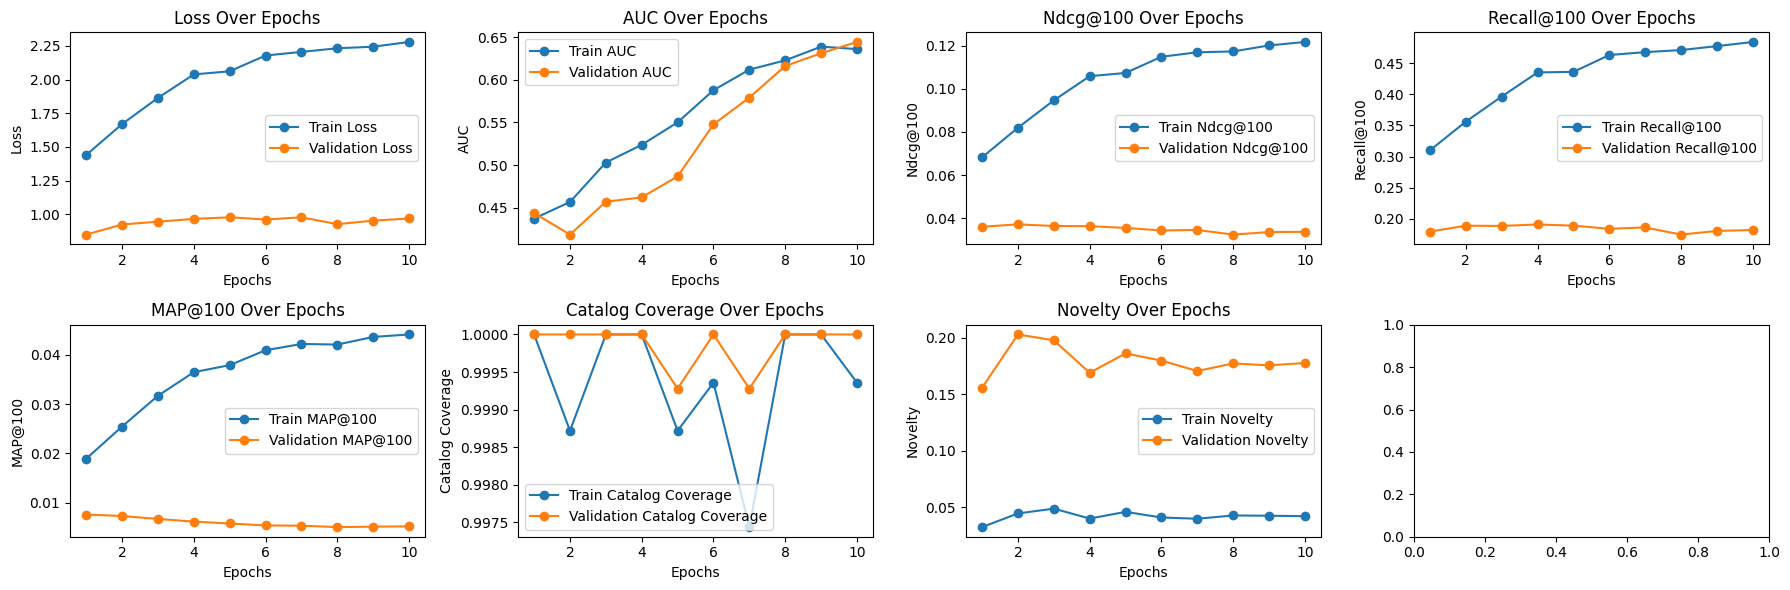

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


### model_v100

In [ ]:
VERSION = 'v100'

_tower_dim = {
    'user':[128, 256],
    'item':[512, 256],
}

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 2 # @param
_validation_freq = 1 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 96
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [ ]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

RuntimeError: ignored

In [ ]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block  # needed to initiate the text embeddings
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=10, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=10, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 29s 470ms/step - loss: 8.0307 - auc: 0.5125 - recall_at_100: 0.0559 - mrr_at_100: 0.0037 - ndcg_at_100: 0.0124 - map_at_100: 0.0037 - precision_at_100: 5.5938e-04 - recall_at_50: 0.0290 - mrr_at_50: 0.0033 - ndcg_at_50: 0.0081 - map_at_50: 0.0033 - precision_at_50: 5.8040e-04 - recall_at_10: 0.0066 - mrr_at_10: 0.0025 - ndcg_at_10: 0.0034 - map_at_10: 0.0025 - precision_at_10: 6.5781e-04 - regularization_loss: 0.0000e+00 - loss_batch: 7.9431 - val_loss: 7.4877 - val_auc: 0.5347 - val_recall_at_100: 0.0913 - val_mrr_at_100: 0.0056 - val_ndcg_at_100: 0.0200 - val_map_at_100: 0.0056 - val_precision_at_100: 9.1280e-04 - val_recall_at_50: 0.0492 - val_mrr_at_50: 0.0050 - val_ndcg_at_50: 0.0132 - val_map_at_50: 0.0050 - val_precision_at_50: 9.8435e-04 - val_recall_at_10: 0.0102 - val_mrr_at_10: 0.0035 - val_ndcg_at_10: 0.0050 - val_map_at_10: 0.0035 - val_precision_at_10: 0.0010 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 6.4530

69/69 [==============================] - 5s 20ms/step - loss: 1.6237 - auc: 0.5220 - recall_at_100: 0.3490 - mrr_at_100: 0.0236 - ndcg_at_100: 0.0791 - map_at_100: 0.0236 - precision_at_100: 0.0035 - recall_at_10: 0.0486 - mrr_at_10: 0.0152 - ndcg_at_10: 0.0228 - map_at_10: 0.0152 - precision_at_10: 0.0049 - regularization_loss: 0.0000e+00 - loss_batch: 1.6341
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.6237256526947021, 'auc': 0.5220141410827637, 'recall_at_100': 0.3487222492694855, 'mrr_at_100': 0.02331405133008957, 'ndcg_at_100': 0.07881972193717957, 'map_at_100': 0.02331405133008957, 'precision_at_100': 0.0034872223623096943, 'recall_at_10': 0.048360444605350494, 'mrr_at_10': 0.014943844638764858, 'ndcg_at_10': 0.02259076200425625, 'map_at_10': 0.014943844638764858, 'precision_at_10': 0.004836044739931822, 'regularization_loss': 0.0, 'loss_batch': 2.1269893646240234, 'coverage': 1.0, 'novelty': 0.030117211203730322}
Candidate set rows: 1387


15/15 [==============================] - 5s 35ms/step - loss: 0.9686 - auc: 0.5469 - recall_at_100: 0.1927 - mrr_at_100: 0.0082 - ndcg_at_100: 0.0386 - map_at_100: 0.0082 - precision_at_100: 0.0019 - recall_at_10: 0.0143 - mrr_at_10: 0.0038 - ndcg_at_10: 0.0061 - map_at_10: 0.0038 - precision_at_10: 0.0014 - regularization_loss: 0.0000e+00 - loss_batch: 1.0223
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9685721397399902, 'auc': 0.5469383597373962, 'recall_at_100': 0.20128393173217773, 'mrr_at_100': 0.008577609434723854, 'ndcg_at_100': 0.0403890460729599, 'map_at_100': 0.008577609434723854, 'precision_at_100': 0.0020128393080085516, 'recall_at_10': 0.015313628129661083, 'mrr_at_10': 0.0038838153705000877, 'ndcg_at_10': 0.006462011486291885, 'map_at_10': 0.0038838153705000877, 'precision_at_10': 0.0015313629992306232, 'regularization_loss': 0.0, 'loss_batch': 1.5836178064346313, 'coverage': 0.9834174477289113, 'novelty': 0.14421165315797524}
35/35 [=============

69/69 [==============================] - 5s 21ms/step - loss: 1.8277 - auc: 0.5331 - recall_at_100: 0.3913 - mrr_at_100: 0.0300 - ndcg_at_100: 0.0924 - map_at_100: 0.0300 - precision_at_100: 0.0039 - recall_at_10: 0.0638 - mrr_at_10: 0.0204 - ndcg_at_10: 0.0304 - map_at_10: 0.0204 - precision_at_10: 0.0064 - regularization_loss: 0.0000e+00 - loss_batch: 1.8376
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.8277071714401245, 'auc': 0.5331391096115112, 'recall_at_100': 0.3926241397857666, 'mrr_at_100': 0.03087017685174942, 'ndcg_at_100': 0.09342209249734879, 'map_at_100': 0.03087017685174942, 'precision_at_100': 0.003926240839064121, 'recall_at_10': 0.06531152874231339, 'mrr_at_10': 0.021336030215024948, 'ndcg_at_10': 0.031434956938028336, 'map_at_10': 0.021336030215024948, 'precision_at_10': 0.006531153339892626, 'regularization_loss': 0.0, 'loss_batch': 2.3054206371307373, 'coverage': 1.0, 'novelty': 0.029605676252668595}
Candidate set rows: 1387


15/15 [==============================] - 3s 35ms/step - loss: 0.9613 - auc: 0.5176 - recall_at_100: 0.1935 - mrr_at_100: 0.0072 - ndcg_at_100: 0.0377 - map_at_100: 0.0072 - precision_at_100: 0.0019 - recall_at_10: 0.0108 - mrr_at_10: 0.0027 - ndcg_at_10: 0.0045 - map_at_10: 0.0027 - precision_at_10: 0.0011 - regularization_loss: 0.0000e+00 - loss_batch: 1.0057
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9612712264060974, 'auc': 0.5175740718841553, 'recall_at_100': 0.19553296267986298, 'mrr_at_100': 0.007680060341954231, 'ndcg_at_100': 0.03857196122407913, 'map_at_100': 0.007680060341954231, 'precision_at_100': 0.001955329440534115, 'recall_at_10': 0.012304400093853474, 'mrr_at_10': 0.0031229371670633554, 'ndcg_at_10': 0.005199181381613016, 'map_at_10': 0.0031229371670633554, 'precision_at_10': 0.0012304401025176048, 'regularization_loss': 0.0, 'loss_batch': 1.4707424640655518, 'coverage': 0.9855803893294881, 'novelty': 0.15083173384516954}
35/35 [=============

69/69 [==============================] - 5s 19ms/step - loss: 1.9382 - auc: 0.5470 - recall_at_100: 0.4108 - mrr_at_100: 0.0328 - ndcg_at_100: 0.0983 - map_at_100: 0.0328 - precision_at_100: 0.0041 - recall_at_10: 0.0717 - mrr_at_10: 0.0230 - ndcg_at_10: 0.0342 - map_at_10: 0.0230 - precision_at_10: 0.0072 - regularization_loss: 0.0000e+00 - loss_batch: 1.9501
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.93821382522583, 'auc': 0.5469925999641418, 'recall_at_100': 0.412011057138443, 'mrr_at_100': 0.03297312185168266, 'ndcg_at_100': 0.09860733896493912, 'map_at_100': 0.03297312185168266, 'precision_at_100': 0.004120110534131527, 'recall_at_10': 0.07108059525489807, 'mrr_at_10': 0.023066481575369835, 'ndcg_at_10': 0.03407718613743782, 'map_at_10': 0.023066481575369835, 'precision_at_10': 0.007108059711754322, 'regularization_loss': 0.0, 'loss_batch': 2.514251947402954, 'coverage': 1.0, 'novelty': 0.0337351983686903}
Candidate set rows: 1387


15/15 [==============================] - 3s 22ms/step - loss: 0.9689 - auc: 0.5451 - recall_at_100: 0.1838 - mrr_at_100: 0.0064 - ndcg_at_100: 0.0353 - map_at_100: 0.0064 - precision_at_100: 0.0018 - recall_at_10: 0.0107 - mrr_at_10: 0.0024 - ndcg_at_10: 0.0043 - map_at_10: 0.0024 - precision_at_10: 0.0011 - regularization_loss: 0.0000e+00 - loss_batch: 1.0170
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9688736796379089, 'auc': 0.545086681842804, 'recall_at_100': 0.1918550282716751, 'mrr_at_100': 0.006474521476775408, 'ndcg_at_100': 0.036697763949632645, 'map_at_100': 0.006474521476775408, 'precision_at_100': 0.0019185501150786877, 'recall_at_10': 0.011033836752176285, 'mrr_at_10': 0.00221947836689651, 'ndcg_at_10': 0.004210156854242086, 'map_at_10': 0.00221947836689651, 'precision_at_10': 0.001103383838199079, 'regularization_loss': 0.0, 'loss_batch': 1.5201950073242188, 'coverage': 0.9812545061283345, 'novelty': 0.17154811715481172}
35/35 [==================

69/69 [==============================] - 6s 20ms/step - loss: 2.0849 - auc: 0.5302 - recall_at_100: 0.4484 - mrr_at_100: 0.0368 - ndcg_at_100: 0.1085 - map_at_100: 0.0368 - precision_at_100: 0.0045 - recall_at_10: 0.0803 - mrr_at_10: 0.0257 - ndcg_at_10: 0.0383 - map_at_10: 0.0257 - precision_at_10: 0.0080 - regularization_loss: 0.0000e+00 - loss_batch: 2.0964
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.0848567485809326, 'auc': 0.5301775932312012, 'recall_at_100': 0.4472237229347229, 'mrr_at_100': 0.03726518526673317, 'ndcg_at_100': 0.10879532992839813, 'map_at_100': 0.03726518526673317, 'precision_at_100': 0.00447223661467433, 'recall_at_10': 0.08142217993736267, 'mrr_at_10': 0.026283519342541695, 'ndcg_at_10': 0.03894325718283653, 'map_at_10': 0.026283519342541695, 'precision_at_10': 0.008142217062413692, 'regularization_loss': 0.0, 'loss_batch': 2.642911434173584, 'coverage': 1.0, 'novelty': 0.03053954271649718}
Candidate set rows: 1387


15/15 [==============================] - 3s 22ms/step - loss: 0.9972 - auc: 0.5242 - recall_at_100: 0.1886 - mrr_at_100: 0.0062 - ndcg_at_100: 0.0359 - map_at_100: 0.0062 - precision_at_100: 0.0019 - recall_at_10: 0.0094 - mrr_at_10: 0.0020 - ndcg_at_10: 0.0036 - map_at_10: 0.0020 - precision_at_10: 9.3645e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0466
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9971755146980286, 'auc': 0.5242172479629517, 'recall_at_100': 0.1966697871685028, 'mrr_at_100': 0.006740458309650421, 'ndcg_at_100': 0.037738531827926636, 'map_at_100': 0.006740458309650421, 'precision_at_100': 0.0019666978623718023, 'recall_at_10': 0.01083322148770094, 'mrr_at_10': 0.002280167071148753, 'ndcg_at_10': 0.004203550051897764, 'map_at_10': 0.002280167071148753, 'precision_at_10': 0.001083322218619287, 'regularization_loss': 0.0, 'loss_batch': 1.563981533050537, 'coverage': 0.9906272530641672, 'novelty': 0.1504707196425722}
35/35 [==============

69/69 [==============================] - 7s 31ms/step - loss: 2.0598 - auc: 0.5198 - recall_at_100: 0.4383 - mrr_at_100: 0.0367 - ndcg_at_100: 0.1068 - map_at_100: 0.0367 - precision_at_100: 0.0044 - recall_at_10: 0.0801 - mrr_at_10: 0.0259 - ndcg_at_10: 0.0383 - map_at_10: 0.0259 - precision_at_10: 0.0080 - regularization_loss: 0.0000e+00 - loss_batch: 2.0722
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.059838056564331, 'auc': 0.5198140144348145, 'recall_at_100': 0.4377795457839966, 'mrr_at_100': 0.036943890154361725, 'ndcg_at_100': 0.10696560889482498, 'map_at_100': 0.036943890154361725, 'precision_at_100': 0.0043777949176728725, 'recall_at_10': 0.0812939777970314, 'mrr_at_10': 0.02622660994529724, 'ndcg_at_10': 0.038873765617609024, 'map_at_10': 0.02622660994529724, 'precision_at_10': 0.00812939926981926, 'regularization_loss': 0.0, 'loss_batch': 2.661769390106201, 'coverage': 1.0, 'novelty': 0.03542316216520792}
Candidate set rows: 1387


15/15 [==============================] - 3s 22ms/step - loss: 1.0025 - auc: 0.5046 - recall_at_100: 0.1919 - mrr_at_100: 0.0060 - ndcg_at_100: 0.0362 - map_at_100: 0.0060 - precision_at_100: 0.0019 - recall_at_10: 0.0089 - mrr_at_10: 0.0018 - ndcg_at_10: 0.0034 - map_at_10: 0.0018 - precision_at_10: 8.9202e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0347
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.0024631023406982, 'auc': 0.5046349763870239, 'recall_at_100': 0.19419553875923157, 'mrr_at_100': 0.006395608186721802, 'ndcg_at_100': 0.036937166005373, 'map_at_100': 0.006395608186721802, 'precision_at_100': 0.0019419551827013493, 'recall_at_10': 0.009830146096646786, 'mrr_at_10': 0.002040490275248885, 'ndcg_at_10': 0.00378837320022285, 'map_at_10': 0.002040490275248885, 'precision_at_10': 0.0009830145863816142, 'regularization_loss': 0.0, 'loss_batch': 1.3721115589141846, 'coverage': 0.9805335255948089, 'novelty': 0.16411416637660983}
35/35 [=============

#### analysis

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v100


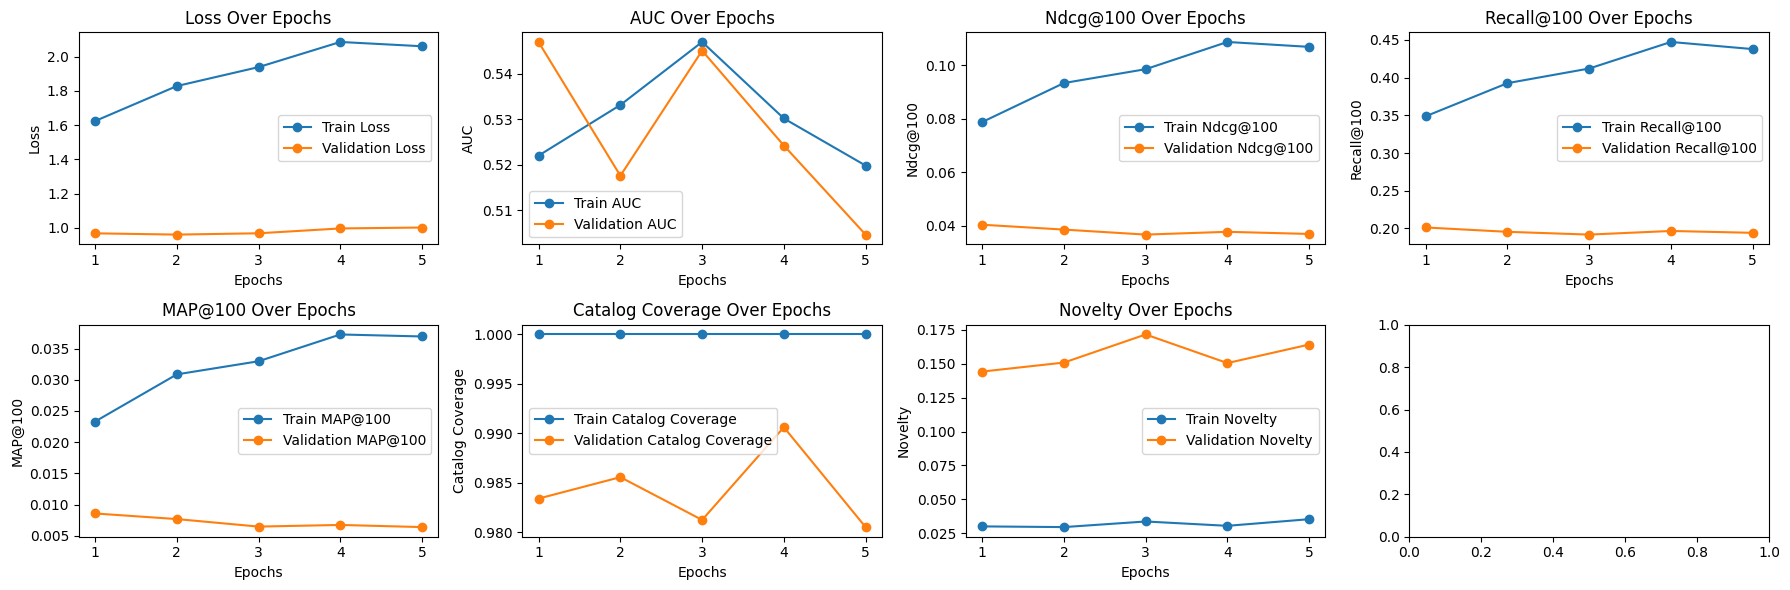

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v100


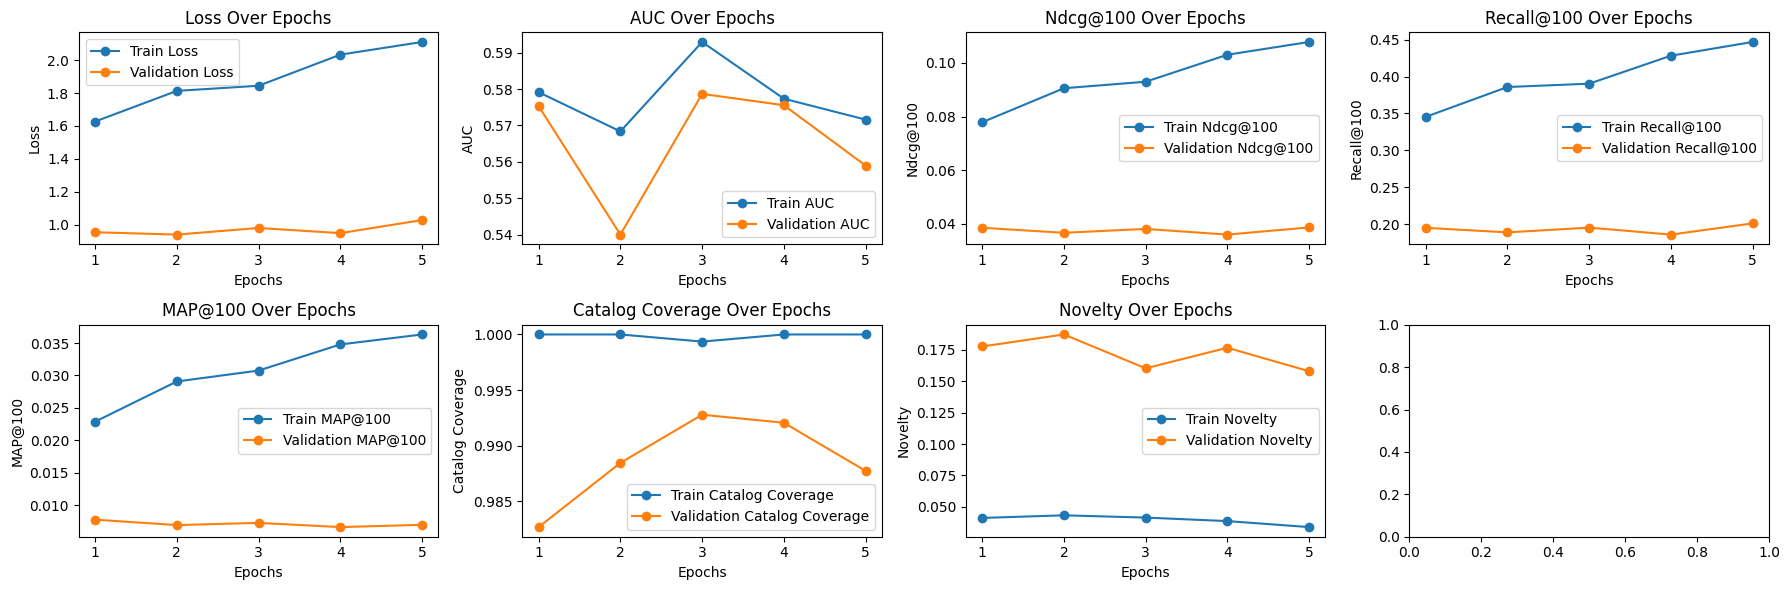

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


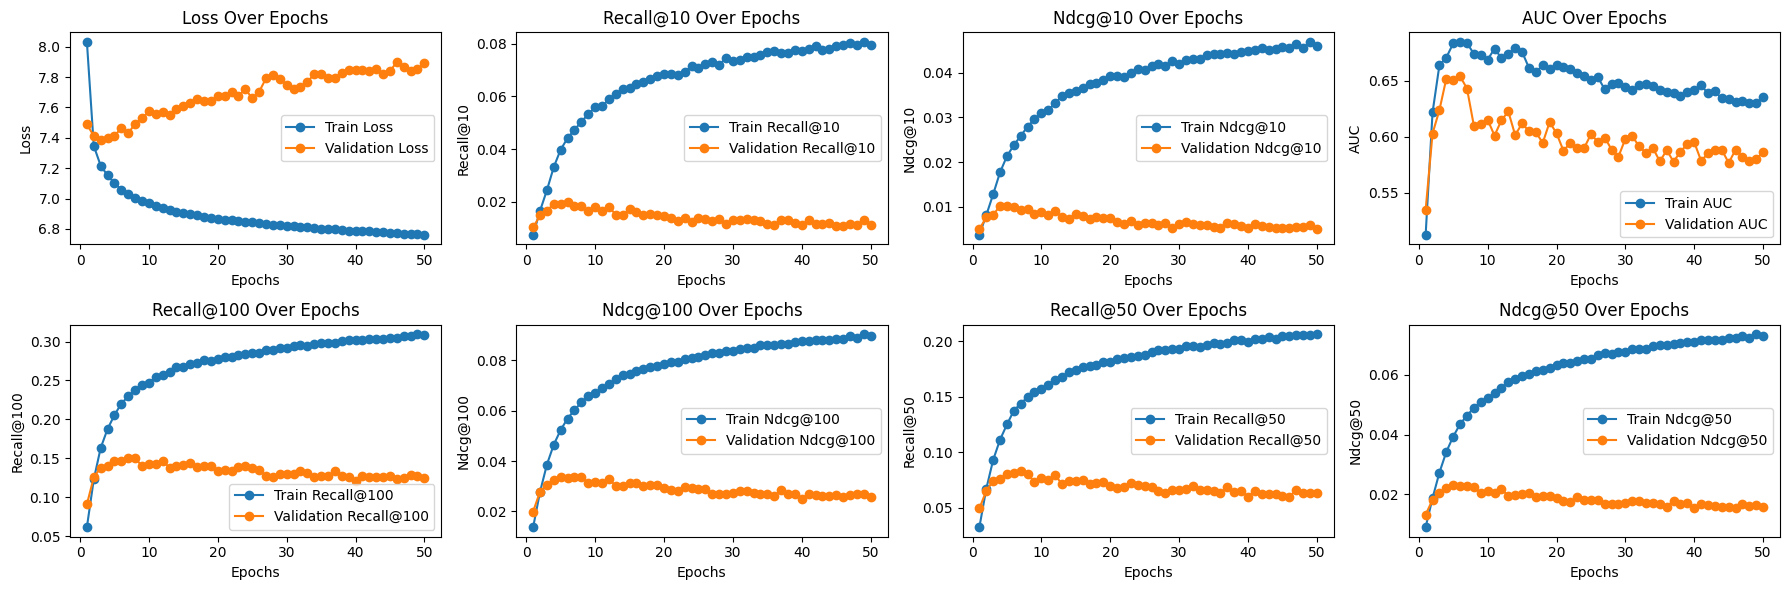

In [ ]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

### model_v101

In [35]:
VERSION = 'v101'

_tower_dim = {
    'user':[512],
    'item':[1024, 512],
}

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 2 # @param
_validation_freq = 1 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param
_logits_temperature = 1

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 196
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [36]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [37]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block,  # needed to initiate the text embeddings
    regularize={},
    logits_temperature=_logits_temperature
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=25, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=25, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [38]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [39]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 55s 811ms/step - loss: 8.2938 - auc: 0.5119 - recall_at_100: 0.0570 - mrr_at_100: 0.0041 - ndcg_at_100: 0.0129 - map_at_100: 0.0041 - precision_at_100: 5.6963e-04 - recall_at_10: 0.0073 - mrr_at_10: 0.0028 - ndcg_at_10: 0.0038 - map_at_10: 0.0028 - precision_at_10: 7.3165e-04 - regularization_loss: 0.0000e+00 - loss_batch: 8.1940 - val_loss: 7.4999 - val_auc: 0.5366 - val_recall_at_100: 0.0987 - val_mrr_at_100: 0.0069 - val_ndcg_at_100: 0.0223 - val_map_at_100: 0.0069 - val_precision_at_100: 9.8703e-04 - val_recall_at_10: 0.0122 - val_mrr_at_10: 0.0046 - val_ndcg_at_10: 0.0063 - val_map_at_10: 0.0046 - val_precision_at_10: 0.0012 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 6.3704
Epoch 2/50
35/35 [==============================] - 19s 474ms/step - loss: 7.3131 - auc: 0.6005 - recall_at_100: 0.1286 - mrr_at_100: 0.0096 - ndcg_at_100: 0.0296 - map_at_100: 0.0096 - precision_at_100: 0.0013 - recall_at_10: 0.0170 - mrr_at_10: 

69/69 [==============================] - 9s 33ms/step - loss: 2.2487 - auc: 0.5296 - recall_at_100: 0.4834 - mrr_at_100: 0.0442 - ndcg_at_100: 0.1220 - map_at_100: 0.0442 - precision_at_100: 0.0048 - recall_at_10: 0.1016 - mrr_at_10: 0.0322 - ndcg_at_10: 0.0481 - map_at_10: 0.0322 - precision_at_10: 0.0102 - regularization_loss: 0.0000e+00 - loss_batch: 2.2654
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.248690128326416, 'auc': 0.5296096205711365, 'recall_at_100': 0.48444488644599915, 'mrr_at_100': 0.04478553310036659, 'ndcg_at_100': 0.12269897758960724, 'map_at_100': 0.04478553310036659, 'precision_at_100': 0.004844449460506439, 'recall_at_10': 0.10274636000394821, 'mrr_at_10': 0.0327373705804348, 'ndcg_at_10': 0.048821821808815, 'map_at_10': 0.0327373705804348, 'precision_at_10': 0.010274634696543217, 'regularization_loss': 0.0, 'loss_batch': 3.058490037918091, 'coverage': 0.9993593850096092, 'novelty': 0.03277264196844373}
Candidate set rows: 1387


15/15 [==============================] - 6s 34ms/step - loss: 0.8368 - auc: 0.4947 - recall_at_100: 0.1493 - mrr_at_100: 0.0037 - ndcg_at_100: 0.0269 - map_at_100: 0.0037 - precision_at_100: 0.0015 - recall_at_10: 0.0029 - mrr_at_10: 5.0158e-04 - ndcg_at_10: 0.0010 - map_at_10: 5.0158e-04 - precision_at_10: 2.9092e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.8957
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8367609977722168, 'auc': 0.4947035312652588, 'recall_at_100': 0.15788418054580688, 'mrr_at_100': 0.004104180261492729, 'ndcg_at_100': 0.028725935146212578, 'map_at_100': 0.004104180261492729, 'precision_at_100': 0.0015788418240845203, 'recall_at_10': 0.00361107406206429, 'mrr_at_10': 0.0006260733352974057, 'ndcg_at_10': 0.0012883387971669436, 'map_at_10': 0.0006260733352974057, 'precision_at_10': 0.000361107406206429, 'regularization_loss': 0.0, 'loss_batch': 1.5118837356567383, 'coverage': 0.9985580389329488, 'novelty': 0.15974928002710487}
35/35 [

69/69 [==============================] - 10s 39ms/step - loss: 2.4717 - auc: 0.5388 - recall_at_100: 0.5265 - mrr_at_100: 0.0482 - ndcg_at_100: 0.1331 - map_at_100: 0.0482 - precision_at_100: 0.0053 - recall_at_10: 0.1115 - mrr_at_10: 0.0349 - ndcg_at_10: 0.0525 - map_at_10: 0.0349 - precision_at_10: 0.0112 - regularization_loss: 0.0000e+00 - loss_batch: 2.4875
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.471679449081421, 'auc': 0.5387905240058899, 'recall_at_100': 0.5260533690452576, 'mrr_at_100': 0.04845276474952698, 'ndcg_at_100': 0.13328547775745392, 'map_at_100': 0.04845276474952698, 'precision_at_100': 0.005260534584522247, 'recall_at_10': 0.11294549703598022, 'mrr_at_10': 0.03528045117855072, 'ndcg_at_10': 0.0531013123691082, 'map_at_10': 0.03528045117855072, 'precision_at_10': 0.011294550262391567, 'regularization_loss': 0.0, 'loss_batch': 3.238036632537842, 'coverage': 1.0, 'novelty': 0.036219081272084806}
Candidate set rows: 1387


15/15 [==============================] - 4s 23ms/step - loss: 0.8285 - auc: 0.5508 - recall_at_100: 0.1459 - mrr_at_100: 0.0035 - ndcg_at_100: 0.0262 - map_at_100: 0.0035 - precision_at_100: 0.0015 - recall_at_10: 0.0023 - mrr_at_10: 3.6348e-04 - ndcg_at_10: 7.9129e-04 - map_at_10: 3.6348e-04 - precision_at_10: 2.2988e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.8785
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8285464644432068, 'auc': 0.5508168935775757, 'recall_at_100': 0.15126387774944305, 'mrr_at_100': 0.0038118844386190176, 'ndcg_at_100': 0.027339352294802666, 'map_at_100': 0.0038118844386190176, 'precision_at_100': 0.0015126386424526572, 'recall_at_10': 0.0028086130041629076, 'mrr_at_10': 0.000519078632351011, 'ndcg_at_10': 0.0010284452000632882, 'map_at_10': 0.000519078632351011, 'precision_at_10': 0.0002808613353408873, 'regularization_loss': 0.0, 'loss_batch': 1.4014246463775635, 'coverage': 0.9978370583994232, 'novelty': 0.15378343118069143}


#### analysis

In [40]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v101


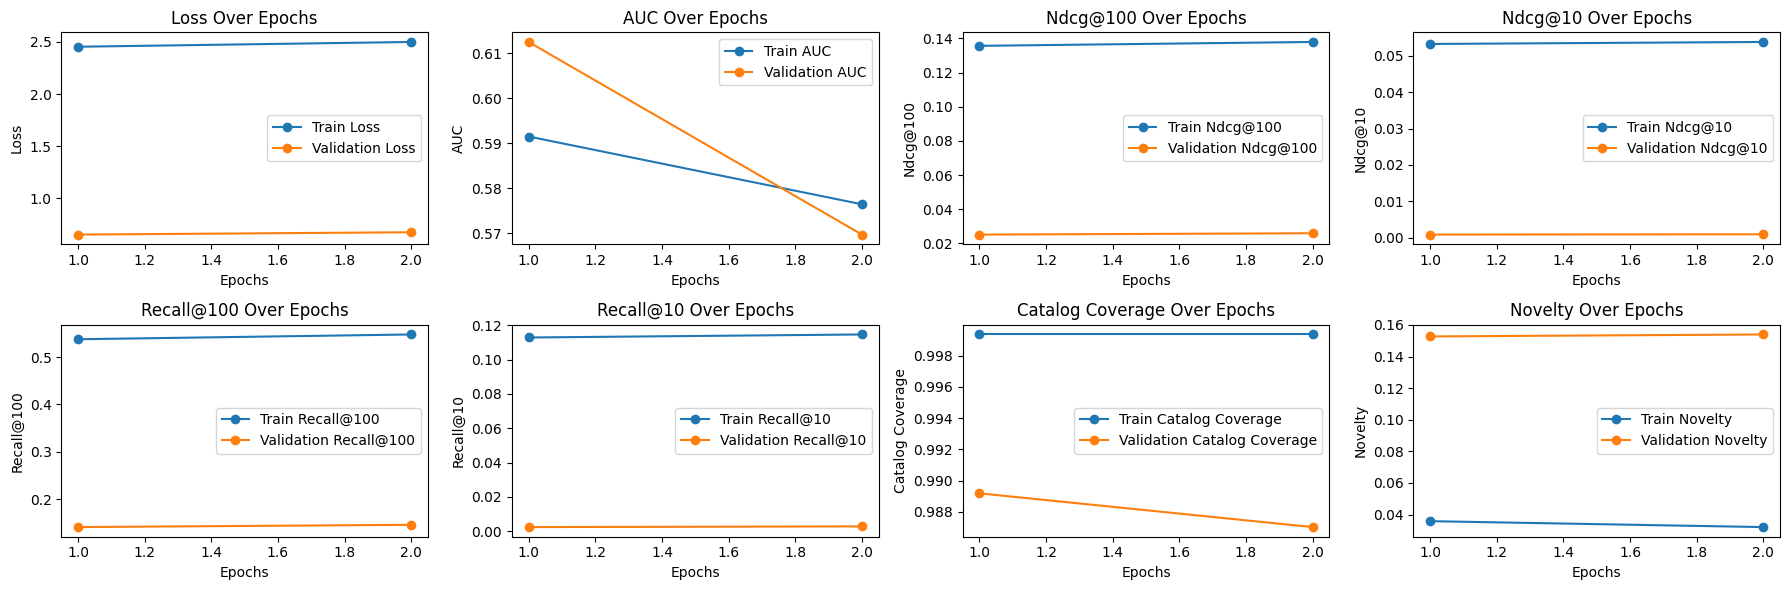

In [41]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Ndcg@10': 'ndcg_at_10',
    'Recall@100': 'recall_at_100',
    'Recall@10': 'recall_at_10',
    # 'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


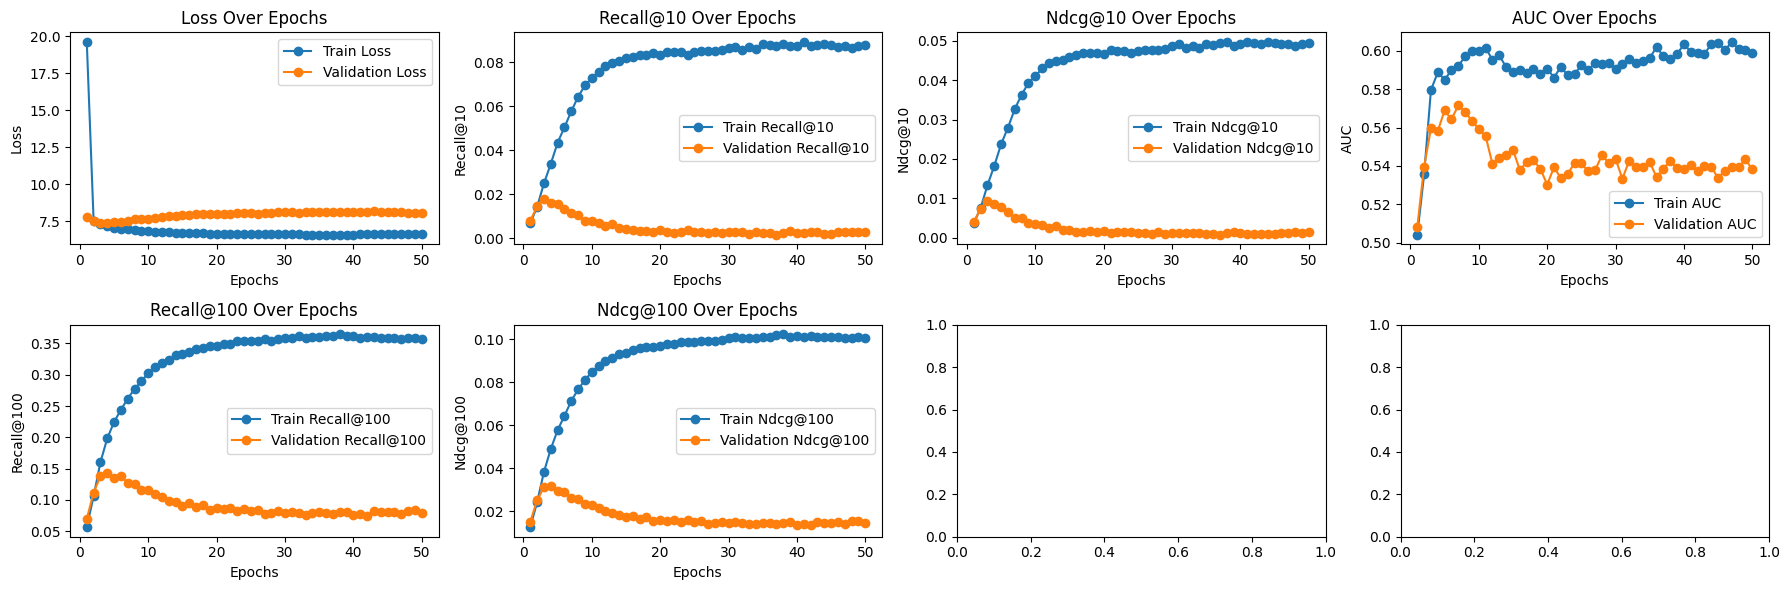

In [42]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

### model_v102

In [40]:
VERSION = 'v102'

_tower_dim = {
    'user':[512],
    'item':[1024, 512],
}

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 2 # @param
_validation_freq = 1 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param
_logits_temperature = 1

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 196
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [41]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [42]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block,  # needed to initiate the text embeddings
    # regularize={},
    logits_temperature=_logits_temperature
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=25, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=25, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [49]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 7s 131ms/step - loss: 6.8449 - auc: 0.7854 - recall_at_100: 0.2978 - mrr_at_100: 0.0410 - ndcg_at_100: 0.0864 - map_at_100: 0.0410 - precision_at_100: 0.0030 - recall_at_10: 0.0783 - mrr_at_10: 0.0345 - ndcg_at_10: 0.0446 - map_at_10: 0.0345 - precision_at_10: 0.0078 - regularization_loss: 0.0122 - loss_batch: 6.7585 - val_loss: 7.9970 - val_auc: 0.6141 - val_recall_at_100: 0.1103 - val_mrr_at_100: 0.0056 - val_ndcg_at_100: 0.0228 - val_map_at_100: 0.0056 - val_precision_at_100: 0.0011 - val_recall_at_10: 0.0097 - val_mrr_at_10: 0.0032 - val_ndcg_at_10: 0.0047 - val_map_at_10: 0.0032 - val_precision_at_10: 9.6964e-04 - val_regularization_loss: 0.0130 - val_loss_batch: 7.4399
Epoch 2/50
35/35 [==============================] - 4s 65ms/step - loss: 6.8404 - auc: 0.7870 - recall_at_100: 0.2962 - mrr_at_100: 0.0416 - ndcg_at_100: 0.0868 - map_at_100: 0.0416 - precision_at_100: 0.0030 - recall_at_10: 0.0808 - mrr_at_10: 0.0351 - ndcg_at_10

#### analysis

In [45]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v102


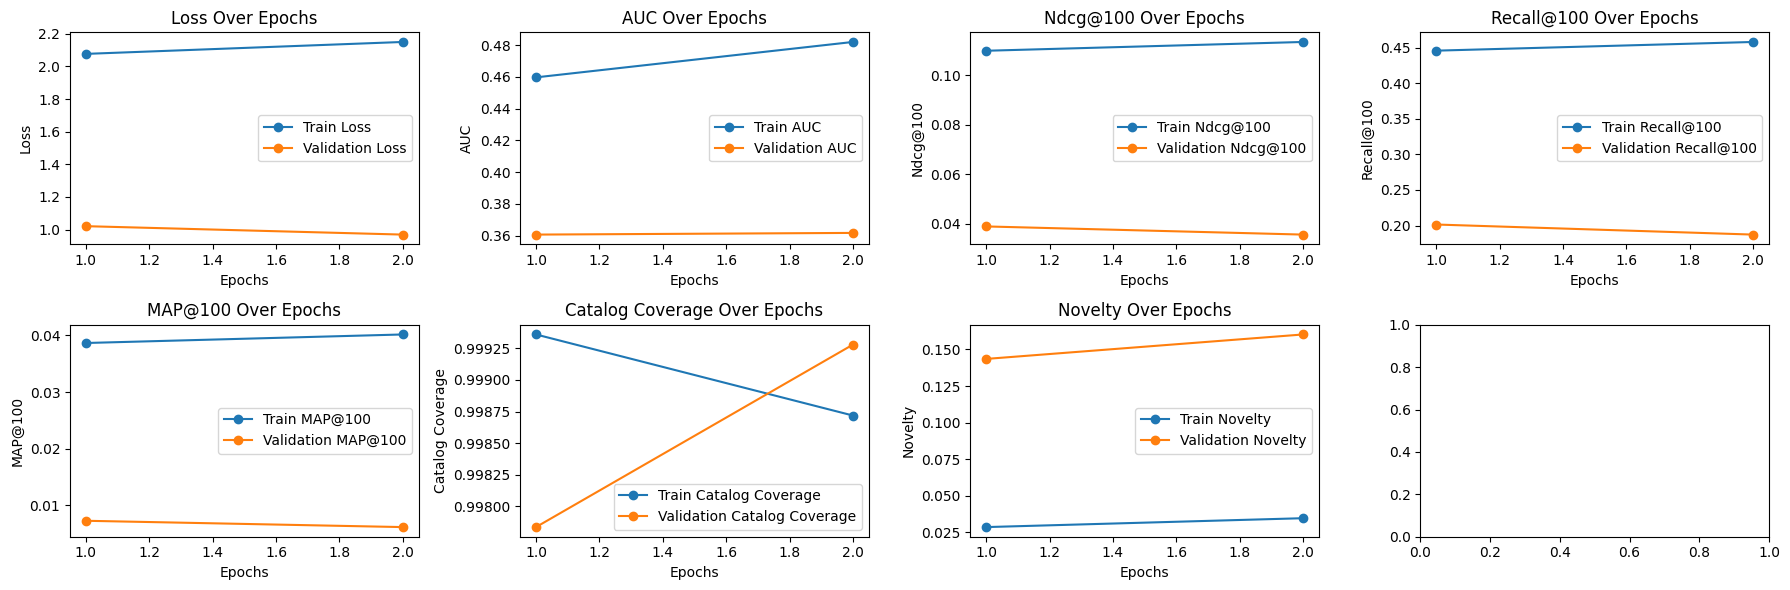

In [46]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v102


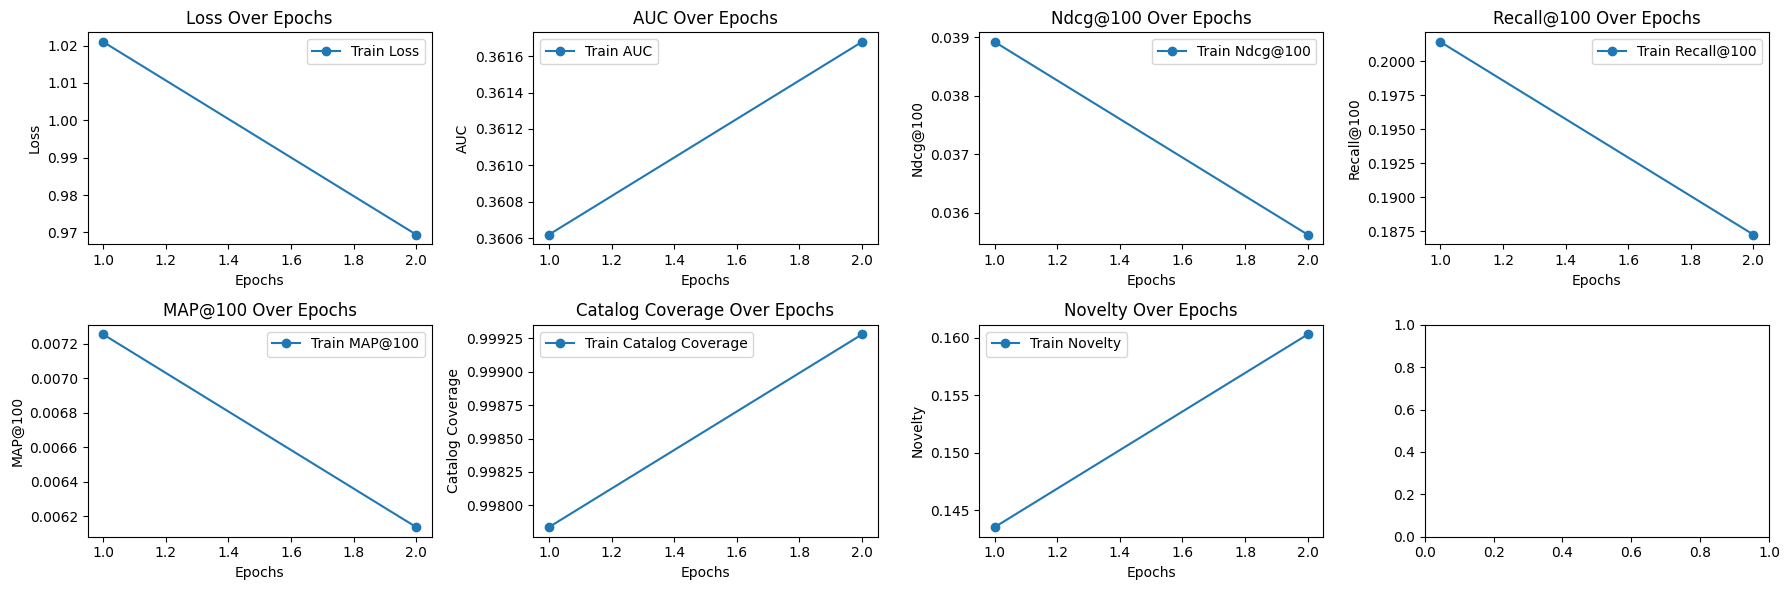

In [47]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history_val, None, _metrics)


Plot for model v10


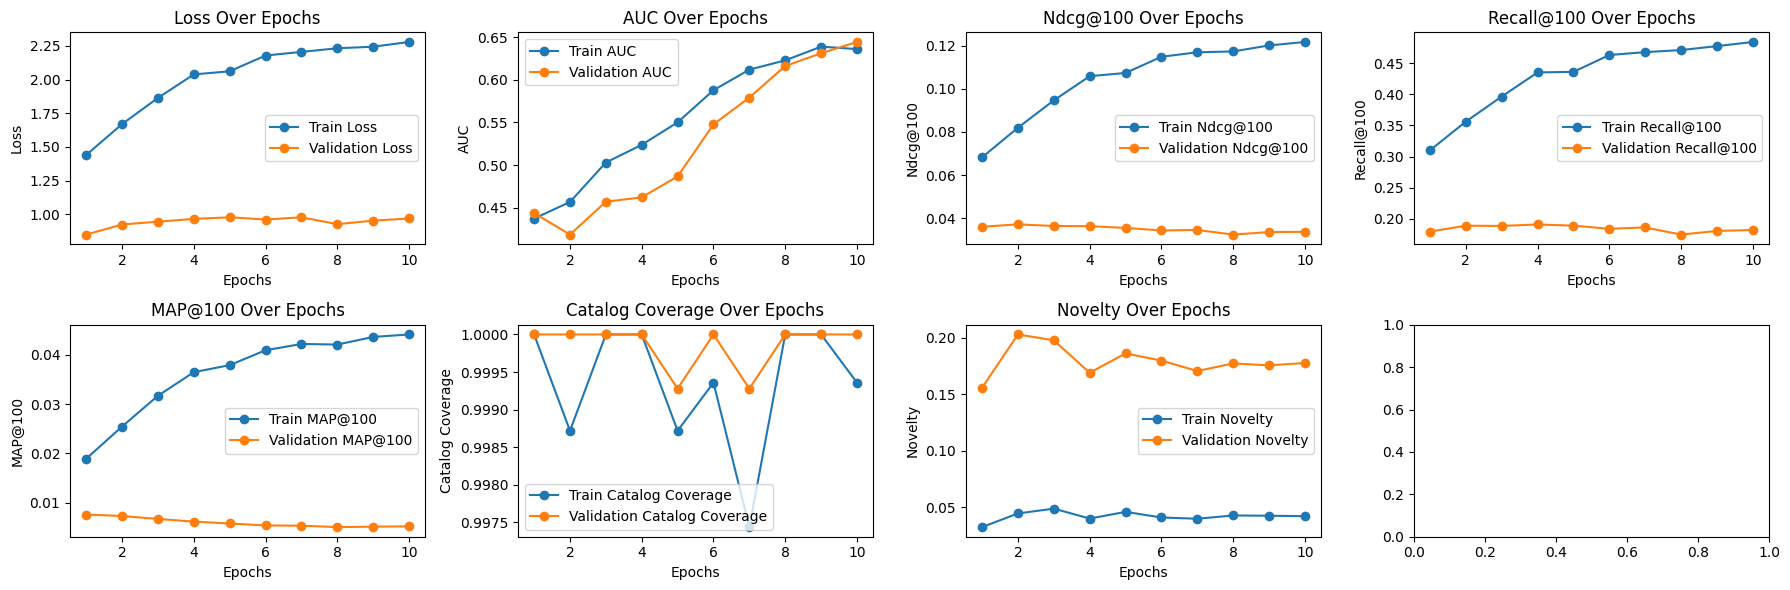

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


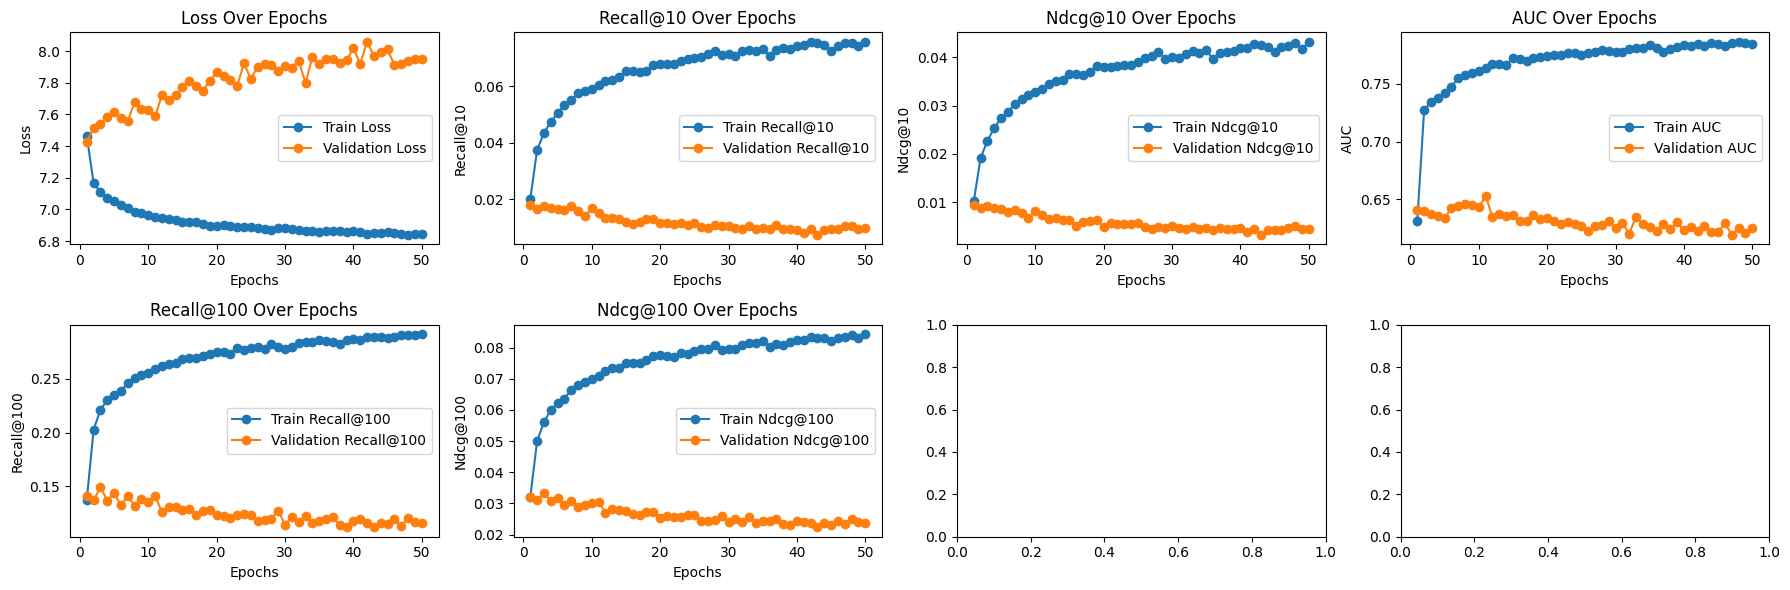

In [48]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

### model_v103

In [ ]:
VERSION = 'v103'

_tower_dim = {
    'user':[256, 256],
    'item':[256, 256],
}

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size # @param
_validation_freq = 1 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 96
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [ ]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [ ]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block  # needed to initiate the text embeddings
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=10, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=10, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 34s 621ms/step - loss: 7.4966 - auc: 0.6039 - recall_at_100: 0.0819 - mrr_at_100: 0.0056 - ndcg_at_100: 0.0184 - map_at_100: 0.0056 - precision_at_100: 8.1856e-04 - recall_at_50: 0.0438 - mrr_at_50: 0.0050 - ndcg_at_50: 0.0123 - map_at_50: 0.0050 - precision_at_50: 8.7559e-04 - recall_at_10: 0.0106 - mrr_at_10: 0.0037 - ndcg_at_10: 0.0053 - map_at_10: 0.0037 - precision_at_10: 0.0011 - regularization_loss: 0.0000e+00 - loss_batch: 7.4223 - val_loss: 7.3945 - val_auc: 0.6579 - val_recall_at_100: 0.1402 - val_mrr_at_100: 0.0088 - val_ndcg_at_100: 0.0307 - val_map_at_100: 0.0088 - val_precision_at_100: 0.0014 - val_recall_at_50: 0.0725 - val_mrr_at_50: 0.0078 - val_ndcg_at_50: 0.0198 - val_map_at_50: 0.0078 - val_precision_at_50: 0.0014 - val_recall_at_10: 0.0156 - val_mrr_at_10: 0.0056 - val_ndcg_at_10: 0.0079 - val_map_at_10: 0.0056 - val_precision_at_10: 0.0016 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 6.3161
Epoch 2/50


69/69 [==============================] - 7s 21ms/step - loss: 1.7324 - auc: 0.5667 - recall_at_100: 0.3651 - mrr_at_100: 0.0273 - ndcg_at_100: 0.0854 - map_at_100: 0.0273 - precision_at_100: 0.0037 - recall_at_10: 0.0575 - mrr_at_10: 0.0185 - ndcg_at_10: 0.0275 - map_at_10: 0.0185 - precision_at_10: 0.0057 - regularization_loss: 0.0000e+00 - loss_batch: 1.7427
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7323670387268066, 'auc': 0.5666812062263489, 'recall_at_100': 0.36704081296920776, 'mrr_at_100': 0.028207382187247276, 'ndcg_at_100': 0.08657605946063995, 'map_at_100': 0.028207382187247276, 'precision_at_100': 0.0036704079248011112, 'recall_at_10': 0.05967066437005997, 'mrr_at_10': 0.019423503428697586, 'ndcg_at_10': 0.028665069490671158, 'map_at_10': 0.019423503428697586, 'precision_at_10': 0.005967066623270512, 'regularization_loss': 0.0, 'loss_batch': 2.231379985809326, 'coverage': 1.0, 'novelty': 0.04095370450794754}
Candidate set rows: 1387


15/15 [==============================] - 5s 37ms/step - loss: 0.9345 - auc: 0.5850 - recall_at_100: 0.1817 - mrr_at_100: 0.0064 - ndcg_at_100: 0.0351 - map_at_100: 0.0064 - precision_at_100: 0.0018 - recall_at_10: 0.0105 - mrr_at_10: 0.0022 - ndcg_at_10: 0.0041 - map_at_10: 0.0022 - precision_at_10: 0.0011 - regularization_loss: 0.0000e+00 - loss_batch: 0.9830
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9345451593399048, 'auc': 0.5849609375, 'recall_at_100': 0.18757523596286774, 'mrr_at_100': 0.00700428755953908, 'ndcg_at_100': 0.03659487143158913, 'map_at_100': 0.00700428755953908, 'precision_at_100': 0.0018757523503154516, 'recall_at_10': 0.011903169564902782, 'mrr_at_10': 0.0027449256740510464, 'ndcg_at_10': 0.004811782855540514, 'map_at_10': 0.0027449256740510464, 'precision_at_10': 0.0011903168633580208, 'regularization_loss': 0.0, 'loss_batch': 1.4892228841781616, 'coverage': 0.9870223503965393, 'novelty': 0.18814844373503592}
35/35 [====================

69/69 [==============================] - 5s 23ms/step - loss: 1.9925 - auc: 0.5434 - recall_at_100: 0.4212 - mrr_at_100: 0.0337 - ndcg_at_100: 0.1007 - map_at_100: 0.0337 - precision_at_100: 0.0042 - recall_at_10: 0.0724 - mrr_at_10: 0.0236 - ndcg_at_10: 0.0348 - map_at_10: 0.0236 - precision_at_10: 0.0072 - regularization_loss: 0.0000e+00 - loss_batch: 2.0055
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9924883842468262, 'auc': 0.5433974862098694, 'recall_at_100': 0.4218968152999878, 'mrr_at_100': 0.03398360311985016, 'ndcg_at_100': 0.10113386809825897, 'map_at_100': 0.03398360311985016, 'precision_at_100': 0.004218969028443098, 'recall_at_10': 0.07303211092948914, 'mrr_at_10': 0.02387097477912903, 'ndcg_at_10': 0.035155024379491806, 'map_at_10': 0.02387097477912903, 'precision_at_10': 0.007303211838006973, 'regularization_loss': 0.0, 'loss_batch': 2.625227451324463, 'coverage': 1.0, 'novelty': 0.03690802348336595}
Candidate set rows: 1387


15/15 [==============================] - 11s 32ms/step - loss: 0.9431 - auc: 0.5403 - recall_at_100: 0.1828 - mrr_at_100: 0.0060 - ndcg_at_100: 0.0347 - map_at_100: 0.0060 - precision_at_100: 0.0018 - recall_at_10: 0.0093 - mrr_at_10: 0.0020 - ndcg_at_10: 0.0036 - map_at_10: 0.0020 - precision_at_10: 9.3409e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9816
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9431490302085876, 'auc': 0.5402566194534302, 'recall_at_100': 0.1859034299850464, 'mrr_at_100': 0.006577146705240011, 'ndcg_at_100': 0.03575333207845688, 'map_at_100': 0.006577146705240011, 'precision_at_100': 0.0018590344116091728, 'recall_at_10': 0.010298248380422592, 'mrr_at_10': 0.002440446987748146, 'ndcg_at_10': 0.00422116881236434, 'map_at_10': 0.002440446987748146, 'precision_at_10': 0.0010298247216269374, 'regularization_loss': 0.0, 'loss_batch': 1.3837964534759521, 'coverage': 0.9906272530641672, 'novelty': 0.1630359612724758}
35/35 [============

69/69 [==============================] - 6s 31ms/step - loss: 2.0388 - auc: 0.5608 - recall_at_100: 0.4304 - mrr_at_100: 0.0345 - ndcg_at_100: 0.1032 - map_at_100: 0.0345 - precision_at_100: 0.0043 - recall_at_10: 0.0755 - mrr_at_10: 0.0241 - ndcg_at_10: 0.0359 - map_at_10: 0.0241 - precision_at_10: 0.0075 - regularization_loss: 0.0000e+00 - loss_batch: 2.0539
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.0388457775115967, 'auc': 0.5608031749725342, 'recall_at_100': 0.4314122200012207, 'mrr_at_100': 0.03568214178085327, 'ndcg_at_100': 0.1044798344373703, 'map_at_100': 0.03568214178085327, 'precision_at_100': 0.004314121790230274, 'recall_at_10': 0.07753340154886246, 'mrr_at_10': 0.02524939738214016, 'ndcg_at_10': 0.03724619746208191, 'map_at_10': 0.02524939738214016, 'precision_at_10': 0.007753340061753988, 'regularization_loss': 0.0, 'loss_batch': 2.7665252685546875, 'coverage': 1.0, 'novelty': 0.042648455519876984}
Candidate set rows: 1387


15/15 [==============================] - 3s 23ms/step - loss: 0.9687 - auc: 0.5499 - recall_at_100: 0.1844 - mrr_at_100: 0.0061 - ndcg_at_100: 0.0349 - map_at_100: 0.0061 - precision_at_100: 0.0018 - recall_at_10: 0.0086 - mrr_at_10: 0.0020 - ndcg_at_10: 0.0035 - map_at_10: 0.0020 - precision_at_10: 8.6266e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0195
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9686815142631531, 'auc': 0.5499061346054077, 'recall_at_100': 0.18871204555034637, 'mrr_at_100': 0.0061890678480267525, 'ndcg_at_100': 0.03576025739312172, 'map_at_100': 0.0061890678480267525, 'precision_at_100': 0.0018871204229071736, 'recall_at_10': 0.008492711000144482, 'mrr_at_10': 0.0019665067084133625, 'ndcg_at_10': 0.003430602140724659, 'map_at_10': 0.0019665067084133625, 'precision_at_10': 0.0008492710767313838, 'regularization_loss': 0.0, 'loss_batch': 1.551398754119873, 'coverage': 0.9870223503965393, 'novelty': 0.1760971055088702}
35/35 [========

69/69 [==============================] - 6s 34ms/step - loss: 2.0970 - auc: 0.5344 - recall_at_100: 0.4431 - mrr_at_100: 0.0373 - ndcg_at_100: 0.1080 - map_at_100: 0.0373 - precision_at_100: 0.0044 - recall_at_10: 0.0813 - mrr_at_10: 0.0265 - ndcg_at_10: 0.0391 - map_at_10: 0.0265 - precision_at_10: 0.0081 - regularization_loss: 0.0000e+00 - loss_batch: 2.1107
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.096954107284546, 'auc': 0.5344473123550415, 'recall_at_100': 0.44323524832725525, 'mrr_at_100': 0.03766551613807678, 'ndcg_at_100': 0.10841073095798492, 'map_at_100': 0.03766551613807678, 'precision_at_100': 0.004432352725416422, 'recall_at_10': 0.08213441073894501, 'mrr_at_10': 0.026898717507719994, 'ndcg_at_10': 0.03958825767040253, 'map_at_10': 0.026898717507719994, 'precision_at_10': 0.00821344181895256, 'regularization_loss': 0.0, 'loss_batch': 2.762500762939453, 'coverage': 1.0, 'novelty': 0.040674603174603176}
Candidate set rows: 1387


15/15 [==============================] - 3s 24ms/step - loss: 0.9721 - auc: 0.5327 - recall_at_100: 0.1841 - mrr_at_100: 0.0056 - ndcg_at_100: 0.0344 - map_at_100: 0.0056 - precision_at_100: 0.0018 - recall_at_10: 0.0080 - mrr_at_10: 0.0017 - ndcg_at_10: 0.0031 - map_at_10: 0.0017 - precision_at_10: 7.9555e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0161
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9721490144729614, 'auc': 0.5326675772666931, 'recall_at_100': 0.18757523596286774, 'mrr_at_100': 0.006142031867057085, 'ndcg_at_100': 0.03548189997673035, 'map_at_100': 0.006142031867057085, 'precision_at_100': 0.0018757523503154516, 'recall_at_10': 0.008425839245319366, 'mrr_at_10': 0.0020394818857312202, 'ndcg_at_10': 0.0034857038408517838, 'map_at_10': 0.0020394818857312202, 'precision_at_10': 0.000842583947815001, 'regularization_loss': 0.0, 'loss_batch': 1.4761700630187988, 'coverage': 0.9855803893294881, 'novelty': 0.17242640336441764}
35/35 [========

69/69 [==============================] - 5s 22ms/step - loss: 2.1596 - auc: 0.5565 - recall_at_100: 0.4527 - mrr_at_100: 0.0390 - ndcg_at_100: 0.1112 - map_at_100: 0.0390 - precision_at_100: 0.0045 - recall_at_10: 0.0843 - mrr_at_10: 0.0280 - ndcg_at_10: 0.0409 - map_at_10: 0.0280 - precision_at_10: 0.0084 - regularization_loss: 0.0000e+00 - loss_batch: 2.1728
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.1595840454101562, 'auc': 0.5564848184585571, 'recall_at_100': 0.45152559876441956, 'mrr_at_100': 0.03890974819660187, 'ndcg_at_100': 0.11093121767044067, 'map_at_100': 0.03890974819660187, 'precision_at_100': 0.004515256732702255, 'recall_at_10': 0.08462721854448318, 'mrr_at_10': 0.027932433411478996, 'ndcg_at_10': 0.040954653173685074, 'map_at_10': 0.027932433411478996, 'precision_at_10': 0.008462720550596714, 'regularization_loss': 0.0, 'loss_batch': 2.7992193698883057, 'coverage': 1.0, 'novelty': 0.0413360803050892}
Candidate set rows: 1387


15/15 [==============================] - 5s 36ms/step - loss: 0.9492 - auc: 0.5553 - recall_at_100: 0.1754 - mrr_at_100: 0.0051 - ndcg_at_100: 0.0327 - map_at_100: 0.0051 - precision_at_100: 0.0018 - recall_at_10: 0.0069 - mrr_at_10: 0.0013 - ndcg_at_10: 0.0025 - map_at_10: 0.0013 - precision_at_10: 6.8770e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0011
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9491551518440247, 'auc': 0.555303692817688, 'recall_at_100': 0.17881503701210022, 'mrr_at_100': 0.005609558895230293, 'ndcg_at_100': 0.03366200625896454, 'map_at_100': 0.005609558895230293, 'precision_at_100': 0.0017881502863019705, 'recall_at_10': 0.00795773696154356, 'mrr_at_10': 0.0016461329068988562, 'ndcg_at_10': 0.0030620815232396126, 'map_at_10': 0.0016461329068988562, 'precision_at_10': 0.0007957737543620169, 'regularization_loss': 0.0, 'loss_batch': 1.5439296960830688, 'coverage': 0.9863013698630136, 'novelty': 0.1802025606726543}
35/35 [==========

#### analysis

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v103


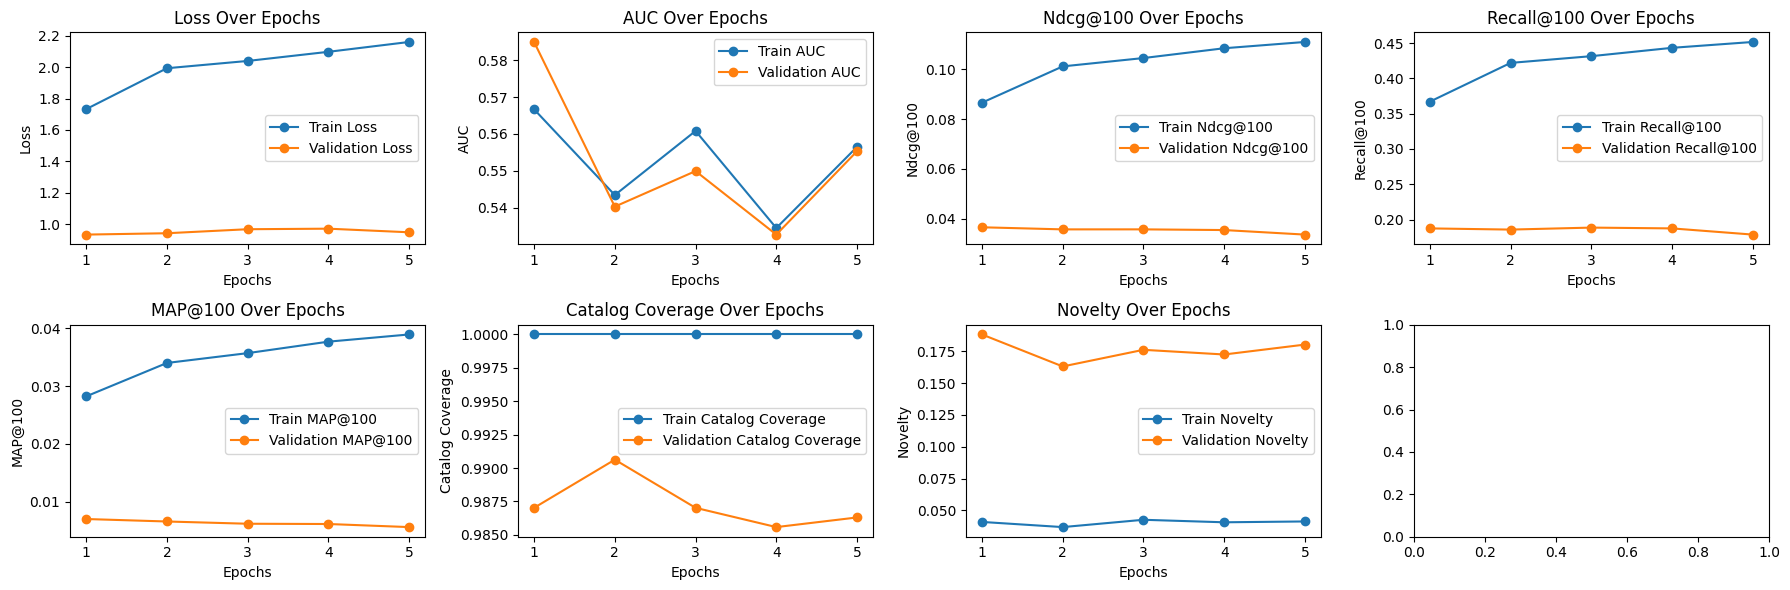

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


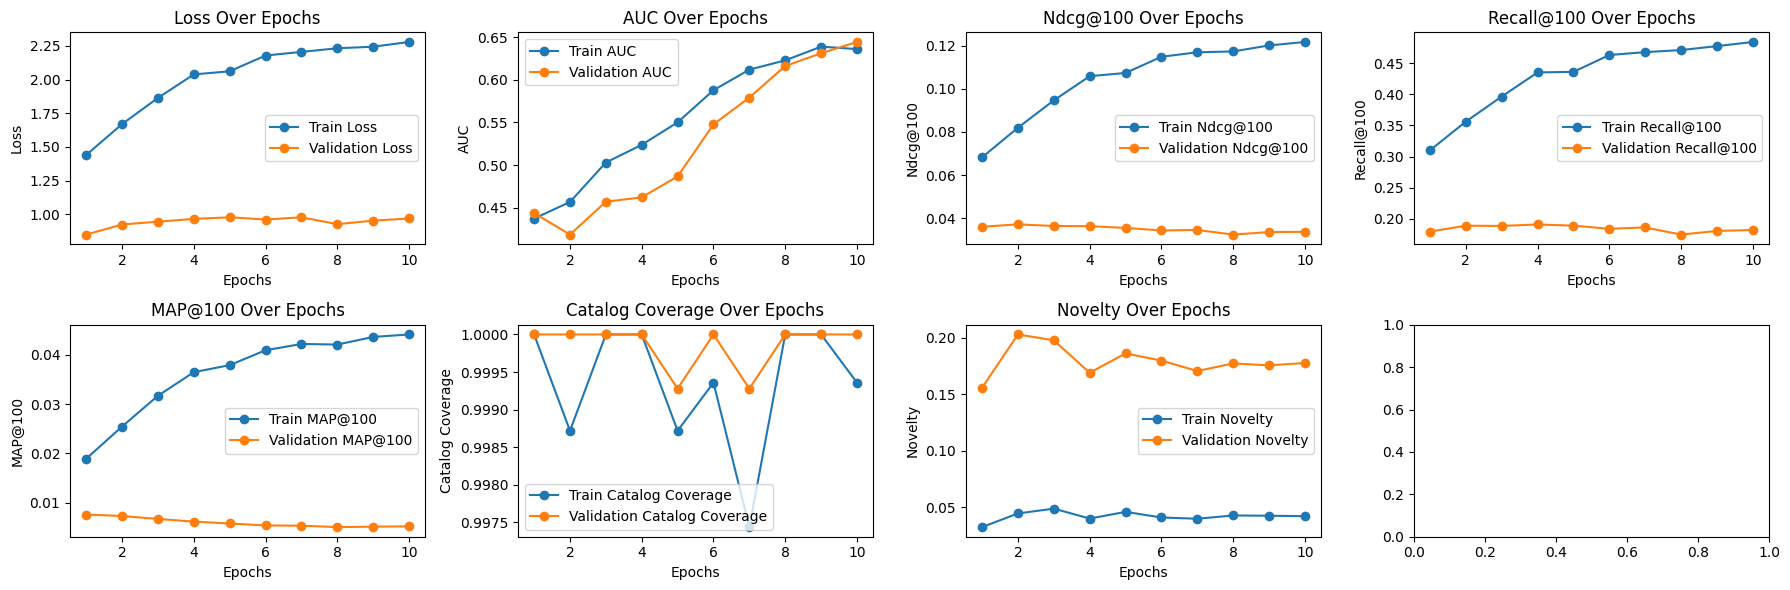

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


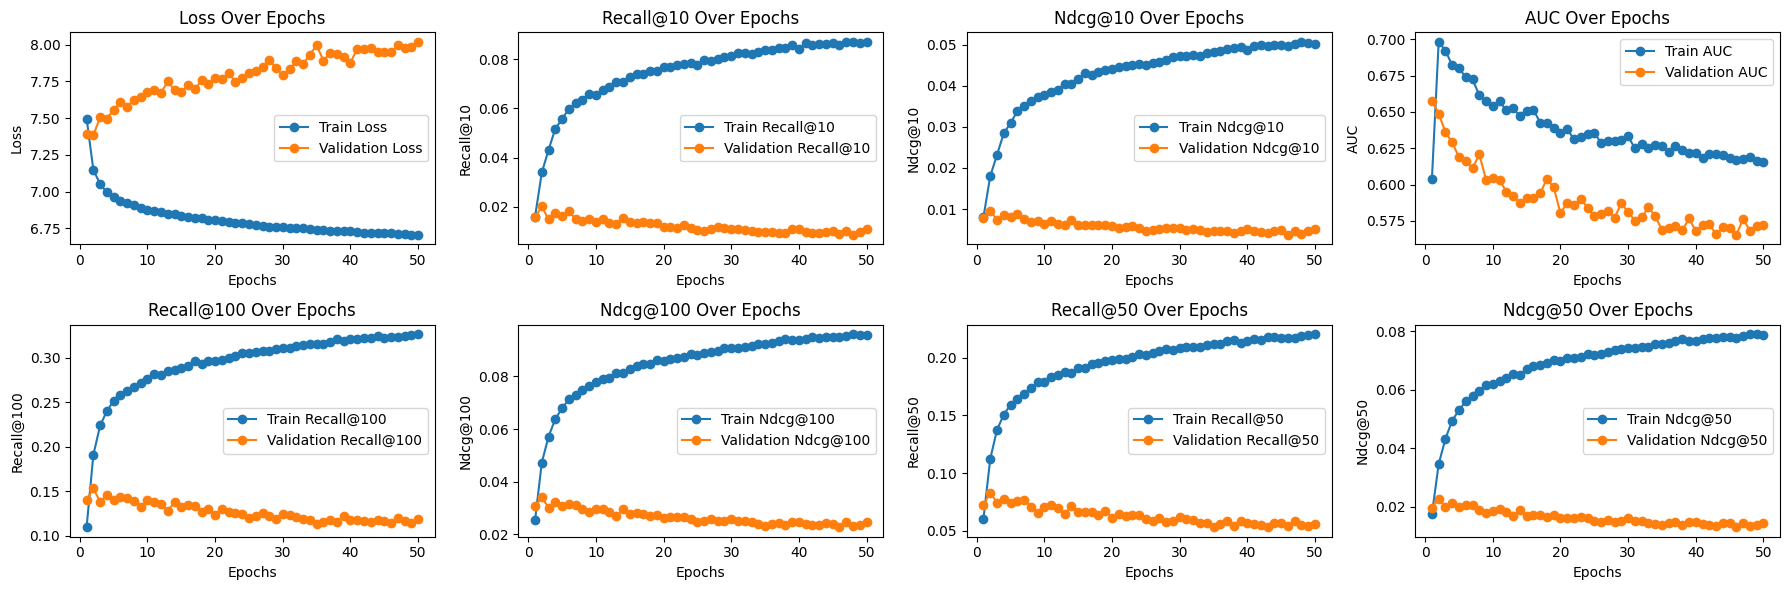

In [ ]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}